# Credits
Based on [DCGAN-tensorflow](https://github.com/carpedm20/DCGAN-tensorflow) by [Taehoon Kim](https://github.com/carpedm20) on GitHub.

In [1]:
import numpy as np
import tensorflow as tf
import os, time
from glob import glob
import random
from tqdm import tqdm_notebook as tqdm
# from ops import batch_norm, linear, conv2d, deconv2d, lrelu
# from image_helpers import *

In [2]:
is_crop = True
batch_size = 64
image_size = 2
sample_size = 64
image_shape = [2] #[64, 64, 3]

z_dim = 1

gf_dim = 64
df_dim = 64

learning_rate = 0.0002
beta1 = 0.9

dataset = "celebA"

In [3]:

def _leaky_relu(x):
  return tf.nn.leaky_relu(x, alpha=0.2)


def _batch_norm(x, is_training, name):
  return tf.layers.batch_normalization(
      x, momentum=0.8, epsilon=0.001, training=is_training, name=name)


In [4]:
def discriminator(x, is_training=True, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
            tf.logging.debug('D -- Input %s', x)

            x = tf.layers.Dense(units=25, name='d_fc_1')(x)
            tf.logging.debug(x)
            x = _leaky_relu(x)
            # x = _batch_norm(x, is_training, name='g_bn1')

            x = tf.layers.Dense(units=10, name='d_fc_2')(x)
            tf.logging.debug(x)
            x = _leaky_relu(x)
            # x = _batch_norm(x, is_training, name='g_bn2')

            # x = tf.layers.Dense(units=50, name='d_fc_3')(x)
            # tf.logging.debug(x)
            # x = _leaky_relu(x)
            # x = _batch_norm(x, is_training, name='g_bn3')

            discriminate = tf.layers.Dense(units=1, name='d_fc')(x)
            tf.logging.debug(discriminate)

    return tf.nn.sigmoid(x), x

In [5]:
def generator(x, is_training=True):
    with tf.variable_scope('Generator', reuse=tf.AUTO_REUSE):
        tf.logging.debug('G -- Input %s', x)

        x = tf.layers.Dense(units=10, name='g_fc_1')(x)
        tf.logging.debug(x)
        x = _leaky_relu(x)
        # x = _batch_norm(x, is_training, name='g_bn1')

        x = tf.layers.Dense(units=25, name='g_fc_2')(x)
        tf.logging.debug(x)
        x = _leaky_relu(x)
        # x = _batch_norm(x, is_training, name='g_bn2')

        # x = tf.layers.Dense(units=500, name='g_fc_3')(x)
        # tf.logging.debug(x)
        # x = _leaky_relu(x)
        # x = _batch_norm(x, is_training, name='g_bn3')

        x = tf.layers.Dense(units=2, name='g_fc')(x)
        tf.logging.debug(x)

        return x

In [6]:
images = tf.placeholder(tf.float32, [batch_size] + image_shape, name='real_images')
sample_images= tf.placeholder(tf.float32, [sample_size] + image_shape, name='sample_images')
z = tf.placeholder(tf.float32, [None, z_dim], name='z')
is_training = tf.placeholder( tf.bool, [], name='is_training')

G = generator(z, is_training)
D, D_logits = discriminator(images, is_training)
D_, D_logits_ = discriminator(G, is_training, reuse=True)

d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits, labels=tf.ones_like(D)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_, labels=tf.zeros_like(D_)))
d_loss = 1/2*(d_loss_real + d_loss_fake)

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits_, labels=tf.ones_like(D_)))

In [7]:
# Optimizers
t_vars = tf.trainable_variables()

d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

# d_optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
# g_optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

In [8]:
sess = tf.Session()
# sess.run(tf.initialize_all_variables())
writer = tf.summary.FileWriter('model_out/dummy_gan', sess.graph)

saver = tf.train.Saver()

In [9]:
d_optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
sess.run(tf.global_variables_initializer())

tf.summary.scalar("g_loss", g_loss)
tf.summary.scalar("d_loss", d_loss)
merged_summary_op = tf.summary.merge_all()

NUMBER_OF_GAUSSIANS = 2
def sample_toy_distr():
    x = np.random.normal(0, 0.1)
    y = np.random.normal(0, 0.1)
#     centers = [(i*5,j*10) for i in range(NUMBER_OF_GAUSSIANS) for j in range(NUMBER_OF_GAUSSIANS)]
    centers = [(0,-1), (1,0), (-0.5,0.5)]

    mu_x, mu_y = random.sample(centers,1)[0]
    return [x + mu_x, y + mu_y]

def sample_data(batch_size):
    return np.array([sample_toy_distr() for _ in range(batch_size)])


# Rescale -1 to 1
#         X_train = X_train / 127.5 - 1.
#         X_train = np.expand_dims(X_train, axis=3)
X_train = sample_data(batch_size*5000)

sample_z = np.random.uniform(-1, 1, size=(sample_size , z_dim))
sample_images = sample_data(batch_size)

counter = 1
start_time = time.time()

for epoch in range(15):
#     batch_idxs = int(len(data)/batch_size)
    batch_idxs = 1000
    for idx in range(batch_idxs):
        batch_images = sample_data(batch_size)
        batch_z = np.random.normal(0, 1, [batch_size, z_dim])

        # Update D network
        _, summary = sess.run([d_optim, merged_summary_op], feed_dict={images: batch_images, z: batch_z, is_training: True})
        writer.add_summary(summary, epoch)

        # Update G network
        sess.run([g_optim], feed_dict={z: batch_z, is_training: True})

        # Run g_optim twice to make sure that d_loss does not go to zero (different from paper)
#         sess.run([g_optim], feed_dict={z: batch_z})

        errD_fake = d_loss_fake.eval({z: batch_z, is_training: True}, session=sess)
        errD_real = d_loss_real.eval({images: batch_images, is_training: True}, session=sess)
        errG = g_loss.eval({z: batch_z, is_training: True}, session=sess)

        counter += 1
        print('Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss: %.8f, g_loss: %.8f' \
            % (epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

        if np.mod(counter, 100) == 1:
            samples, dl, gl = sess.run([G, d_loss, g_loss], feed_dict={z: sample_z, images: sample_images, is_training: False})
#             save_images(samples, [8, 8], './samples/train_%s_%s.png' % (epoch, idx))
            print('[Sample] d_loss: %.8f, g_loss: %.8f' % (dl, gl))

Epoch: [ 0] [   0/1000] time: 0.9000, d_loss: 1.35525990, g_loss: 0.67291194
Epoch: [ 0] [   1/1000] time: 0.9161, d_loss: 1.35842395, g_loss: 0.67440021
Epoch: [ 0] [   2/1000] time: 0.9301, d_loss: 1.36077523, g_loss: 0.67053854
Epoch: [ 0] [   3/1000] time: 0.9446, d_loss: 1.36509502, g_loss: 0.66938031
Epoch: [ 0] [   4/1000] time: 0.9539, d_loss: 1.35607326, g_loss: 0.67049694
Epoch: [ 0] [   5/1000] time: 0.9640, d_loss: 1.35405898, g_loss: 0.67463309
Epoch: [ 0] [   6/1000] time: 0.9730, d_loss: 1.36226726, g_loss: 0.66937602
Epoch: [ 0] [   7/1000] time: 0.9887, d_loss: 1.36562622, g_loss: 0.66918886
Epoch: [ 0] [   8/1000] time: 1.0019, d_loss: 1.36012220, g_loss: 0.67039520
Epoch: [ 0] [   9/1000] time: 1.0129, d_loss: 1.35082746, g_loss: 0.67405063
Epoch: [ 0] [  10/1000] time: 1.0229, d_loss: 1.35880756, g_loss: 0.67147011
Epoch: [ 0] [  11/1000] time: 1.0397, d_loss: 1.35277593, g_loss: 0.67207193
Epoch: [ 0] [  12/1000] time: 1.0548, d_loss: 1.35237122, g_loss: 0.67387336

Epoch: [ 0] [ 108/1000] time: 2.6371, d_loss: 1.36838198, g_loss: 0.65703875
Epoch: [ 0] [ 109/1000] time: 2.6552, d_loss: 1.37182879, g_loss: 0.65731347
Epoch: [ 0] [ 110/1000] time: 2.6733, d_loss: 1.37624741, g_loss: 0.65267831
Epoch: [ 0] [ 111/1000] time: 2.6889, d_loss: 1.36969042, g_loss: 0.65839773
Epoch: [ 0] [ 112/1000] time: 2.7086, d_loss: 1.38162196, g_loss: 0.65002549
Epoch: [ 0] [ 113/1000] time: 2.7307, d_loss: 1.37947631, g_loss: 0.65129972
Epoch: [ 0] [ 114/1000] time: 2.7452, d_loss: 1.37521660, g_loss: 0.65505683
Epoch: [ 0] [ 115/1000] time: 2.7571, d_loss: 1.37406588, g_loss: 0.65727556
Epoch: [ 0] [ 116/1000] time: 2.7762, d_loss: 1.37220955, g_loss: 0.65483701
Epoch: [ 0] [ 117/1000] time: 2.7923, d_loss: 1.36705637, g_loss: 0.65969557
Epoch: [ 0] [ 118/1000] time: 2.8085, d_loss: 1.38576317, g_loss: 0.64745128
Epoch: [ 0] [ 119/1000] time: 2.8263, d_loss: 1.37211931, g_loss: 0.65688741
Epoch: [ 0] [ 120/1000] time: 2.8373, d_loss: 1.37404263, g_loss: 0.65620601

Epoch: [ 0] [ 221/1000] time: 4.6341, d_loss: 1.38304067, g_loss: 0.66643906
Epoch: [ 0] [ 222/1000] time: 4.6458, d_loss: 1.37708235, g_loss: 0.66602135
Epoch: [ 0] [ 223/1000] time: 4.6606, d_loss: 1.38360310, g_loss: 0.66489363
Epoch: [ 0] [ 224/1000] time: 4.6916, d_loss: 1.37481308, g_loss: 0.66967863
Epoch: [ 0] [ 225/1000] time: 4.7066, d_loss: 1.37676287, g_loss: 0.66770709
Epoch: [ 0] [ 226/1000] time: 4.7228, d_loss: 1.37212729, g_loss: 0.66900122
Epoch: [ 0] [ 227/1000] time: 4.7400, d_loss: 1.36932254, g_loss: 0.67243993
Epoch: [ 0] [ 228/1000] time: 4.7530, d_loss: 1.37334263, g_loss: 0.66896582
Epoch: [ 0] [ 229/1000] time: 4.7688, d_loss: 1.37130475, g_loss: 0.67124641
Epoch: [ 0] [ 230/1000] time: 4.7876, d_loss: 1.36360002, g_loss: 0.67677641
Epoch: [ 0] [ 231/1000] time: 4.8000, d_loss: 1.37110484, g_loss: 0.67193592
Epoch: [ 0] [ 232/1000] time: 4.8194, d_loss: 1.36744857, g_loss: 0.67262334
Epoch: [ 0] [ 233/1000] time: 4.8367, d_loss: 1.37172961, g_loss: 0.67139655

Epoch: [ 0] [ 328/1000] time: 6.5746, d_loss: 1.33910871, g_loss: 0.69570881
Epoch: [ 0] [ 329/1000] time: 6.5956, d_loss: 1.33419204, g_loss: 0.69784051
Epoch: [ 0] [ 330/1000] time: 6.6122, d_loss: 1.34376669, g_loss: 0.69626588
Epoch: [ 0] [ 331/1000] time: 6.6238, d_loss: 1.34032631, g_loss: 0.69687670
Epoch: [ 0] [ 332/1000] time: 6.6376, d_loss: 1.34233785, g_loss: 0.69655770
Epoch: [ 0] [ 333/1000] time: 6.6564, d_loss: 1.33599854, g_loss: 0.69737917
Epoch: [ 0] [ 334/1000] time: 6.6692, d_loss: 1.34529996, g_loss: 0.69856608
Epoch: [ 0] [ 335/1000] time: 6.6823, d_loss: 1.34057987, g_loss: 0.69753981
Epoch: [ 0] [ 336/1000] time: 6.6968, d_loss: 1.34399939, g_loss: 0.69761539
Epoch: [ 0] [ 337/1000] time: 6.7144, d_loss: 1.34304059, g_loss: 0.69700623
Epoch: [ 0] [ 338/1000] time: 6.7258, d_loss: 1.33881593, g_loss: 0.69813603
Epoch: [ 0] [ 339/1000] time: 6.7401, d_loss: 1.34897423, g_loss: 0.69868898
Epoch: [ 0] [ 340/1000] time: 6.7472, d_loss: 1.34187198, g_loss: 0.69980359

Epoch: [ 0] [ 435/1000] time: 8.2671, d_loss: 1.33649898, g_loss: 0.70449483
Epoch: [ 0] [ 436/1000] time: 8.2766, d_loss: 1.31943631, g_loss: 0.70509487
Epoch: [ 0] [ 437/1000] time: 8.2874, d_loss: 1.34187651, g_loss: 0.70469749
Epoch: [ 0] [ 438/1000] time: 8.3005, d_loss: 1.35671020, g_loss: 0.70424497
Epoch: [ 0] [ 439/1000] time: 8.3236, d_loss: 1.32422447, g_loss: 0.70443755
Epoch: [ 0] [ 440/1000] time: 8.3364, d_loss: 1.32010174, g_loss: 0.70433253
Epoch: [ 0] [ 441/1000] time: 8.3509, d_loss: 1.32395720, g_loss: 0.70440179
Epoch: [ 0] [ 442/1000] time: 8.3660, d_loss: 1.34891725, g_loss: 0.70389783
Epoch: [ 0] [ 443/1000] time: 8.3788, d_loss: 1.33919001, g_loss: 0.70400518
Epoch: [ 0] [ 444/1000] time: 8.3908, d_loss: 1.33946657, g_loss: 0.70411044
Epoch: [ 0] [ 445/1000] time: 8.4032, d_loss: 1.32813036, g_loss: 0.70507395
Epoch: [ 0] [ 446/1000] time: 8.4111, d_loss: 1.34420872, g_loss: 0.70549780
Epoch: [ 0] [ 447/1000] time: 8.4225, d_loss: 1.34861445, g_loss: 0.70378715

Epoch: [ 0] [ 542/1000] time: 10.0196, d_loss: 1.37724519, g_loss: 0.66773921
Epoch: [ 0] [ 543/1000] time: 10.0370, d_loss: 1.38112116, g_loss: 0.66747361
Epoch: [ 0] [ 544/1000] time: 10.0576, d_loss: 1.40047145, g_loss: 0.65762180
Epoch: [ 0] [ 545/1000] time: 10.0700, d_loss: 1.39365625, g_loss: 0.66928464
Epoch: [ 0] [ 546/1000] time: 10.0896, d_loss: 1.35713923, g_loss: 0.68048954
Epoch: [ 0] [ 547/1000] time: 10.1037, d_loss: 1.37533236, g_loss: 0.65988171
Epoch: [ 0] [ 548/1000] time: 10.1187, d_loss: 1.38205397, g_loss: 0.66697103
Epoch: [ 0] [ 549/1000] time: 10.1296, d_loss: 1.38589191, g_loss: 0.65968466
Epoch: [ 0] [ 550/1000] time: 10.1450, d_loss: 1.39845443, g_loss: 0.65896332
Epoch: [ 0] [ 551/1000] time: 10.1659, d_loss: 1.35585105, g_loss: 0.66599816
Epoch: [ 0] [ 552/1000] time: 10.1818, d_loss: 1.37409317, g_loss: 0.66034645
Epoch: [ 0] [ 553/1000] time: 10.1994, d_loss: 1.36891294, g_loss: 0.66186792
Epoch: [ 0] [ 554/1000] time: 10.2136, d_loss: 1.40973115, g_los

Epoch: [ 0] [ 649/1000] time: 12.1469, d_loss: 1.46328521, g_loss: 0.61871564
Epoch: [ 0] [ 650/1000] time: 12.1647, d_loss: 1.49725354, g_loss: 0.61138219
Epoch: [ 0] [ 651/1000] time: 12.1794, d_loss: 1.50100207, g_loss: 0.60273755
Epoch: [ 0] [ 652/1000] time: 12.1984, d_loss: 1.47324753, g_loss: 0.60473841
Epoch: [ 0] [ 653/1000] time: 12.2109, d_loss: 1.51658773, g_loss: 0.59748411
Epoch: [ 0] [ 654/1000] time: 12.2280, d_loss: 1.49772573, g_loss: 0.61252367
Epoch: [ 0] [ 655/1000] time: 12.2396, d_loss: 1.49943984, g_loss: 0.61072052
Epoch: [ 0] [ 656/1000] time: 12.2590, d_loss: 1.48539412, g_loss: 0.60843921
Epoch: [ 0] [ 657/1000] time: 12.2697, d_loss: 1.49533367, g_loss: 0.60462004
Epoch: [ 0] [ 658/1000] time: 12.2814, d_loss: 1.47661281, g_loss: 0.61254925
Epoch: [ 0] [ 659/1000] time: 12.2950, d_loss: 1.50632834, g_loss: 0.59537512
Epoch: [ 0] [ 660/1000] time: 12.3086, d_loss: 1.48672438, g_loss: 0.61662710
Epoch: [ 0] [ 661/1000] time: 12.3245, d_loss: 1.50581014, g_los

Epoch: [ 0] [ 760/1000] time: 14.1013, d_loss: 1.46490955, g_loss: 0.63960564
Epoch: [ 0] [ 761/1000] time: 14.1158, d_loss: 1.45740509, g_loss: 0.64425385
Epoch: [ 0] [ 762/1000] time: 14.1305, d_loss: 1.47248864, g_loss: 0.63831347
Epoch: [ 0] [ 763/1000] time: 14.1431, d_loss: 1.45303428, g_loss: 0.64507067
Epoch: [ 0] [ 764/1000] time: 14.1581, d_loss: 1.47518420, g_loss: 0.63397747
Epoch: [ 0] [ 765/1000] time: 14.1719, d_loss: 1.46824050, g_loss: 0.63963151
Epoch: [ 0] [ 766/1000] time: 14.1895, d_loss: 1.47504807, g_loss: 0.63835412
Epoch: [ 0] [ 767/1000] time: 14.2043, d_loss: 1.44701219, g_loss: 0.65177381
Epoch: [ 0] [ 768/1000] time: 14.2186, d_loss: 1.45367050, g_loss: 0.64833194
Epoch: [ 0] [ 769/1000] time: 14.2362, d_loss: 1.44392943, g_loss: 0.65225309
Epoch: [ 0] [ 770/1000] time: 14.2501, d_loss: 1.46041203, g_loss: 0.64195764
Epoch: [ 0] [ 771/1000] time: 14.2655, d_loss: 1.45193470, g_loss: 0.64883649
Epoch: [ 0] [ 772/1000] time: 14.2780, d_loss: 1.46846151, g_los

Epoch: [ 0] [ 867/1000] time: 16.0340, d_loss: 1.36628962, g_loss: 0.71675771
Epoch: [ 0] [ 868/1000] time: 16.0488, d_loss: 1.37007105, g_loss: 0.71720755
Epoch: [ 0] [ 869/1000] time: 16.0804, d_loss: 1.36650515, g_loss: 0.71670592
Epoch: [ 0] [ 870/1000] time: 16.0962, d_loss: 1.36481667, g_loss: 0.71768355
Epoch: [ 0] [ 871/1000] time: 16.1094, d_loss: 1.36489594, g_loss: 0.71867764
Epoch: [ 0] [ 872/1000] time: 16.1204, d_loss: 1.36175680, g_loss: 0.71872425
Epoch: [ 0] [ 873/1000] time: 16.1379, d_loss: 1.36302590, g_loss: 0.71887779
Epoch: [ 0] [ 874/1000] time: 16.1548, d_loss: 1.36166549, g_loss: 0.72138226
Epoch: [ 0] [ 875/1000] time: 16.1681, d_loss: 1.36613476, g_loss: 0.71930724
Epoch: [ 0] [ 876/1000] time: 16.1859, d_loss: 1.36048710, g_loss: 0.72185898
Epoch: [ 0] [ 877/1000] time: 16.2006, d_loss: 1.36084437, g_loss: 0.72040194
Epoch: [ 0] [ 878/1000] time: 16.2212, d_loss: 1.36091924, g_loss: 0.72162759
Epoch: [ 0] [ 879/1000] time: 16.2412, d_loss: 1.36147261, g_los

Epoch: [ 0] [ 983/1000] time: 17.9531, d_loss: 1.31207848, g_loss: 0.73423374
Epoch: [ 0] [ 984/1000] time: 17.9663, d_loss: 1.30123699, g_loss: 0.73755091
Epoch: [ 0] [ 985/1000] time: 17.9885, d_loss: 1.30117154, g_loss: 0.74153149
Epoch: [ 0] [ 986/1000] time: 18.0159, d_loss: 1.31587887, g_loss: 0.73574030
Epoch: [ 0] [ 987/1000] time: 18.0318, d_loss: 1.31268907, g_loss: 0.73671788
Epoch: [ 0] [ 988/1000] time: 18.0491, d_loss: 1.29233956, g_loss: 0.73723257
Epoch: [ 0] [ 989/1000] time: 18.0653, d_loss: 1.29482007, g_loss: 0.73780394
Epoch: [ 0] [ 990/1000] time: 18.0901, d_loss: 1.31110954, g_loss: 0.73456299
Epoch: [ 0] [ 991/1000] time: 18.1054, d_loss: 1.29662526, g_loss: 0.73909199
Epoch: [ 0] [ 992/1000] time: 18.1233, d_loss: 1.30873597, g_loss: 0.73582470
Epoch: [ 0] [ 993/1000] time: 18.1480, d_loss: 1.30855441, g_loss: 0.74050844
Epoch: [ 0] [ 994/1000] time: 18.1626, d_loss: 1.29865074, g_loss: 0.73833311
Epoch: [ 0] [ 995/1000] time: 18.1786, d_loss: 1.31769466, g_los

Epoch: [ 1] [  93/1000] time: 20.0819, d_loss: 1.25098538, g_loss: 0.74399728
Epoch: [ 1] [  94/1000] time: 20.0995, d_loss: 1.25532961, g_loss: 0.74137819
Epoch: [ 1] [  95/1000] time: 20.1386, d_loss: 1.26059985, g_loss: 0.73957932
Epoch: [ 1] [  96/1000] time: 20.1807, d_loss: 1.25580442, g_loss: 0.74078196
Epoch: [ 1] [  97/1000] time: 20.2138, d_loss: 1.25735617, g_loss: 0.73206437
Epoch: [ 1] [  98/1000] time: 20.2334, d_loss: 1.24169290, g_loss: 0.74638319
Epoch: [ 1] [  99/1000] time: 20.2537, d_loss: 1.24929547, g_loss: 0.73925793
[Sample] d_loss: 0.63382423, g_loss: 0.73398894
Epoch: [ 1] [ 100/1000] time: 20.2786, d_loss: 1.25173092, g_loss: 0.73802978
Epoch: [ 1] [ 101/1000] time: 20.3069, d_loss: 1.25459146, g_loss: 0.74083096
Epoch: [ 1] [ 102/1000] time: 20.3366, d_loss: 1.25288475, g_loss: 0.74299228
Epoch: [ 1] [ 103/1000] time: 20.3571, d_loss: 1.24584436, g_loss: 0.73831373
Epoch: [ 1] [ 104/1000] time: 20.4049, d_loss: 1.27124119, g_loss: 0.74338329
Epoch: [ 1] [ 10

Epoch: [ 1] [ 198/1000] time: 22.2387, d_loss: 1.24047387, g_loss: 0.73118907
Epoch: [ 1] [ 199/1000] time: 22.2597, d_loss: 1.25955820, g_loss: 0.73254794
[Sample] d_loss: 0.62101895, g_loss: 0.72841191
Epoch: [ 1] [ 200/1000] time: 22.2735, d_loss: 1.23194301, g_loss: 0.72903514
Epoch: [ 1] [ 201/1000] time: 22.2977, d_loss: 1.22090137, g_loss: 0.73247874
Epoch: [ 1] [ 202/1000] time: 22.3149, d_loss: 1.23236728, g_loss: 0.73101604
Epoch: [ 1] [ 203/1000] time: 22.3325, d_loss: 1.22070420, g_loss: 0.73195946
Epoch: [ 1] [ 204/1000] time: 22.3479, d_loss: 1.22019482, g_loss: 0.73277837
Epoch: [ 1] [ 205/1000] time: 22.3618, d_loss: 1.23392367, g_loss: 0.72276205
Epoch: [ 1] [ 206/1000] time: 22.3794, d_loss: 1.21421111, g_loss: 0.73194444
Epoch: [ 1] [ 207/1000] time: 22.3950, d_loss: 1.21004343, g_loss: 0.73042488
Epoch: [ 1] [ 208/1000] time: 22.4071, d_loss: 1.21974969, g_loss: 0.73402864
Epoch: [ 1] [ 209/1000] time: 22.4188, d_loss: 1.24509239, g_loss: 0.71749592
Epoch: [ 1] [ 21

Epoch: [ 1] [ 307/1000] time: 23.9566, d_loss: 1.36732316, g_loss: 0.64423639
Epoch: [ 1] [ 308/1000] time: 23.9708, d_loss: 1.38794374, g_loss: 0.63980609
Epoch: [ 1] [ 309/1000] time: 23.9881, d_loss: 1.46642852, g_loss: 0.58275527
Epoch: [ 1] [ 310/1000] time: 24.0045, d_loss: 1.44017529, g_loss: 0.60688198
Epoch: [ 1] [ 311/1000] time: 24.0187, d_loss: 1.44386160, g_loss: 0.62045228
Epoch: [ 1] [ 312/1000] time: 24.0331, d_loss: 1.40293097, g_loss: 0.63998729
Epoch: [ 1] [ 313/1000] time: 24.0456, d_loss: 1.36786962, g_loss: 0.65234965
Epoch: [ 1] [ 314/1000] time: 24.0635, d_loss: 1.38290572, g_loss: 0.64393574
Epoch: [ 1] [ 315/1000] time: 24.0773, d_loss: 1.45095217, g_loss: 0.61677945
Epoch: [ 1] [ 316/1000] time: 24.0915, d_loss: 1.40260363, g_loss: 0.64664567
Epoch: [ 1] [ 317/1000] time: 24.1061, d_loss: 1.42120004, g_loss: 0.62420475
Epoch: [ 1] [ 318/1000] time: 24.1211, d_loss: 1.44779325, g_loss: 0.61345321
Epoch: [ 1] [ 319/1000] time: 24.1401, d_loss: 1.43835664, g_los

Epoch: [ 1] [ 412/1000] time: 25.6690, d_loss: 1.55821764, g_loss: 0.59338605
Epoch: [ 1] [ 413/1000] time: 25.6886, d_loss: 1.59455037, g_loss: 0.57705498
Epoch: [ 1] [ 414/1000] time: 25.7043, d_loss: 1.46343446, g_loss: 0.63053590
Epoch: [ 1] [ 415/1000] time: 25.7199, d_loss: 1.53159535, g_loss: 0.58426654
Epoch: [ 1] [ 416/1000] time: 25.7360, d_loss: 1.50193191, g_loss: 0.61271906
Epoch: [ 1] [ 417/1000] time: 25.7547, d_loss: 1.45981717, g_loss: 0.63514555
Epoch: [ 1] [ 418/1000] time: 25.7714, d_loss: 1.59142470, g_loss: 0.57476252
Epoch: [ 1] [ 419/1000] time: 25.7882, d_loss: 1.56792474, g_loss: 0.59960371
Epoch: [ 1] [ 420/1000] time: 25.8055, d_loss: 1.56616473, g_loss: 0.57965326
Epoch: [ 1] [ 421/1000] time: 25.8223, d_loss: 1.55874538, g_loss: 0.59376150
Epoch: [ 1] [ 422/1000] time: 25.8406, d_loss: 1.44275951, g_loss: 0.64413387
Epoch: [ 1] [ 423/1000] time: 25.8767, d_loss: 1.62686062, g_loss: 0.56644827
Epoch: [ 1] [ 424/1000] time: 25.9167, d_loss: 1.55518031, g_los

Epoch: [ 1] [ 523/1000] time: 27.5706, d_loss: 1.47583270, g_loss: 0.63346338
Epoch: [ 1] [ 524/1000] time: 27.5882, d_loss: 1.50685525, g_loss: 0.61938292
Epoch: [ 1] [ 525/1000] time: 27.6019, d_loss: 1.48901343, g_loss: 0.63133222
Epoch: [ 1] [ 526/1000] time: 27.6198, d_loss: 1.52085733, g_loss: 0.60866606
Epoch: [ 1] [ 527/1000] time: 27.6323, d_loss: 1.50944161, g_loss: 0.62576008
Epoch: [ 1] [ 528/1000] time: 27.6485, d_loss: 1.52136242, g_loss: 0.61374080
Epoch: [ 1] [ 529/1000] time: 27.6632, d_loss: 1.49383211, g_loss: 0.62765086
Epoch: [ 1] [ 530/1000] time: 27.6799, d_loss: 1.46605647, g_loss: 0.63573599
Epoch: [ 1] [ 531/1000] time: 27.6964, d_loss: 1.52123177, g_loss: 0.60897791
Epoch: [ 1] [ 532/1000] time: 27.7304, d_loss: 1.50575995, g_loss: 0.61694366
Epoch: [ 1] [ 533/1000] time: 27.7454, d_loss: 1.46757579, g_loss: 0.63514149
Epoch: [ 1] [ 534/1000] time: 27.7587, d_loss: 1.46234381, g_loss: 0.64167994
Epoch: [ 1] [ 535/1000] time: 27.7727, d_loss: 1.47532320, g_los

Epoch: [ 1] [ 633/1000] time: 29.5158, d_loss: 1.40404201, g_loss: 0.69801885
Epoch: [ 1] [ 634/1000] time: 29.5392, d_loss: 1.40310764, g_loss: 0.69877851
Epoch: [ 1] [ 635/1000] time: 29.5615, d_loss: 1.40946507, g_loss: 0.69751322
Epoch: [ 1] [ 636/1000] time: 29.5927, d_loss: 1.40939391, g_loss: 0.69789827
Epoch: [ 1] [ 637/1000] time: 29.6168, d_loss: 1.40592170, g_loss: 0.69683146
Epoch: [ 1] [ 638/1000] time: 29.6387, d_loss: 1.40375614, g_loss: 0.69964600
Epoch: [ 1] [ 639/1000] time: 29.6613, d_loss: 1.41089654, g_loss: 0.69777757
Epoch: [ 1] [ 640/1000] time: 29.6831, d_loss: 1.40185785, g_loss: 0.70018244
Epoch: [ 1] [ 641/1000] time: 29.7042, d_loss: 1.40784872, g_loss: 0.69835526
Epoch: [ 1] [ 642/1000] time: 29.7184, d_loss: 1.39804626, g_loss: 0.70029056
Epoch: [ 1] [ 643/1000] time: 29.7427, d_loss: 1.40116858, g_loss: 0.70085210
Epoch: [ 1] [ 644/1000] time: 29.7614, d_loss: 1.40501797, g_loss: 0.70059383
Epoch: [ 1] [ 645/1000] time: 29.7783, d_loss: 1.41247630, g_los

Epoch: [ 1] [ 744/1000] time: 31.6528, d_loss: 1.38514698, g_loss: 0.72725856
Epoch: [ 1] [ 745/1000] time: 31.6821, d_loss: 1.38308978, g_loss: 0.73246700
Epoch: [ 1] [ 746/1000] time: 31.7069, d_loss: 1.38828218, g_loss: 0.72803986
Epoch: [ 1] [ 747/1000] time: 31.7270, d_loss: 1.38595760, g_loss: 0.72909015
Epoch: [ 1] [ 748/1000] time: 31.7422, d_loss: 1.38817430, g_loss: 0.72771132
Epoch: [ 1] [ 749/1000] time: 31.7638, d_loss: 1.38795924, g_loss: 0.72612464
Epoch: [ 1] [ 750/1000] time: 31.7767, d_loss: 1.38622630, g_loss: 0.72966373
Epoch: [ 1] [ 751/1000] time: 31.7899, d_loss: 1.38943744, g_loss: 0.72768855
Epoch: [ 1] [ 752/1000] time: 31.8085, d_loss: 1.38951540, g_loss: 0.72568405
Epoch: [ 1] [ 753/1000] time: 31.8228, d_loss: 1.38297200, g_loss: 0.73073769
Epoch: [ 1] [ 754/1000] time: 31.8457, d_loss: 1.38654280, g_loss: 0.72977602
Epoch: [ 1] [ 755/1000] time: 31.8637, d_loss: 1.38947558, g_loss: 0.72434384
Epoch: [ 1] [ 756/1000] time: 31.8848, d_loss: 1.38213205, g_los

Epoch: [ 1] [ 857/1000] time: 33.5363, d_loss: 1.38470674, g_loss: 0.73487079
Epoch: [ 1] [ 858/1000] time: 33.5500, d_loss: 1.37961149, g_loss: 0.73655927
Epoch: [ 1] [ 859/1000] time: 33.5594, d_loss: 1.38565743, g_loss: 0.73571432
Epoch: [ 1] [ 860/1000] time: 33.5825, d_loss: 1.37891293, g_loss: 0.73858154
Epoch: [ 1] [ 861/1000] time: 33.6004, d_loss: 1.38628983, g_loss: 0.73365498
Epoch: [ 1] [ 862/1000] time: 33.6183, d_loss: 1.37964618, g_loss: 0.73947304
Epoch: [ 1] [ 863/1000] time: 33.6347, d_loss: 1.37837100, g_loss: 0.74167359
Epoch: [ 1] [ 864/1000] time: 33.6497, d_loss: 1.38109493, g_loss: 0.73864466
Epoch: [ 1] [ 865/1000] time: 33.6709, d_loss: 1.38083935, g_loss: 0.73870790
Epoch: [ 1] [ 866/1000] time: 33.6871, d_loss: 1.37779593, g_loss: 0.74227321
Epoch: [ 1] [ 867/1000] time: 33.7050, d_loss: 1.37683678, g_loss: 0.74044722
Epoch: [ 1] [ 868/1000] time: 33.7193, d_loss: 1.38029754, g_loss: 0.74273163
Epoch: [ 1] [ 869/1000] time: 33.7413, d_loss: 1.38062441, g_los

Epoch: [ 1] [ 965/1000] time: 35.2205, d_loss: 1.37113500, g_loss: 0.74663818
Epoch: [ 1] [ 966/1000] time: 35.2356, d_loss: 1.37778509, g_loss: 0.74221331
Epoch: [ 1] [ 967/1000] time: 35.2518, d_loss: 1.37485862, g_loss: 0.74610174
Epoch: [ 1] [ 968/1000] time: 35.2697, d_loss: 1.37976110, g_loss: 0.74205983
Epoch: [ 1] [ 969/1000] time: 35.2829, d_loss: 1.37877631, g_loss: 0.74330270
Epoch: [ 1] [ 970/1000] time: 35.3026, d_loss: 1.37277639, g_loss: 0.75117689
Epoch: [ 1] [ 971/1000] time: 35.3152, d_loss: 1.38138556, g_loss: 0.73744047
Epoch: [ 1] [ 972/1000] time: 35.3317, d_loss: 1.38160849, g_loss: 0.73686665
Epoch: [ 1] [ 973/1000] time: 35.3500, d_loss: 1.37670255, g_loss: 0.74334574
Epoch: [ 1] [ 974/1000] time: 35.3694, d_loss: 1.37788403, g_loss: 0.74359357
Epoch: [ 1] [ 975/1000] time: 35.3828, d_loss: 1.37450588, g_loss: 0.74657643
Epoch: [ 1] [ 976/1000] time: 35.3960, d_loss: 1.38448775, g_loss: 0.73417532
Epoch: [ 1] [ 977/1000] time: 35.4114, d_loss: 1.36945140, g_los

Epoch: [ 2] [  79/1000] time: 37.1314, d_loss: 1.37774718, g_loss: 0.74214941
Epoch: [ 2] [  80/1000] time: 37.1504, d_loss: 1.37867188, g_loss: 0.74169868
Epoch: [ 2] [  81/1000] time: 37.1658, d_loss: 1.37244892, g_loss: 0.74554920
Epoch: [ 2] [  82/1000] time: 37.1845, d_loss: 1.36981654, g_loss: 0.74702948
Epoch: [ 2] [  83/1000] time: 37.2007, d_loss: 1.36987901, g_loss: 0.74834341
Epoch: [ 2] [  84/1000] time: 37.2169, d_loss: 1.37154484, g_loss: 0.75273836
Epoch: [ 2] [  85/1000] time: 37.2480, d_loss: 1.37505484, g_loss: 0.74443984
Epoch: [ 2] [  86/1000] time: 37.2638, d_loss: 1.37372792, g_loss: 0.74566078
Epoch: [ 2] [  87/1000] time: 37.2788, d_loss: 1.37079489, g_loss: 0.74953628
Epoch: [ 2] [  88/1000] time: 37.2943, d_loss: 1.37471080, g_loss: 0.74447042
Epoch: [ 2] [  89/1000] time: 37.3160, d_loss: 1.37187362, g_loss: 0.74849141
Epoch: [ 2] [  90/1000] time: 37.3314, d_loss: 1.37225413, g_loss: 0.75035262
Epoch: [ 2] [  91/1000] time: 37.3504, d_loss: 1.37353265, g_los

Epoch: [ 2] [ 184/1000] time: 38.8346, d_loss: 1.37400818, g_loss: 0.74616206
Epoch: [ 2] [ 185/1000] time: 38.8501, d_loss: 1.38281417, g_loss: 0.73646814
Epoch: [ 2] [ 186/1000] time: 38.8622, d_loss: 1.36903620, g_loss: 0.74849528
Epoch: [ 2] [ 187/1000] time: 38.8711, d_loss: 1.37573338, g_loss: 0.74879408
Epoch: [ 2] [ 188/1000] time: 38.8871, d_loss: 1.37113905, g_loss: 0.75045717
Epoch: [ 2] [ 189/1000] time: 38.9006, d_loss: 1.37200356, g_loss: 0.74958122
Epoch: [ 2] [ 190/1000] time: 38.9137, d_loss: 1.38090551, g_loss: 0.74040157
Epoch: [ 2] [ 191/1000] time: 38.9283, d_loss: 1.38067937, g_loss: 0.73788756
Epoch: [ 2] [ 192/1000] time: 38.9421, d_loss: 1.37933171, g_loss: 0.74555510
Epoch: [ 2] [ 193/1000] time: 38.9552, d_loss: 1.37547374, g_loss: 0.74608850
Epoch: [ 2] [ 194/1000] time: 38.9646, d_loss: 1.37309861, g_loss: 0.74355054
Epoch: [ 2] [ 195/1000] time: 38.9855, d_loss: 1.37140656, g_loss: 0.74778062
Epoch: [ 2] [ 196/1000] time: 38.9964, d_loss: 1.38057184, g_los

Epoch: [ 2] [ 296/1000] time: 40.5417, d_loss: 1.38263035, g_loss: 0.73468351
Epoch: [ 2] [ 297/1000] time: 40.5570, d_loss: 1.38989711, g_loss: 0.73134655
Epoch: [ 2] [ 298/1000] time: 40.5700, d_loss: 1.38179374, g_loss: 0.73727930
Epoch: [ 2] [ 299/1000] time: 40.5820, d_loss: 1.38338399, g_loss: 0.73501849
[Sample] d_loss: 0.69389087, g_loss: 0.72962546
Epoch: [ 2] [ 300/1000] time: 40.5953, d_loss: 1.38482130, g_loss: 0.73664701
Epoch: [ 2] [ 301/1000] time: 40.6134, d_loss: 1.37942433, g_loss: 0.73984355
Epoch: [ 2] [ 302/1000] time: 40.6304, d_loss: 1.38283014, g_loss: 0.73745108
Epoch: [ 2] [ 303/1000] time: 40.6523, d_loss: 1.38391089, g_loss: 0.73374587
Epoch: [ 2] [ 304/1000] time: 40.6712, d_loss: 1.39051414, g_loss: 0.73003995
Epoch: [ 2] [ 305/1000] time: 40.6876, d_loss: 1.38750768, g_loss: 0.73117495
Epoch: [ 2] [ 306/1000] time: 40.7001, d_loss: 1.38485730, g_loss: 0.73603642
Epoch: [ 2] [ 307/1000] time: 40.7131, d_loss: 1.38205969, g_loss: 0.73701924
Epoch: [ 2] [ 30

Epoch: [ 2] [ 405/1000] time: 42.2880, d_loss: 1.39039540, g_loss: 0.72773629
Epoch: [ 2] [ 406/1000] time: 42.3001, d_loss: 1.38691080, g_loss: 0.73148602
Epoch: [ 2] [ 407/1000] time: 42.3111, d_loss: 1.38986564, g_loss: 0.73010027
Epoch: [ 2] [ 408/1000] time: 42.3226, d_loss: 1.39053655, g_loss: 0.72885484
Epoch: [ 2] [ 409/1000] time: 42.3425, d_loss: 1.38988614, g_loss: 0.72893888
Epoch: [ 2] [ 410/1000] time: 42.3578, d_loss: 1.38887882, g_loss: 0.72931015
Epoch: [ 2] [ 411/1000] time: 42.3766, d_loss: 1.38638103, g_loss: 0.72783816
Epoch: [ 2] [ 412/1000] time: 42.3901, d_loss: 1.39589190, g_loss: 0.72462147
Epoch: [ 2] [ 413/1000] time: 42.4027, d_loss: 1.39090002, g_loss: 0.72331691
Epoch: [ 2] [ 414/1000] time: 42.4195, d_loss: 1.39125919, g_loss: 0.72754306
Epoch: [ 2] [ 415/1000] time: 42.4373, d_loss: 1.38841701, g_loss: 0.73415452
Epoch: [ 2] [ 416/1000] time: 42.4494, d_loss: 1.38802493, g_loss: 0.72924751
Epoch: [ 2] [ 417/1000] time: 42.4621, d_loss: 1.39064097, g_los

Epoch: [ 2] [ 512/1000] time: 43.9683, d_loss: 1.39219332, g_loss: 0.72715294
Epoch: [ 2] [ 513/1000] time: 43.9805, d_loss: 1.39233458, g_loss: 0.72671145
Epoch: [ 2] [ 514/1000] time: 43.9926, d_loss: 1.38764334, g_loss: 0.72769225
Epoch: [ 2] [ 515/1000] time: 44.0079, d_loss: 1.39393163, g_loss: 0.72695863
Epoch: [ 2] [ 516/1000] time: 44.0238, d_loss: 1.39108491, g_loss: 0.72465760
Epoch: [ 2] [ 517/1000] time: 44.0442, d_loss: 1.39318490, g_loss: 0.72576475
Epoch: [ 2] [ 518/1000] time: 44.0571, d_loss: 1.39141333, g_loss: 0.72603571
Epoch: [ 2] [ 519/1000] time: 44.0691, d_loss: 1.39186859, g_loss: 0.72811240
Epoch: [ 2] [ 520/1000] time: 44.0850, d_loss: 1.39252043, g_loss: 0.72675264
Epoch: [ 2] [ 521/1000] time: 44.1054, d_loss: 1.39153767, g_loss: 0.72678787
Epoch: [ 2] [ 522/1000] time: 44.1225, d_loss: 1.39277649, g_loss: 0.72498310
Epoch: [ 2] [ 523/1000] time: 44.1522, d_loss: 1.38881981, g_loss: 0.73159152
Epoch: [ 2] [ 524/1000] time: 44.1661, d_loss: 1.39014399, g_los

Epoch: [ 2] [ 622/1000] time: 45.6799, d_loss: 1.39542663, g_loss: 0.72217101
Epoch: [ 2] [ 623/1000] time: 45.6975, d_loss: 1.39349318, g_loss: 0.72379422
Epoch: [ 2] [ 624/1000] time: 45.7046, d_loss: 1.39344430, g_loss: 0.72417337
Epoch: [ 2] [ 625/1000] time: 45.7203, d_loss: 1.39429426, g_loss: 0.72239161
Epoch: [ 2] [ 626/1000] time: 45.7349, d_loss: 1.39049983, g_loss: 0.72268802
Epoch: [ 2] [ 627/1000] time: 45.7499, d_loss: 1.39567053, g_loss: 0.72309554
Epoch: [ 2] [ 628/1000] time: 45.7627, d_loss: 1.39325809, g_loss: 0.72223437
Epoch: [ 2] [ 629/1000] time: 45.7751, d_loss: 1.39365482, g_loss: 0.72142440
Epoch: [ 2] [ 630/1000] time: 45.7892, d_loss: 1.39362264, g_loss: 0.72083598
Epoch: [ 2] [ 631/1000] time: 45.8029, d_loss: 1.39398766, g_loss: 0.72291476
Epoch: [ 2] [ 632/1000] time: 45.8206, d_loss: 1.39498985, g_loss: 0.72239351
Epoch: [ 2] [ 633/1000] time: 45.8388, d_loss: 1.39441741, g_loss: 0.72307837
Epoch: [ 2] [ 634/1000] time: 45.8526, d_loss: 1.39065027, g_los

Epoch: [ 2] [ 727/1000] time: 47.1707, d_loss: 1.39132810, g_loss: 0.72122073
Epoch: [ 2] [ 728/1000] time: 47.1895, d_loss: 1.39137602, g_loss: 0.72139758
Epoch: [ 2] [ 729/1000] time: 47.2059, d_loss: 1.39423633, g_loss: 0.72129363
Epoch: [ 2] [ 730/1000] time: 47.2215, d_loss: 1.39441979, g_loss: 0.72062957
Epoch: [ 2] [ 731/1000] time: 47.2451, d_loss: 1.39140081, g_loss: 0.72204953
Epoch: [ 2] [ 732/1000] time: 47.2610, d_loss: 1.39374387, g_loss: 0.72023237
Epoch: [ 2] [ 733/1000] time: 47.2809, d_loss: 1.39455521, g_loss: 0.72024566
Epoch: [ 2] [ 734/1000] time: 47.2960, d_loss: 1.39216113, g_loss: 0.72128165
Epoch: [ 2] [ 735/1000] time: 47.3169, d_loss: 1.39328897, g_loss: 0.72171468
Epoch: [ 2] [ 736/1000] time: 47.3406, d_loss: 1.39428759, g_loss: 0.72172165
Epoch: [ 2] [ 737/1000] time: 47.3555, d_loss: 1.39340186, g_loss: 0.72057116
Epoch: [ 2] [ 738/1000] time: 47.3806, d_loss: 1.39543712, g_loss: 0.72003627
Epoch: [ 2] [ 739/1000] time: 47.3964, d_loss: 1.39301848, g_los

Epoch: [ 2] [ 844/1000] time: 48.8667, d_loss: 1.39215827, g_loss: 0.71970189
Epoch: [ 2] [ 845/1000] time: 48.8789, d_loss: 1.39065862, g_loss: 0.71934330
Epoch: [ 2] [ 846/1000] time: 48.8911, d_loss: 1.38931227, g_loss: 0.71995342
Epoch: [ 2] [ 847/1000] time: 48.9020, d_loss: 1.38992977, g_loss: 0.71973884
Epoch: [ 2] [ 848/1000] time: 48.9144, d_loss: 1.39087248, g_loss: 0.71906173
Epoch: [ 2] [ 849/1000] time: 48.9264, d_loss: 1.39134073, g_loss: 0.71959502
Epoch: [ 2] [ 850/1000] time: 48.9400, d_loss: 1.39027703, g_loss: 0.71966428
Epoch: [ 2] [ 851/1000] time: 48.9523, d_loss: 1.38997650, g_loss: 0.71905166
Epoch: [ 2] [ 852/1000] time: 48.9642, d_loss: 1.39019179, g_loss: 0.71928930
Epoch: [ 2] [ 853/1000] time: 48.9802, d_loss: 1.38964260, g_loss: 0.71945822
Epoch: [ 2] [ 854/1000] time: 48.9889, d_loss: 1.38952410, g_loss: 0.71932602
Epoch: [ 2] [ 855/1000] time: 49.0014, d_loss: 1.38884211, g_loss: 0.71933013
Epoch: [ 2] [ 856/1000] time: 49.0174, d_loss: 1.39005244, g_los

Epoch: [ 2] [ 950/1000] time: 50.3350, d_loss: 1.38393760, g_loss: 0.71698380
Epoch: [ 2] [ 951/1000] time: 50.3508, d_loss: 1.38434577, g_loss: 0.71573418
Epoch: [ 2] [ 952/1000] time: 50.3635, d_loss: 1.38931370, g_loss: 0.71601295
Epoch: [ 2] [ 953/1000] time: 50.3844, d_loss: 1.38443995, g_loss: 0.71503544
Epoch: [ 2] [ 954/1000] time: 50.3956, d_loss: 1.38610220, g_loss: 0.71655071
Epoch: [ 2] [ 955/1000] time: 50.4089, d_loss: 1.38287354, g_loss: 0.71495879
Epoch: [ 2] [ 956/1000] time: 50.4369, d_loss: 1.38732886, g_loss: 0.71505308
Epoch: [ 2] [ 957/1000] time: 50.4559, d_loss: 1.38173318, g_loss: 0.71634918
Epoch: [ 2] [ 958/1000] time: 50.4734, d_loss: 1.38403225, g_loss: 0.71484381
Epoch: [ 2] [ 959/1000] time: 50.4897, d_loss: 1.38573813, g_loss: 0.71639556
Epoch: [ 2] [ 960/1000] time: 50.5059, d_loss: 1.38516390, g_loss: 0.71359581
Epoch: [ 2] [ 961/1000] time: 50.5292, d_loss: 1.38409114, g_loss: 0.71594453
Epoch: [ 2] [ 962/1000] time: 50.5524, d_loss: 1.38587403, g_los

Epoch: [ 3] [  66/1000] time: 52.5341, d_loss: 1.38949275, g_loss: 0.71079248
Epoch: [ 3] [  67/1000] time: 52.5483, d_loss: 1.38197708, g_loss: 0.71529317
Epoch: [ 3] [  68/1000] time: 52.5624, d_loss: 1.38434529, g_loss: 0.71312118
Epoch: [ 3] [  69/1000] time: 52.5778, d_loss: 1.38848448, g_loss: 0.71317387
Epoch: [ 3] [  70/1000] time: 52.5929, d_loss: 1.38781619, g_loss: 0.71117777
Epoch: [ 3] [  71/1000] time: 52.6085, d_loss: 1.38924158, g_loss: 0.71302891
Epoch: [ 3] [  72/1000] time: 52.6213, d_loss: 1.39173341, g_loss: 0.71050775
Epoch: [ 3] [  73/1000] time: 52.6349, d_loss: 1.38518691, g_loss: 0.71354634
Epoch: [ 3] [  74/1000] time: 52.6588, d_loss: 1.38757062, g_loss: 0.71252823
Epoch: [ 3] [  75/1000] time: 52.7064, d_loss: 1.38314927, g_loss: 0.71273673
Epoch: [ 3] [  76/1000] time: 52.7171, d_loss: 1.38722181, g_loss: 0.71224535
Epoch: [ 3] [  77/1000] time: 52.7323, d_loss: 1.38767529, g_loss: 0.71274102
Epoch: [ 3] [  78/1000] time: 52.7451, d_loss: 1.38384557, g_los

Epoch: [ 3] [ 180/1000] time: 54.4339, d_loss: 1.38981175, g_loss: 0.71317166
Epoch: [ 3] [ 181/1000] time: 54.4495, d_loss: 1.38913119, g_loss: 0.71170038
Epoch: [ 3] [ 182/1000] time: 54.4671, d_loss: 1.38792872, g_loss: 0.71414489
Epoch: [ 3] [ 183/1000] time: 54.4820, d_loss: 1.38661551, g_loss: 0.71438789
Epoch: [ 3] [ 184/1000] time: 54.4956, d_loss: 1.38724887, g_loss: 0.71374142
Epoch: [ 3] [ 185/1000] time: 54.5126, d_loss: 1.39050889, g_loss: 0.71341866
Epoch: [ 3] [ 186/1000] time: 54.5276, d_loss: 1.38730931, g_loss: 0.71491998
Epoch: [ 3] [ 187/1000] time: 54.5470, d_loss: 1.38821030, g_loss: 0.71474761
Epoch: [ 3] [ 188/1000] time: 54.5595, d_loss: 1.38973713, g_loss: 0.71294749
Epoch: [ 3] [ 189/1000] time: 54.5716, d_loss: 1.39042151, g_loss: 0.71281749
Epoch: [ 3] [ 190/1000] time: 54.5852, d_loss: 1.38640463, g_loss: 0.71550477
Epoch: [ 3] [ 191/1000] time: 54.5991, d_loss: 1.39212978, g_loss: 0.71138442
Epoch: [ 3] [ 192/1000] time: 54.6134, d_loss: 1.38772750, g_los

Epoch: [ 3] [ 294/1000] time: 56.1527, d_loss: 1.38633657, g_loss: 0.71812433
Epoch: [ 3] [ 295/1000] time: 56.1697, d_loss: 1.38591170, g_loss: 0.71794564
Epoch: [ 3] [ 296/1000] time: 56.1822, d_loss: 1.38493824, g_loss: 0.71814740
Epoch: [ 3] [ 297/1000] time: 56.1965, d_loss: 1.38504124, g_loss: 0.71814376
Epoch: [ 3] [ 298/1000] time: 56.2064, d_loss: 1.38497424, g_loss: 0.71824205
Epoch: [ 3] [ 299/1000] time: 56.2201, d_loss: 1.38497508, g_loss: 0.71845472
[Sample] d_loss: 0.69189417, g_loss: 0.71908379
Epoch: [ 3] [ 300/1000] time: 56.2381, d_loss: 1.38555694, g_loss: 0.71824551
Epoch: [ 3] [ 301/1000] time: 56.2608, d_loss: 1.38504851, g_loss: 0.71835440
Epoch: [ 3] [ 302/1000] time: 56.2780, d_loss: 1.38514280, g_loss: 0.71857518
Epoch: [ 3] [ 303/1000] time: 56.2999, d_loss: 1.38475227, g_loss: 0.71828544
Epoch: [ 3] [ 304/1000] time: 56.3166, d_loss: 1.38537812, g_loss: 0.71816921
Epoch: [ 3] [ 305/1000] time: 56.3378, d_loss: 1.38491118, g_loss: 0.71831357
Epoch: [ 3] [ 30

Epoch: [ 3] [ 400/1000] time: 58.0760, d_loss: 1.38118744, g_loss: 0.71940666
Epoch: [ 3] [ 401/1000] time: 58.0932, d_loss: 1.37837338, g_loss: 0.71917635
Epoch: [ 3] [ 402/1000] time: 58.1079, d_loss: 1.37754488, g_loss: 0.71936941
Epoch: [ 3] [ 403/1000] time: 58.1255, d_loss: 1.37989450, g_loss: 0.71850240
Epoch: [ 3] [ 404/1000] time: 58.1402, d_loss: 1.38128757, g_loss: 0.72026432
Epoch: [ 3] [ 405/1000] time: 58.1539, d_loss: 1.37888920, g_loss: 0.71932971
Epoch: [ 3] [ 406/1000] time: 58.1702, d_loss: 1.37941468, g_loss: 0.71821082
Epoch: [ 3] [ 407/1000] time: 58.1860, d_loss: 1.37693501, g_loss: 0.71866345
Epoch: [ 3] [ 408/1000] time: 58.2014, d_loss: 1.37708259, g_loss: 0.71940434
Epoch: [ 3] [ 409/1000] time: 58.2141, d_loss: 1.37659717, g_loss: 0.71917933
Epoch: [ 3] [ 410/1000] time: 58.2263, d_loss: 1.37924981, g_loss: 0.71830773
Epoch: [ 3] [ 411/1000] time: 58.2387, d_loss: 1.37806952, g_loss: 0.71927506
Epoch: [ 3] [ 412/1000] time: 58.2537, d_loss: 1.37792253, g_los

Epoch: [ 3] [ 519/1000] time: 59.7430, d_loss: 1.37612355, g_loss: 0.71251237
Epoch: [ 3] [ 520/1000] time: 59.7555, d_loss: 1.36783886, g_loss: 0.71230453
Epoch: [ 3] [ 521/1000] time: 59.7724, d_loss: 1.36546588, g_loss: 0.71292746
Epoch: [ 3] [ 522/1000] time: 59.7860, d_loss: 1.36895168, g_loss: 0.71197158
Epoch: [ 3] [ 523/1000] time: 59.7953, d_loss: 1.36994481, g_loss: 0.71256268
Epoch: [ 3] [ 524/1000] time: 59.8082, d_loss: 1.36996078, g_loss: 0.71231538
Epoch: [ 3] [ 525/1000] time: 59.8198, d_loss: 1.36731553, g_loss: 0.71232992
Epoch: [ 3] [ 526/1000] time: 59.8339, d_loss: 1.37334204, g_loss: 0.71239585
Epoch: [ 3] [ 527/1000] time: 59.8518, d_loss: 1.36758363, g_loss: 0.71211576
Epoch: [ 3] [ 528/1000] time: 59.8679, d_loss: 1.37213111, g_loss: 0.71298933
Epoch: [ 3] [ 529/1000] time: 59.8854, d_loss: 1.37304854, g_loss: 0.71184993
Epoch: [ 3] [ 530/1000] time: 59.9008, d_loss: 1.37659574, g_loss: 0.71106261
Epoch: [ 3] [ 531/1000] time: 59.9140, d_loss: 1.36649132, g_los

Epoch: [ 3] [ 625/1000] time: 61.4366, d_loss: 1.39333880, g_loss: 0.68599737
Epoch: [ 3] [ 626/1000] time: 61.4545, d_loss: 1.38551259, g_loss: 0.69248033
Epoch: [ 3] [ 627/1000] time: 61.4730, d_loss: 1.39269161, g_loss: 0.68753242
Epoch: [ 3] [ 628/1000] time: 61.4967, d_loss: 1.39674318, g_loss: 0.69231510
Epoch: [ 3] [ 629/1000] time: 61.5042, d_loss: 1.38341427, g_loss: 0.69462508
Epoch: [ 3] [ 630/1000] time: 61.5184, d_loss: 1.39716423, g_loss: 0.68884039
Epoch: [ 3] [ 631/1000] time: 61.5314, d_loss: 1.39217472, g_loss: 0.69054937
Epoch: [ 3] [ 632/1000] time: 61.5463, d_loss: 1.38846707, g_loss: 0.69432533
Epoch: [ 3] [ 633/1000] time: 61.5615, d_loss: 1.38831472, g_loss: 0.69314516
Epoch: [ 3] [ 634/1000] time: 61.5766, d_loss: 1.39956760, g_loss: 0.69046223
Epoch: [ 3] [ 635/1000] time: 61.5978, d_loss: 1.39175248, g_loss: 0.69039619
Epoch: [ 3] [ 636/1000] time: 61.6142, d_loss: 1.40209460, g_loss: 0.68731099
Epoch: [ 3] [ 637/1000] time: 61.6279, d_loss: 1.39903498, g_los

Epoch: [ 3] [ 731/1000] time: 63.0923, d_loss: 1.38624239, g_loss: 0.71145564
Epoch: [ 3] [ 732/1000] time: 63.1025, d_loss: 1.38699186, g_loss: 0.71114480
Epoch: [ 3] [ 733/1000] time: 63.1142, d_loss: 1.38755858, g_loss: 0.71073616
Epoch: [ 3] [ 734/1000] time: 63.1251, d_loss: 1.38719988, g_loss: 0.71212739
Epoch: [ 3] [ 735/1000] time: 63.1340, d_loss: 1.38744926, g_loss: 0.71108961
Epoch: [ 3] [ 736/1000] time: 63.1495, d_loss: 1.38616633, g_loss: 0.71203101
Epoch: [ 3] [ 737/1000] time: 63.1628, d_loss: 1.38706279, g_loss: 0.71174043
Epoch: [ 3] [ 738/1000] time: 63.1815, d_loss: 1.38696980, g_loss: 0.71149457
Epoch: [ 3] [ 739/1000] time: 63.1932, d_loss: 1.38616300, g_loss: 0.71215618
Epoch: [ 3] [ 740/1000] time: 63.2059, d_loss: 1.38602591, g_loss: 0.71292400
Epoch: [ 3] [ 741/1000] time: 63.2207, d_loss: 1.38825321, g_loss: 0.71110094
Epoch: [ 3] [ 742/1000] time: 63.2357, d_loss: 1.38740051, g_loss: 0.71284628
Epoch: [ 3] [ 743/1000] time: 63.2719, d_loss: 1.38603997, g_los

Epoch: [ 3] [ 847/1000] time: 65.2461, d_loss: 1.37023544, g_loss: 0.72594792
Epoch: [ 3] [ 848/1000] time: 65.2588, d_loss: 1.37418175, g_loss: 0.72625178
Epoch: [ 3] [ 849/1000] time: 65.2816, d_loss: 1.37187123, g_loss: 0.72836941
Epoch: [ 3] [ 850/1000] time: 65.2983, d_loss: 1.36764264, g_loss: 0.72683012
Epoch: [ 3] [ 851/1000] time: 65.3136, d_loss: 1.37049282, g_loss: 0.72670138
Epoch: [ 3] [ 852/1000] time: 65.3257, d_loss: 1.36404955, g_loss: 0.73044032
Epoch: [ 3] [ 853/1000] time: 65.3366, d_loss: 1.36836028, g_loss: 0.72688365
Epoch: [ 3] [ 854/1000] time: 65.3545, d_loss: 1.36997151, g_loss: 0.72656631
Epoch: [ 3] [ 855/1000] time: 65.3687, d_loss: 1.36732936, g_loss: 0.72675020
Epoch: [ 3] [ 856/1000] time: 65.3834, d_loss: 1.36062348, g_loss: 0.72910154
Epoch: [ 3] [ 857/1000] time: 65.4107, d_loss: 1.36991620, g_loss: 0.72798783
Epoch: [ 3] [ 858/1000] time: 65.4245, d_loss: 1.36213887, g_loss: 0.72654402
Epoch: [ 3] [ 859/1000] time: 65.4443, d_loss: 1.36950719, g_los

Epoch: [ 3] [ 955/1000] time: 66.9330, d_loss: 1.35792446, g_loss: 0.72920668
Epoch: [ 3] [ 956/1000] time: 66.9447, d_loss: 1.36545765, g_loss: 0.72913265
Epoch: [ 3] [ 957/1000] time: 66.9553, d_loss: 1.36454535, g_loss: 0.72825867
Epoch: [ 3] [ 958/1000] time: 66.9690, d_loss: 1.35983729, g_loss: 0.72864020
Epoch: [ 3] [ 959/1000] time: 66.9802, d_loss: 1.36175036, g_loss: 0.72777587
Epoch: [ 3] [ 960/1000] time: 66.9899, d_loss: 1.36425948, g_loss: 0.72822464
Epoch: [ 3] [ 961/1000] time: 67.0022, d_loss: 1.35636628, g_loss: 0.72806424
Epoch: [ 3] [ 962/1000] time: 67.0137, d_loss: 1.36509371, g_loss: 0.72871244
Epoch: [ 3] [ 963/1000] time: 67.0255, d_loss: 1.35907948, g_loss: 0.72724879
Epoch: [ 3] [ 964/1000] time: 67.0537, d_loss: 1.35515022, g_loss: 0.72953439
Epoch: [ 3] [ 965/1000] time: 67.0719, d_loss: 1.36267066, g_loss: 0.72707307
Epoch: [ 3] [ 966/1000] time: 67.0908, d_loss: 1.35964990, g_loss: 0.72865176
Epoch: [ 3] [ 967/1000] time: 67.1065, d_loss: 1.36836314, g_los

Epoch: [ 4] [  69/1000] time: 68.6267, d_loss: 1.35628724, g_loss: 0.72233582
Epoch: [ 4] [  70/1000] time: 68.6374, d_loss: 1.34678340, g_loss: 0.72243279
Epoch: [ 4] [  71/1000] time: 68.6521, d_loss: 1.34346819, g_loss: 0.72070038
Epoch: [ 4] [  72/1000] time: 68.6612, d_loss: 1.36874211, g_loss: 0.72204101
Epoch: [ 4] [  73/1000] time: 68.6714, d_loss: 1.35360312, g_loss: 0.72295731
Epoch: [ 4] [  74/1000] time: 68.6862, d_loss: 1.35494018, g_loss: 0.72155929
Epoch: [ 4] [  75/1000] time: 68.6978, d_loss: 1.36029994, g_loss: 0.71974242
Epoch: [ 4] [  76/1000] time: 68.7112, d_loss: 1.35427082, g_loss: 0.71886212
Epoch: [ 4] [  77/1000] time: 68.7294, d_loss: 1.35414433, g_loss: 0.71824694
Epoch: [ 4] [  78/1000] time: 68.7445, d_loss: 1.35504997, g_loss: 0.71906674
Epoch: [ 4] [  79/1000] time: 68.7568, d_loss: 1.35995543, g_loss: 0.71914387
Epoch: [ 4] [  80/1000] time: 68.7705, d_loss: 1.35238719, g_loss: 0.72143930
Epoch: [ 4] [  81/1000] time: 68.7821, d_loss: 1.36629057, g_los

Epoch: [ 4] [ 174/1000] time: 70.1130, d_loss: 1.45996308, g_loss: 0.63798630
Epoch: [ 4] [ 175/1000] time: 70.1278, d_loss: 1.45104516, g_loss: 0.64427739
Epoch: [ 4] [ 176/1000] time: 70.1447, d_loss: 1.43913841, g_loss: 0.65639573
Epoch: [ 4] [ 177/1000] time: 70.1570, d_loss: 1.48072743, g_loss: 0.63089180
Epoch: [ 4] [ 178/1000] time: 70.1723, d_loss: 1.42187381, g_loss: 0.66478264
Epoch: [ 4] [ 179/1000] time: 70.1858, d_loss: 1.46003366, g_loss: 0.64665806
Epoch: [ 4] [ 180/1000] time: 70.1992, d_loss: 1.45831239, g_loss: 0.64570582
Epoch: [ 4] [ 181/1000] time: 70.2119, d_loss: 1.46391559, g_loss: 0.64074659
Epoch: [ 4] [ 182/1000] time: 70.2258, d_loss: 1.43837833, g_loss: 0.65623730
Epoch: [ 4] [ 183/1000] time: 70.2375, d_loss: 1.44318390, g_loss: 0.65821874
Epoch: [ 4] [ 184/1000] time: 70.2503, d_loss: 1.45891166, g_loss: 0.64745224
Epoch: [ 4] [ 185/1000] time: 70.2642, d_loss: 1.48054051, g_loss: 0.63420165
Epoch: [ 4] [ 186/1000] time: 70.2792, d_loss: 1.44287193, g_los

Epoch: [ 4] [ 286/1000] time: 71.8374, d_loss: 1.40141761, g_loss: 0.70529568
Epoch: [ 4] [ 287/1000] time: 71.8707, d_loss: 1.40881455, g_loss: 0.70277828
Epoch: [ 4] [ 288/1000] time: 71.8924, d_loss: 1.40450227, g_loss: 0.70344228
Epoch: [ 4] [ 289/1000] time: 71.9112, d_loss: 1.40768433, g_loss: 0.70321858
Epoch: [ 4] [ 290/1000] time: 71.9295, d_loss: 1.41391301, g_loss: 0.70076561
Epoch: [ 4] [ 291/1000] time: 71.9477, d_loss: 1.40339029, g_loss: 0.70575231
Epoch: [ 4] [ 292/1000] time: 71.9665, d_loss: 1.40139079, g_loss: 0.70629102
Epoch: [ 4] [ 293/1000] time: 71.9869, d_loss: 1.40578449, g_loss: 0.70463544
Epoch: [ 4] [ 294/1000] time: 72.0056, d_loss: 1.40871561, g_loss: 0.70254874
Epoch: [ 4] [ 295/1000] time: 72.0237, d_loss: 1.40229285, g_loss: 0.70762968
Epoch: [ 4] [ 296/1000] time: 72.0364, d_loss: 1.40819931, g_loss: 0.70323980
Epoch: [ 4] [ 297/1000] time: 72.0577, d_loss: 1.40813470, g_loss: 0.70358735
Epoch: [ 4] [ 298/1000] time: 72.0703, d_loss: 1.40386581, g_los

Epoch: [ 4] [ 394/1000] time: 73.5348, d_loss: 1.35917878, g_loss: 0.73281741
Epoch: [ 4] [ 395/1000] time: 73.5481, d_loss: 1.35608423, g_loss: 0.73394620
Epoch: [ 4] [ 396/1000] time: 73.5624, d_loss: 1.35842061, g_loss: 0.73681360
Epoch: [ 4] [ 397/1000] time: 73.5723, d_loss: 1.35784042, g_loss: 0.73814714
Epoch: [ 4] [ 398/1000] time: 73.5863, d_loss: 1.35789800, g_loss: 0.73777133
Epoch: [ 4] [ 399/1000] time: 73.5959, d_loss: 1.35354972, g_loss: 0.73449743
[Sample] d_loss: 0.68109477, g_loss: 0.73298132
Epoch: [ 4] [ 400/1000] time: 73.6078, d_loss: 1.34935546, g_loss: 0.73886830
Epoch: [ 4] [ 401/1000] time: 73.6211, d_loss: 1.35009730, g_loss: 0.73662072
Epoch: [ 4] [ 402/1000] time: 73.6345, d_loss: 1.35638571, g_loss: 0.73713893
Epoch: [ 4] [ 403/1000] time: 73.6497, d_loss: 1.35286093, g_loss: 0.73577040
Epoch: [ 4] [ 404/1000] time: 73.6630, d_loss: 1.35101056, g_loss: 0.73689127
Epoch: [ 4] [ 405/1000] time: 73.6792, d_loss: 1.34876144, g_loss: 0.73587120
Epoch: [ 4] [ 40

Epoch: [ 4] [ 501/1000] time: 75.0245, d_loss: 1.32920289, g_loss: 0.72449684
Epoch: [ 4] [ 502/1000] time: 75.0376, d_loss: 1.33559012, g_loss: 0.72286510
Epoch: [ 4] [ 503/1000] time: 75.0534, d_loss: 1.32534242, g_loss: 0.73113286
Epoch: [ 4] [ 504/1000] time: 75.0665, d_loss: 1.33189702, g_loss: 0.72912443
Epoch: [ 4] [ 505/1000] time: 75.0806, d_loss: 1.32633877, g_loss: 0.72514230
Epoch: [ 4] [ 506/1000] time: 75.0928, d_loss: 1.33029509, g_loss: 0.72342259
Epoch: [ 4] [ 507/1000] time: 75.1060, d_loss: 1.35098529, g_loss: 0.71020699
Epoch: [ 4] [ 508/1000] time: 75.1178, d_loss: 1.33063531, g_loss: 0.71887821
Epoch: [ 4] [ 509/1000] time: 75.1317, d_loss: 1.32317662, g_loss: 0.72931778
Epoch: [ 4] [ 510/1000] time: 75.1451, d_loss: 1.33059096, g_loss: 0.71475375
Epoch: [ 4] [ 511/1000] time: 75.1575, d_loss: 1.32676065, g_loss: 0.71507132
Epoch: [ 4] [ 512/1000] time: 75.1722, d_loss: 1.32240283, g_loss: 0.71688730
Epoch: [ 4] [ 513/1000] time: 75.1848, d_loss: 1.32756710, g_los

Epoch: [ 4] [ 621/1000] time: 76.7241, d_loss: 1.38476157, g_loss: 0.66943324
Epoch: [ 4] [ 622/1000] time: 76.7367, d_loss: 1.45412874, g_loss: 0.61942989
Epoch: [ 4] [ 623/1000] time: 76.7527, d_loss: 1.41011953, g_loss: 0.66922206
Epoch: [ 4] [ 624/1000] time: 76.7713, d_loss: 1.40023518, g_loss: 0.67697191
Epoch: [ 4] [ 625/1000] time: 76.7828, d_loss: 1.39547491, g_loss: 0.66468501
Epoch: [ 4] [ 626/1000] time: 76.7958, d_loss: 1.44127059, g_loss: 0.64168155
Epoch: [ 4] [ 627/1000] time: 76.8067, d_loss: 1.45871711, g_loss: 0.63798320
Epoch: [ 4] [ 628/1000] time: 76.8211, d_loss: 1.44029176, g_loss: 0.63649160
Epoch: [ 4] [ 629/1000] time: 76.8327, d_loss: 1.43157744, g_loss: 0.64555264
Epoch: [ 4] [ 630/1000] time: 76.8517, d_loss: 1.39170074, g_loss: 0.66350812
Epoch: [ 4] [ 631/1000] time: 76.8691, d_loss: 1.43411064, g_loss: 0.63695014
Epoch: [ 4] [ 632/1000] time: 76.8842, d_loss: 1.40442586, g_loss: 0.67074364
Epoch: [ 4] [ 633/1000] time: 76.8986, d_loss: 1.41341352, g_los

Epoch: [ 4] [ 732/1000] time: 78.4190, d_loss: 1.36897111, g_loss: 0.70551908
Epoch: [ 4] [ 733/1000] time: 78.4306, d_loss: 1.36946225, g_loss: 0.70505822
Epoch: [ 4] [ 734/1000] time: 78.4465, d_loss: 1.38664031, g_loss: 0.69800168
Epoch: [ 4] [ 735/1000] time: 78.4610, d_loss: 1.37137961, g_loss: 0.70273119
Epoch: [ 4] [ 736/1000] time: 78.4781, d_loss: 1.37472439, g_loss: 0.70192236
Epoch: [ 4] [ 737/1000] time: 78.4888, d_loss: 1.37111616, g_loss: 0.70718896
Epoch: [ 4] [ 738/1000] time: 78.5048, d_loss: 1.38291860, g_loss: 0.70494205
Epoch: [ 4] [ 739/1000] time: 78.5213, d_loss: 1.37630463, g_loss: 0.70829296
Epoch: [ 4] [ 740/1000] time: 78.5349, d_loss: 1.37083530, g_loss: 0.71010274
Epoch: [ 4] [ 741/1000] time: 78.5543, d_loss: 1.37765980, g_loss: 0.70703155
Epoch: [ 4] [ 742/1000] time: 78.5732, d_loss: 1.37291050, g_loss: 0.70697510
Epoch: [ 4] [ 743/1000] time: 78.5861, d_loss: 1.37952995, g_loss: 0.70168281
Epoch: [ 4] [ 744/1000] time: 78.6074, d_loss: 1.37547016, g_los

Epoch: [ 4] [ 845/1000] time: 80.0940, d_loss: 1.37035704, g_loss: 0.71401393
Epoch: [ 4] [ 846/1000] time: 80.1119, d_loss: 1.37262821, g_loss: 0.71304297
Epoch: [ 4] [ 847/1000] time: 80.1246, d_loss: 1.36432958, g_loss: 0.71377295
Epoch: [ 4] [ 848/1000] time: 80.1403, d_loss: 1.36074042, g_loss: 0.71347696
Epoch: [ 4] [ 849/1000] time: 80.1515, d_loss: 1.36870670, g_loss: 0.71153390
Epoch: [ 4] [ 850/1000] time: 80.1653, d_loss: 1.36525512, g_loss: 0.71385491
Epoch: [ 4] [ 851/1000] time: 80.1764, d_loss: 1.36495233, g_loss: 0.71484405
Epoch: [ 4] [ 852/1000] time: 80.1861, d_loss: 1.36229491, g_loss: 0.71568525
Epoch: [ 4] [ 853/1000] time: 80.1982, d_loss: 1.36804318, g_loss: 0.71030891
Epoch: [ 4] [ 854/1000] time: 80.2071, d_loss: 1.35621405, g_loss: 0.71489751
Epoch: [ 4] [ 855/1000] time: 80.2199, d_loss: 1.36411321, g_loss: 0.71218038
Epoch: [ 4] [ 856/1000] time: 80.2373, d_loss: 1.36480856, g_loss: 0.71546781
Epoch: [ 4] [ 857/1000] time: 80.2498, d_loss: 1.36358988, g_los

Epoch: [ 4] [ 962/1000] time: 81.7738, d_loss: 1.37520838, g_loss: 0.71022737
Epoch: [ 4] [ 963/1000] time: 81.7851, d_loss: 1.36970782, g_loss: 0.71217269
Epoch: [ 4] [ 964/1000] time: 81.7954, d_loss: 1.36927855, g_loss: 0.71120584
Epoch: [ 4] [ 965/1000] time: 81.8072, d_loss: 1.36929619, g_loss: 0.71112239
Epoch: [ 4] [ 966/1000] time: 81.8173, d_loss: 1.37052298, g_loss: 0.71121174
Epoch: [ 4] [ 967/1000] time: 81.8303, d_loss: 1.36902332, g_loss: 0.71134651
Epoch: [ 4] [ 968/1000] time: 81.8541, d_loss: 1.36916280, g_loss: 0.71131831
Epoch: [ 4] [ 969/1000] time: 81.8676, d_loss: 1.37293053, g_loss: 0.70970821
Epoch: [ 4] [ 970/1000] time: 81.8848, d_loss: 1.37249768, g_loss: 0.70789897
Epoch: [ 4] [ 971/1000] time: 81.8971, d_loss: 1.37060440, g_loss: 0.70969939
Epoch: [ 4] [ 972/1000] time: 81.9122, d_loss: 1.37274587, g_loss: 0.70997304
Epoch: [ 4] [ 973/1000] time: 81.9248, d_loss: 1.37152576, g_loss: 0.71003675
Epoch: [ 4] [ 974/1000] time: 81.9360, d_loss: 1.37419689, g_los

Epoch: [ 5] [  79/1000] time: 83.4725, d_loss: 1.37648392, g_loss: 0.71236062
Epoch: [ 5] [  80/1000] time: 83.4915, d_loss: 1.37577069, g_loss: 0.71041220
Epoch: [ 5] [  81/1000] time: 83.5067, d_loss: 1.37456727, g_loss: 0.71000588
Epoch: [ 5] [  82/1000] time: 83.5285, d_loss: 1.37544203, g_loss: 0.71056712
Epoch: [ 5] [  83/1000] time: 83.5435, d_loss: 1.37358713, g_loss: 0.71151316
Epoch: [ 5] [  84/1000] time: 83.5619, d_loss: 1.37713790, g_loss: 0.70767462
Epoch: [ 5] [  85/1000] time: 83.5764, d_loss: 1.37677312, g_loss: 0.71067995
Epoch: [ 5] [  86/1000] time: 83.5904, d_loss: 1.37699997, g_loss: 0.70957410
Epoch: [ 5] [  87/1000] time: 83.6027, d_loss: 1.37443328, g_loss: 0.71302259
Epoch: [ 5] [  88/1000] time: 83.6166, d_loss: 1.37759113, g_loss: 0.71092814
Epoch: [ 5] [  89/1000] time: 83.6319, d_loss: 1.37362766, g_loss: 0.71376574
Epoch: [ 5] [  90/1000] time: 83.6442, d_loss: 1.37657809, g_loss: 0.70928270
Epoch: [ 5] [  91/1000] time: 83.6612, d_loss: 1.37439096, g_los

Epoch: [ 5] [ 193/1000] time: 85.3488, d_loss: 1.35842967, g_loss: 0.71864212
Epoch: [ 5] [ 194/1000] time: 85.3605, d_loss: 1.36547077, g_loss: 0.71768022
Epoch: [ 5] [ 195/1000] time: 85.3757, d_loss: 1.36381173, g_loss: 0.72033209
Epoch: [ 5] [ 196/1000] time: 85.3899, d_loss: 1.36695743, g_loss: 0.71720612
Epoch: [ 5] [ 197/1000] time: 85.4032, d_loss: 1.36310244, g_loss: 0.71714717
Epoch: [ 5] [ 198/1000] time: 85.4215, d_loss: 1.36226130, g_loss: 0.71639699
Epoch: [ 5] [ 199/1000] time: 85.4313, d_loss: 1.36263371, g_loss: 0.71812665
[Sample] d_loss: 0.68505049, g_loss: 0.71537733
Epoch: [ 5] [ 200/1000] time: 85.4415, d_loss: 1.35872960, g_loss: 0.72124445
Epoch: [ 5] [ 201/1000] time: 85.4531, d_loss: 1.36323309, g_loss: 0.71604234
Epoch: [ 5] [ 202/1000] time: 85.4667, d_loss: 1.36340547, g_loss: 0.71931159
Epoch: [ 5] [ 203/1000] time: 85.4800, d_loss: 1.36105287, g_loss: 0.71714830
Epoch: [ 5] [ 204/1000] time: 85.4952, d_loss: 1.36876845, g_loss: 0.71536863
Epoch: [ 5] [ 20

Epoch: [ 5] [ 310/1000] time: 87.0369, d_loss: 1.35865855, g_loss: 0.71683961
Epoch: [ 5] [ 311/1000] time: 87.0497, d_loss: 1.35556614, g_loss: 0.71909714
Epoch: [ 5] [ 312/1000] time: 87.0595, d_loss: 1.35778558, g_loss: 0.71393192
Epoch: [ 5] [ 313/1000] time: 87.0685, d_loss: 1.36257756, g_loss: 0.71446753
Epoch: [ 5] [ 314/1000] time: 87.0819, d_loss: 1.35742617, g_loss: 0.71900576
Epoch: [ 5] [ 315/1000] time: 87.0951, d_loss: 1.36640501, g_loss: 0.71459848
Epoch: [ 5] [ 316/1000] time: 87.1063, d_loss: 1.35714817, g_loss: 0.71910506
Epoch: [ 5] [ 317/1000] time: 87.1184, d_loss: 1.36315465, g_loss: 0.71493167
Epoch: [ 5] [ 318/1000] time: 87.1331, d_loss: 1.35564899, g_loss: 0.71552724
Epoch: [ 5] [ 319/1000] time: 87.1458, d_loss: 1.36028910, g_loss: 0.71941370
Epoch: [ 5] [ 320/1000] time: 87.1665, d_loss: 1.35949373, g_loss: 0.71619654
Epoch: [ 5] [ 321/1000] time: 87.1999, d_loss: 1.35905707, g_loss: 0.71380270
Epoch: [ 5] [ 322/1000] time: 87.2232, d_loss: 1.35517943, g_los

Epoch: [ 5] [ 415/1000] time: 88.7438, d_loss: 1.36276293, g_loss: 0.70953387
Epoch: [ 5] [ 416/1000] time: 88.7573, d_loss: 1.35331416, g_loss: 0.71133244
Epoch: [ 5] [ 417/1000] time: 88.7672, d_loss: 1.36238432, g_loss: 0.70976228
Epoch: [ 5] [ 418/1000] time: 88.7781, d_loss: 1.36073041, g_loss: 0.70922601
Epoch: [ 5] [ 419/1000] time: 88.7917, d_loss: 1.36094165, g_loss: 0.70910895
Epoch: [ 5] [ 420/1000] time: 88.8026, d_loss: 1.36481595, g_loss: 0.70988882
Epoch: [ 5] [ 421/1000] time: 88.8225, d_loss: 1.36459136, g_loss: 0.70997328
Epoch: [ 5] [ 422/1000] time: 88.8337, d_loss: 1.35488963, g_loss: 0.71096456
Epoch: [ 5] [ 423/1000] time: 88.8499, d_loss: 1.35130441, g_loss: 0.71200025
Epoch: [ 5] [ 424/1000] time: 88.8634, d_loss: 1.36152458, g_loss: 0.71065986
Epoch: [ 5] [ 425/1000] time: 88.8858, d_loss: 1.36039853, g_loss: 0.70941222
Epoch: [ 5] [ 426/1000] time: 88.9011, d_loss: 1.36425805, g_loss: 0.70853424
Epoch: [ 5] [ 427/1000] time: 88.9180, d_loss: 1.35746181, g_los

Epoch: [ 5] [ 533/1000] time: 90.4274, d_loss: 1.38369119, g_loss: 0.69730359
Epoch: [ 5] [ 534/1000] time: 90.4420, d_loss: 1.37858605, g_loss: 0.69878364
Epoch: [ 5] [ 535/1000] time: 90.4597, d_loss: 1.38551044, g_loss: 0.69568670
Epoch: [ 5] [ 536/1000] time: 90.4714, d_loss: 1.37957382, g_loss: 0.69570494
Epoch: [ 5] [ 537/1000] time: 90.4863, d_loss: 1.37995696, g_loss: 0.70030940
Epoch: [ 5] [ 538/1000] time: 90.4976, d_loss: 1.38103497, g_loss: 0.69585478
Epoch: [ 5] [ 539/1000] time: 90.5112, d_loss: 1.38571501, g_loss: 0.69590580
Epoch: [ 5] [ 540/1000] time: 90.5214, d_loss: 1.37937903, g_loss: 0.69515413
Epoch: [ 5] [ 541/1000] time: 90.5333, d_loss: 1.38208914, g_loss: 0.69418466
Epoch: [ 5] [ 542/1000] time: 90.5539, d_loss: 1.38057375, g_loss: 0.69882804
Epoch: [ 5] [ 543/1000] time: 90.5656, d_loss: 1.39036679, g_loss: 0.69420731
Epoch: [ 5] [ 544/1000] time: 90.5778, d_loss: 1.38518000, g_loss: 0.69533741
Epoch: [ 5] [ 545/1000] time: 90.5880, d_loss: 1.36845684, g_los

Epoch: [ 5] [ 652/1000] time: 92.3810, d_loss: 1.42079258, g_loss: 0.68654072
Epoch: [ 5] [ 653/1000] time: 92.3897, d_loss: 1.40896666, g_loss: 0.69314849
Epoch: [ 5] [ 654/1000] time: 92.4052, d_loss: 1.41647220, g_loss: 0.68808323
Epoch: [ 5] [ 655/1000] time: 92.4155, d_loss: 1.40695071, g_loss: 0.69229138
Epoch: [ 5] [ 656/1000] time: 92.4304, d_loss: 1.41307282, g_loss: 0.69020969
Epoch: [ 5] [ 657/1000] time: 92.4379, d_loss: 1.41186309, g_loss: 0.69128525
Epoch: [ 5] [ 658/1000] time: 92.4502, d_loss: 1.41474080, g_loss: 0.69216204
Epoch: [ 5] [ 659/1000] time: 92.4629, d_loss: 1.40950453, g_loss: 0.69341302
Epoch: [ 5] [ 660/1000] time: 92.4727, d_loss: 1.40582442, g_loss: 0.69395989
Epoch: [ 5] [ 661/1000] time: 92.4885, d_loss: 1.40860915, g_loss: 0.69322240
Epoch: [ 5] [ 662/1000] time: 92.5067, d_loss: 1.41332960, g_loss: 0.69244426
Epoch: [ 5] [ 663/1000] time: 92.5220, d_loss: 1.41420650, g_loss: 0.68901700
Epoch: [ 5] [ 664/1000] time: 92.5329, d_loss: 1.40837002, g_los

Epoch: [ 5] [ 764/1000] time: 94.3032, d_loss: 1.38350630, g_loss: 0.71579915
Epoch: [ 5] [ 765/1000] time: 94.3258, d_loss: 1.38497698, g_loss: 0.71534765
Epoch: [ 5] [ 766/1000] time: 94.3405, d_loss: 1.38468909, g_loss: 0.71517164
Epoch: [ 5] [ 767/1000] time: 94.3595, d_loss: 1.38666272, g_loss: 0.71442878
Epoch: [ 5] [ 768/1000] time: 94.3752, d_loss: 1.38571787, g_loss: 0.71390325
Epoch: [ 5] [ 769/1000] time: 94.3919, d_loss: 1.38626647, g_loss: 0.71454012
Epoch: [ 5] [ 770/1000] time: 94.4036, d_loss: 1.38481426, g_loss: 0.71574247
Epoch: [ 5] [ 771/1000] time: 94.4164, d_loss: 1.38334203, g_loss: 0.71533841
Epoch: [ 5] [ 772/1000] time: 94.4334, d_loss: 1.38641453, g_loss: 0.71565664
Epoch: [ 5] [ 773/1000] time: 94.4496, d_loss: 1.38319433, g_loss: 0.71685189
Epoch: [ 5] [ 774/1000] time: 94.4618, d_loss: 1.38205433, g_loss: 0.71696436
Epoch: [ 5] [ 775/1000] time: 94.4736, d_loss: 1.38202047, g_loss: 0.71530306
Epoch: [ 5] [ 776/1000] time: 94.4919, d_loss: 1.38121402, g_los

Epoch: [ 5] [ 880/1000] time: 96.0000, d_loss: 1.35165715, g_loss: 0.72485733
Epoch: [ 5] [ 881/1000] time: 96.0102, d_loss: 1.35359025, g_loss: 0.72394264
Epoch: [ 5] [ 882/1000] time: 96.0228, d_loss: 1.35541129, g_loss: 0.72381157
Epoch: [ 5] [ 883/1000] time: 96.0390, d_loss: 1.35054564, g_loss: 0.72621858
Epoch: [ 5] [ 884/1000] time: 96.0519, d_loss: 1.35039544, g_loss: 0.72806042
Epoch: [ 5] [ 885/1000] time: 96.0703, d_loss: 1.35404444, g_loss: 0.72644478
Epoch: [ 5] [ 886/1000] time: 96.0892, d_loss: 1.35516369, g_loss: 0.72424066
Epoch: [ 5] [ 887/1000] time: 96.1044, d_loss: 1.34758615, g_loss: 0.72573757
Epoch: [ 5] [ 888/1000] time: 96.1234, d_loss: 1.35123706, g_loss: 0.72672451
Epoch: [ 5] [ 889/1000] time: 96.1376, d_loss: 1.35417056, g_loss: 0.72564143
Epoch: [ 5] [ 890/1000] time: 96.1521, d_loss: 1.35501456, g_loss: 0.72315073
Epoch: [ 5] [ 891/1000] time: 96.1662, d_loss: 1.34934235, g_loss: 0.72469074
Epoch: [ 5] [ 892/1000] time: 96.1845, d_loss: 1.34563804, g_los

Epoch: [ 5] [ 993/1000] time: 97.7089, d_loss: 1.34449410, g_loss: 0.71630716
Epoch: [ 5] [ 994/1000] time: 97.7210, d_loss: 1.33387327, g_loss: 0.71749735
Epoch: [ 5] [ 995/1000] time: 97.7355, d_loss: 1.34308839, g_loss: 0.71769178
Epoch: [ 5] [ 996/1000] time: 97.7511, d_loss: 1.34677696, g_loss: 0.71775830
Epoch: [ 5] [ 997/1000] time: 97.7704, d_loss: 1.35356498, g_loss: 0.71468794
Epoch: [ 5] [ 998/1000] time: 97.7885, d_loss: 1.33592582, g_loss: 0.71754062
Epoch: [ 5] [ 999/1000] time: 97.7998, d_loss: 1.34752131, g_loss: 0.71622956
[Sample] d_loss: 0.66983640, g_loss: 0.71448940
Epoch: [ 6] [   0/1000] time: 97.8146, d_loss: 1.34903216, g_loss: 0.71490335
Epoch: [ 6] [   1/1000] time: 97.8288, d_loss: 1.33181190, g_loss: 0.71385717
Epoch: [ 6] [   2/1000] time: 97.8472, d_loss: 1.33563554, g_loss: 0.71821231
Epoch: [ 6] [   3/1000] time: 97.8680, d_loss: 1.33801329, g_loss: 0.71424747
Epoch: [ 6] [   4/1000] time: 97.8863, d_loss: 1.33890200, g_loss: 0.71526718
Epoch: [ 6] [   

[Sample] d_loss: 0.70700157, g_loss: 0.67107850
Epoch: [ 6] [ 100/1000] time: 99.3950, d_loss: 1.42124510, g_loss: 0.67216218
Epoch: [ 6] [ 101/1000] time: 99.4103, d_loss: 1.44259346, g_loss: 0.66469353
Epoch: [ 6] [ 102/1000] time: 99.4275, d_loss: 1.44039822, g_loss: 0.66265464
Epoch: [ 6] [ 103/1000] time: 99.4441, d_loss: 1.40150726, g_loss: 0.68150216
Epoch: [ 6] [ 104/1000] time: 99.4574, d_loss: 1.40381384, g_loss: 0.67715156
Epoch: [ 6] [ 105/1000] time: 99.4765, d_loss: 1.43700790, g_loss: 0.66610986
Epoch: [ 6] [ 106/1000] time: 99.5065, d_loss: 1.43017864, g_loss: 0.67188674
Epoch: [ 6] [ 107/1000] time: 99.5224, d_loss: 1.43880057, g_loss: 0.65832287
Epoch: [ 6] [ 108/1000] time: 99.5352, d_loss: 1.42659378, g_loss: 0.67106998
Epoch: [ 6] [ 109/1000] time: 99.5480, d_loss: 1.41523743, g_loss: 0.67487019
Epoch: [ 6] [ 110/1000] time: 99.5627, d_loss: 1.43953824, g_loss: 0.66462862
Epoch: [ 6] [ 111/1000] time: 99.5786, d_loss: 1.42889690, g_loss: 0.67380720
Epoch: [ 6] [ 11

Epoch: [ 6] [ 208/1000] time: 101.0602, d_loss: 1.37659073, g_loss: 0.72938055
Epoch: [ 6] [ 209/1000] time: 101.0771, d_loss: 1.37627339, g_loss: 0.73154736
Epoch: [ 6] [ 210/1000] time: 101.0899, d_loss: 1.37900269, g_loss: 0.72788858
Epoch: [ 6] [ 211/1000] time: 101.1050, d_loss: 1.37892914, g_loss: 0.72974432
Epoch: [ 6] [ 212/1000] time: 101.1235, d_loss: 1.38068557, g_loss: 0.72812724
Epoch: [ 6] [ 213/1000] time: 101.1364, d_loss: 1.37817550, g_loss: 0.72794420
Epoch: [ 6] [ 214/1000] time: 101.1482, d_loss: 1.37843776, g_loss: 0.72977102
Epoch: [ 6] [ 215/1000] time: 101.1584, d_loss: 1.37800884, g_loss: 0.73187697
Epoch: [ 6] [ 216/1000] time: 101.1698, d_loss: 1.37659144, g_loss: 0.73154753
Epoch: [ 6] [ 217/1000] time: 101.1806, d_loss: 1.37319601, g_loss: 0.73477733
Epoch: [ 6] [ 218/1000] time: 101.1952, d_loss: 1.37890816, g_loss: 0.73061895
Epoch: [ 6] [ 219/1000] time: 101.2075, d_loss: 1.37551546, g_loss: 0.73232585
Epoch: [ 6] [ 220/1000] time: 101.2228, d_loss: 1.37

Epoch: [ 6] [ 312/1000] time: 102.5341, d_loss: 1.37230730, g_loss: 0.73127872
Epoch: [ 6] [ 313/1000] time: 102.5460, d_loss: 1.37585282, g_loss: 0.73005086
Epoch: [ 6] [ 314/1000] time: 102.5652, d_loss: 1.37487841, g_loss: 0.73033363
Epoch: [ 6] [ 315/1000] time: 102.5800, d_loss: 1.37372184, g_loss: 0.73091120
Epoch: [ 6] [ 316/1000] time: 102.5898, d_loss: 1.37356305, g_loss: 0.73083621
Epoch: [ 6] [ 317/1000] time: 102.6005, d_loss: 1.37258267, g_loss: 0.73059040
Epoch: [ 6] [ 318/1000] time: 102.6090, d_loss: 1.37194777, g_loss: 0.73043942
Epoch: [ 6] [ 319/1000] time: 102.6232, d_loss: 1.37733579, g_loss: 0.72767729
Epoch: [ 6] [ 320/1000] time: 102.6376, d_loss: 1.37219775, g_loss: 0.72861463
Epoch: [ 6] [ 321/1000] time: 102.6538, d_loss: 1.37119627, g_loss: 0.72987396
Epoch: [ 6] [ 322/1000] time: 102.6647, d_loss: 1.37378287, g_loss: 0.72945893
Epoch: [ 6] [ 323/1000] time: 102.6778, d_loss: 1.37443566, g_loss: 0.72868854
Epoch: [ 6] [ 324/1000] time: 102.6904, d_loss: 1.37

Epoch: [ 6] [ 419/1000] time: 104.0116, d_loss: 1.37034392, g_loss: 0.72256762
Epoch: [ 6] [ 420/1000] time: 104.0328, d_loss: 1.36908996, g_loss: 0.72296160
Epoch: [ 6] [ 421/1000] time: 104.0436, d_loss: 1.37177587, g_loss: 0.72141540
Epoch: [ 6] [ 422/1000] time: 104.0589, d_loss: 1.37108338, g_loss: 0.72190189
Epoch: [ 6] [ 423/1000] time: 104.0758, d_loss: 1.37329483, g_loss: 0.72204185
Epoch: [ 6] [ 424/1000] time: 104.0930, d_loss: 1.37422025, g_loss: 0.72118092
Epoch: [ 6] [ 425/1000] time: 104.1081, d_loss: 1.37234855, g_loss: 0.72116554
Epoch: [ 6] [ 426/1000] time: 104.1184, d_loss: 1.36964488, g_loss: 0.72264451
Epoch: [ 6] [ 427/1000] time: 104.1340, d_loss: 1.37757313, g_loss: 0.72088015
Epoch: [ 6] [ 428/1000] time: 104.1436, d_loss: 1.37375784, g_loss: 0.72101629
Epoch: [ 6] [ 429/1000] time: 104.1550, d_loss: 1.37082720, g_loss: 0.72151059
Epoch: [ 6] [ 430/1000] time: 104.1668, d_loss: 1.36401343, g_loss: 0.72011888
Epoch: [ 6] [ 431/1000] time: 104.1810, d_loss: 1.37

Epoch: [ 6] [ 526/1000] time: 105.4838, d_loss: 1.37493932, g_loss: 0.70187503
Epoch: [ 6] [ 527/1000] time: 105.5113, d_loss: 1.37210679, g_loss: 0.70436561
Epoch: [ 6] [ 528/1000] time: 105.5320, d_loss: 1.37509036, g_loss: 0.70309585
Epoch: [ 6] [ 529/1000] time: 105.5568, d_loss: 1.38936710, g_loss: 0.70168316
Epoch: [ 6] [ 530/1000] time: 105.5726, d_loss: 1.38220322, g_loss: 0.70097435
Epoch: [ 6] [ 531/1000] time: 105.5904, d_loss: 1.37288237, g_loss: 0.70384997
Epoch: [ 6] [ 532/1000] time: 105.5990, d_loss: 1.37887657, g_loss: 0.69865328
Epoch: [ 6] [ 533/1000] time: 105.6121, d_loss: 1.38440144, g_loss: 0.69906330
Epoch: [ 6] [ 534/1000] time: 105.6217, d_loss: 1.38982129, g_loss: 0.69566858
Epoch: [ 6] [ 535/1000] time: 105.6341, d_loss: 1.38376760, g_loss: 0.69185114
Epoch: [ 6] [ 536/1000] time: 105.6467, d_loss: 1.38331163, g_loss: 0.69293708
Epoch: [ 6] [ 537/1000] time: 105.6581, d_loss: 1.39373517, g_loss: 0.69238949
Epoch: [ 6] [ 538/1000] time: 105.6759, d_loss: 1.37

Epoch: [ 6] [ 642/1000] time: 107.1863, d_loss: 1.40841556, g_loss: 0.68824422
Epoch: [ 6] [ 643/1000] time: 107.2029, d_loss: 1.41538012, g_loss: 0.68743408
Epoch: [ 6] [ 644/1000] time: 107.2219, d_loss: 1.41360760, g_loss: 0.68520778
Epoch: [ 6] [ 645/1000] time: 107.2415, d_loss: 1.40453267, g_loss: 0.69040108
Epoch: [ 6] [ 646/1000] time: 107.2655, d_loss: 1.41271782, g_loss: 0.68746746
Epoch: [ 6] [ 647/1000] time: 107.2791, d_loss: 1.40243948, g_loss: 0.69544613
Epoch: [ 6] [ 648/1000] time: 107.2936, d_loss: 1.40512669, g_loss: 0.69192851
Epoch: [ 6] [ 649/1000] time: 107.3082, d_loss: 1.40167284, g_loss: 0.69514275
Epoch: [ 6] [ 650/1000] time: 107.3232, d_loss: 1.40019882, g_loss: 0.69651979
Epoch: [ 6] [ 651/1000] time: 107.3405, d_loss: 1.40478921, g_loss: 0.69157046
Epoch: [ 6] [ 652/1000] time: 107.3588, d_loss: 1.40086722, g_loss: 0.69629991
Epoch: [ 6] [ 653/1000] time: 107.3688, d_loss: 1.40824819, g_loss: 0.68982691
Epoch: [ 6] [ 654/1000] time: 107.3935, d_loss: 1.41

Epoch: [ 6] [ 754/1000] time: 108.8685, d_loss: 1.38112473, g_loss: 0.71634811
Epoch: [ 6] [ 755/1000] time: 108.8815, d_loss: 1.38229620, g_loss: 0.71788931
Epoch: [ 6] [ 756/1000] time: 108.8932, d_loss: 1.38607121, g_loss: 0.71369934
Epoch: [ 6] [ 757/1000] time: 108.9083, d_loss: 1.38119459, g_loss: 0.71710730
Epoch: [ 6] [ 758/1000] time: 108.9221, d_loss: 1.38495839, g_loss: 0.71554917
Epoch: [ 6] [ 759/1000] time: 108.9416, d_loss: 1.38046455, g_loss: 0.71894473
Epoch: [ 6] [ 760/1000] time: 108.9552, d_loss: 1.37974906, g_loss: 0.71767157
Epoch: [ 6] [ 761/1000] time: 108.9673, d_loss: 1.38229597, g_loss: 0.71946210
Epoch: [ 6] [ 762/1000] time: 108.9813, d_loss: 1.37956929, g_loss: 0.72114670
Epoch: [ 6] [ 763/1000] time: 108.9971, d_loss: 1.37899876, g_loss: 0.71823335
Epoch: [ 6] [ 764/1000] time: 109.0118, d_loss: 1.38042283, g_loss: 0.71921194
Epoch: [ 6] [ 765/1000] time: 109.0295, d_loss: 1.37798560, g_loss: 0.71955329
Epoch: [ 6] [ 766/1000] time: 109.0439, d_loss: 1.38

Epoch: [ 6] [ 872/1000] time: 110.5559, d_loss: 1.37950492, g_loss: 0.71698302
Epoch: [ 6] [ 873/1000] time: 110.5686, d_loss: 1.37962651, g_loss: 0.71863878
Epoch: [ 6] [ 874/1000] time: 110.5904, d_loss: 1.37745476, g_loss: 0.71898717
Epoch: [ 6] [ 875/1000] time: 110.6165, d_loss: 1.38188946, g_loss: 0.71455026
Epoch: [ 6] [ 876/1000] time: 110.6416, d_loss: 1.38555574, g_loss: 0.71594411
Epoch: [ 6] [ 877/1000] time: 110.6534, d_loss: 1.37819564, g_loss: 0.71691054
Epoch: [ 6] [ 878/1000] time: 110.6800, d_loss: 1.37883711, g_loss: 0.71856177
Epoch: [ 6] [ 879/1000] time: 110.7049, d_loss: 1.38296497, g_loss: 0.71556580
Epoch: [ 6] [ 880/1000] time: 110.7595, d_loss: 1.37773943, g_loss: 0.71658701
Epoch: [ 6] [ 881/1000] time: 110.8065, d_loss: 1.37929940, g_loss: 0.71649188
Epoch: [ 6] [ 882/1000] time: 110.8416, d_loss: 1.37652802, g_loss: 0.72016013
Epoch: [ 6] [ 883/1000] time: 110.8824, d_loss: 1.37118077, g_loss: 0.72149789
Epoch: [ 6] [ 884/1000] time: 110.9184, d_loss: 1.37

Epoch: [ 6] [ 991/1000] time: 112.9480, d_loss: 1.36789799, g_loss: 0.71763366
Epoch: [ 6] [ 992/1000] time: 112.9722, d_loss: 1.36066186, g_loss: 0.71590126
Epoch: [ 6] [ 993/1000] time: 112.9888, d_loss: 1.36857891, g_loss: 0.71896780
Epoch: [ 6] [ 994/1000] time: 113.0004, d_loss: 1.36623931, g_loss: 0.71257353
Epoch: [ 6] [ 995/1000] time: 113.0240, d_loss: 1.37042844, g_loss: 0.71347558
Epoch: [ 6] [ 996/1000] time: 113.0433, d_loss: 1.37006438, g_loss: 0.71424598
Epoch: [ 6] [ 997/1000] time: 113.0696, d_loss: 1.36407757, g_loss: 0.71479160
Epoch: [ 6] [ 998/1000] time: 113.0845, d_loss: 1.37083733, g_loss: 0.71672404
Epoch: [ 6] [ 999/1000] time: 113.0964, d_loss: 1.36874771, g_loss: 0.71423179
[Sample] d_loss: 0.68749899, g_loss: 0.71291792
Epoch: [ 7] [   0/1000] time: 113.1085, d_loss: 1.36183786, g_loss: 0.71686822
Epoch: [ 7] [   1/1000] time: 113.1243, d_loss: 1.36996841, g_loss: 0.71286619
Epoch: [ 7] [   2/1000] time: 113.1385, d_loss: 1.36975956, g_loss: 0.71548998
Epoc

Epoch: [ 7] [ 100/1000] time: 115.0528, d_loss: 1.37230349, g_loss: 0.70438510
Epoch: [ 7] [ 101/1000] time: 115.0831, d_loss: 1.37000561, g_loss: 0.70454407
Epoch: [ 7] [ 102/1000] time: 115.1259, d_loss: 1.37700653, g_loss: 0.70419705
Epoch: [ 7] [ 103/1000] time: 115.1395, d_loss: 1.37991369, g_loss: 0.70322621
Epoch: [ 7] [ 104/1000] time: 115.1727, d_loss: 1.37603390, g_loss: 0.70271236
Epoch: [ 7] [ 105/1000] time: 115.2019, d_loss: 1.37802339, g_loss: 0.70161331
Epoch: [ 7] [ 106/1000] time: 115.2299, d_loss: 1.37356544, g_loss: 0.70244443
Epoch: [ 7] [ 107/1000] time: 115.2579, d_loss: 1.37998796, g_loss: 0.70127511
Epoch: [ 7] [ 108/1000] time: 115.2836, d_loss: 1.37023711, g_loss: 0.70328510
Epoch: [ 7] [ 109/1000] time: 115.3138, d_loss: 1.36977029, g_loss: 0.70122862
Epoch: [ 7] [ 110/1000] time: 115.3727, d_loss: 1.37503004, g_loss: 0.70209056
Epoch: [ 7] [ 111/1000] time: 115.4139, d_loss: 1.38208389, g_loss: 0.70176470
Epoch: [ 7] [ 112/1000] time: 115.4537, d_loss: 1.37

Epoch: [ 7] [ 215/1000] time: 116.7649, d_loss: 1.40565777, g_loss: 0.68960160
Epoch: [ 7] [ 216/1000] time: 116.7734, d_loss: 1.40818620, g_loss: 0.68895847
Epoch: [ 7] [ 217/1000] time: 116.7818, d_loss: 1.40396667, g_loss: 0.69073504
Epoch: [ 7] [ 218/1000] time: 116.7904, d_loss: 1.41214800, g_loss: 0.68504965
Epoch: [ 7] [ 219/1000] time: 116.7989, d_loss: 1.40535903, g_loss: 0.69153005
Epoch: [ 7] [ 220/1000] time: 116.8073, d_loss: 1.40372646, g_loss: 0.69182390
Epoch: [ 7] [ 221/1000] time: 116.8157, d_loss: 1.40141392, g_loss: 0.69476616
Epoch: [ 7] [ 222/1000] time: 116.8243, d_loss: 1.40593636, g_loss: 0.68958908
Epoch: [ 7] [ 223/1000] time: 116.8331, d_loss: 1.40445471, g_loss: 0.69044828
Epoch: [ 7] [ 224/1000] time: 116.8407, d_loss: 1.40680110, g_loss: 0.69049543
Epoch: [ 7] [ 225/1000] time: 116.8493, d_loss: 1.40542543, g_loss: 0.69188535
Epoch: [ 7] [ 226/1000] time: 116.8580, d_loss: 1.40207744, g_loss: 0.69446009
Epoch: [ 7] [ 227/1000] time: 116.8668, d_loss: 1.40

Epoch: [ 7] [ 325/1000] time: 117.8013, d_loss: 1.37718821, g_loss: 0.71887654
Epoch: [ 7] [ 326/1000] time: 117.8108, d_loss: 1.37969506, g_loss: 0.71819627
Epoch: [ 7] [ 327/1000] time: 117.8196, d_loss: 1.37815881, g_loss: 0.71750849
Epoch: [ 7] [ 328/1000] time: 117.8302, d_loss: 1.37957156, g_loss: 0.71710062
Epoch: [ 7] [ 329/1000] time: 117.8394, d_loss: 1.37999105, g_loss: 0.71709824
Epoch: [ 7] [ 330/1000] time: 117.8477, d_loss: 1.37694860, g_loss: 0.72040993
Epoch: [ 7] [ 331/1000] time: 117.8560, d_loss: 1.37878335, g_loss: 0.71727878
Epoch: [ 7] [ 332/1000] time: 117.8682, d_loss: 1.37990141, g_loss: 0.71785414
Epoch: [ 7] [ 333/1000] time: 117.8784, d_loss: 1.38009071, g_loss: 0.71735799
Epoch: [ 7] [ 334/1000] time: 117.8875, d_loss: 1.37743068, g_loss: 0.71871537
Epoch: [ 7] [ 335/1000] time: 117.8976, d_loss: 1.37929940, g_loss: 0.71738350
Epoch: [ 7] [ 336/1000] time: 117.9075, d_loss: 1.37795186, g_loss: 0.71995401
Epoch: [ 7] [ 337/1000] time: 117.9172, d_loss: 1.37

Epoch: [ 7] [ 434/1000] time: 118.8400, d_loss: 1.37053514, g_loss: 0.72146684
Epoch: [ 7] [ 435/1000] time: 118.8500, d_loss: 1.36989045, g_loss: 0.72042429
Epoch: [ 7] [ 436/1000] time: 118.8584, d_loss: 1.37791228, g_loss: 0.72055882
Epoch: [ 7] [ 437/1000] time: 118.8718, d_loss: 1.37542343, g_loss: 0.72024852
Epoch: [ 7] [ 438/1000] time: 118.8826, d_loss: 1.36839437, g_loss: 0.72201502
Epoch: [ 7] [ 439/1000] time: 118.8923, d_loss: 1.36418009, g_loss: 0.72177827
Epoch: [ 7] [ 440/1000] time: 118.9030, d_loss: 1.36887097, g_loss: 0.72233170
Epoch: [ 7] [ 441/1000] time: 118.9131, d_loss: 1.37003481, g_loss: 0.72188830
Epoch: [ 7] [ 442/1000] time: 118.9229, d_loss: 1.37310576, g_loss: 0.72212142
Epoch: [ 7] [ 443/1000] time: 118.9351, d_loss: 1.36549783, g_loss: 0.72339708
Epoch: [ 7] [ 444/1000] time: 118.9440, d_loss: 1.36875319, g_loss: 0.72223556
Epoch: [ 7] [ 445/1000] time: 118.9522, d_loss: 1.36988914, g_loss: 0.72281289
Epoch: [ 7] [ 446/1000] time: 118.9611, d_loss: 1.36

Epoch: [ 7] [ 538/1000] time: 119.8830, d_loss: 1.35467505, g_loss: 0.72099578
Epoch: [ 7] [ 539/1000] time: 119.8928, d_loss: 1.36312282, g_loss: 0.71930951
Epoch: [ 7] [ 540/1000] time: 119.9086, d_loss: 1.35290742, g_loss: 0.72115433
Epoch: [ 7] [ 541/1000] time: 119.9193, d_loss: 1.36180806, g_loss: 0.72041130
Epoch: [ 7] [ 542/1000] time: 119.9297, d_loss: 1.35345721, g_loss: 0.72200888
Epoch: [ 7] [ 543/1000] time: 119.9411, d_loss: 1.35846174, g_loss: 0.71878755
Epoch: [ 7] [ 544/1000] time: 119.9506, d_loss: 1.36275887, g_loss: 0.72003937
Epoch: [ 7] [ 545/1000] time: 119.9596, d_loss: 1.36344314, g_loss: 0.71687561
Epoch: [ 7] [ 546/1000] time: 119.9763, d_loss: 1.36039364, g_loss: 0.71984977
Epoch: [ 7] [ 547/1000] time: 119.9855, d_loss: 1.36201262, g_loss: 0.72109360
Epoch: [ 7] [ 548/1000] time: 119.9938, d_loss: 1.36288881, g_loss: 0.72055185
Epoch: [ 7] [ 549/1000] time: 120.0031, d_loss: 1.35708022, g_loss: 0.72143829
Epoch: [ 7] [ 550/1000] time: 120.0116, d_loss: 1.36

Epoch: [ 7] [ 651/1000] time: 120.9199, d_loss: 1.36246622, g_loss: 0.69624114
Epoch: [ 7] [ 652/1000] time: 120.9305, d_loss: 1.37517118, g_loss: 0.69351232
Epoch: [ 7] [ 653/1000] time: 120.9390, d_loss: 1.36964846, g_loss: 0.69477051
Epoch: [ 7] [ 654/1000] time: 120.9474, d_loss: 1.36279809, g_loss: 0.70005029
Epoch: [ 7] [ 655/1000] time: 120.9560, d_loss: 1.36961496, g_loss: 0.69348055
Epoch: [ 7] [ 656/1000] time: 120.9644, d_loss: 1.36634576, g_loss: 0.69728076
Epoch: [ 7] [ 657/1000] time: 120.9727, d_loss: 1.36254168, g_loss: 0.68973130
Epoch: [ 7] [ 658/1000] time: 120.9811, d_loss: 1.37632227, g_loss: 0.68380105
Epoch: [ 7] [ 659/1000] time: 120.9896, d_loss: 1.37405562, g_loss: 0.68773997
Epoch: [ 7] [ 660/1000] time: 120.9976, d_loss: 1.37164128, g_loss: 0.69364357
Epoch: [ 7] [ 661/1000] time: 121.0055, d_loss: 1.35754669, g_loss: 0.69071603
Epoch: [ 7] [ 662/1000] time: 121.0142, d_loss: 1.36426044, g_loss: 0.68582439
Epoch: [ 7] [ 663/1000] time: 121.0242, d_loss: 1.37

Epoch: [ 7] [ 770/1000] time: 122.1914, d_loss: 1.37218678, g_loss: 0.69786787
Epoch: [ 7] [ 771/1000] time: 122.2010, d_loss: 1.37209105, g_loss: 0.69990480
Epoch: [ 7] [ 772/1000] time: 122.2098, d_loss: 1.37427926, g_loss: 0.70115995
Epoch: [ 7] [ 773/1000] time: 122.2185, d_loss: 1.36870515, g_loss: 0.70249069
Epoch: [ 7] [ 774/1000] time: 122.2275, d_loss: 1.37128520, g_loss: 0.70027196
Epoch: [ 7] [ 775/1000] time: 122.2394, d_loss: 1.36536813, g_loss: 0.70170969
Epoch: [ 7] [ 776/1000] time: 122.2489, d_loss: 1.36517775, g_loss: 0.70358002
Epoch: [ 7] [ 777/1000] time: 122.2572, d_loss: 1.36255193, g_loss: 0.70240784
Epoch: [ 7] [ 778/1000] time: 122.2653, d_loss: 1.36237407, g_loss: 0.70452738
Epoch: [ 7] [ 779/1000] time: 122.2745, d_loss: 1.36704326, g_loss: 0.70259255
Epoch: [ 7] [ 780/1000] time: 122.2840, d_loss: 1.36966813, g_loss: 0.70511997
Epoch: [ 7] [ 781/1000] time: 122.2929, d_loss: 1.36681557, g_loss: 0.70345926
Epoch: [ 7] [ 782/1000] time: 122.3011, d_loss: 1.36

Epoch: [ 7] [ 880/1000] time: 123.2276, d_loss: 1.33531713, g_loss: 0.71410549
Epoch: [ 7] [ 881/1000] time: 123.2368, d_loss: 1.33874524, g_loss: 0.71109593
Epoch: [ 7] [ 882/1000] time: 123.2449, d_loss: 1.35006201, g_loss: 0.71138561
Epoch: [ 7] [ 883/1000] time: 123.2529, d_loss: 1.34703875, g_loss: 0.70966119
Epoch: [ 7] [ 884/1000] time: 123.2618, d_loss: 1.34033835, g_loss: 0.71209687
Epoch: [ 7] [ 885/1000] time: 123.2701, d_loss: 1.34505069, g_loss: 0.71672672
Epoch: [ 7] [ 886/1000] time: 123.2793, d_loss: 1.35012746, g_loss: 0.70678657
Epoch: [ 7] [ 887/1000] time: 123.2882, d_loss: 1.34012520, g_loss: 0.70958459
Epoch: [ 7] [ 888/1000] time: 123.2963, d_loss: 1.34948373, g_loss: 0.70387435
Epoch: [ 7] [ 889/1000] time: 123.3040, d_loss: 1.33713365, g_loss: 0.71290624
Epoch: [ 7] [ 890/1000] time: 123.3123, d_loss: 1.34155011, g_loss: 0.71465003
Epoch: [ 7] [ 891/1000] time: 123.3202, d_loss: 1.34668958, g_loss: 0.70515591
Epoch: [ 7] [ 892/1000] time: 123.3284, d_loss: 1.34

Epoch: [ 7] [ 990/1000] time: 124.2810, d_loss: 1.41695189, g_loss: 0.66305351
Epoch: [ 7] [ 991/1000] time: 124.2901, d_loss: 1.39528966, g_loss: 0.67117316
Epoch: [ 7] [ 992/1000] time: 124.2985, d_loss: 1.40676475, g_loss: 0.67257947
Epoch: [ 7] [ 993/1000] time: 124.3067, d_loss: 1.37915778, g_loss: 0.68381739
Epoch: [ 7] [ 994/1000] time: 124.3149, d_loss: 1.41681659, g_loss: 0.66238087
Epoch: [ 7] [ 995/1000] time: 124.3232, d_loss: 1.39380813, g_loss: 0.67774773
Epoch: [ 7] [ 996/1000] time: 124.3317, d_loss: 1.39468479, g_loss: 0.67873782
Epoch: [ 7] [ 997/1000] time: 124.3404, d_loss: 1.40279794, g_loss: 0.67303818
Epoch: [ 7] [ 998/1000] time: 124.3550, d_loss: 1.39337623, g_loss: 0.68129420
Epoch: [ 7] [ 999/1000] time: 124.3646, d_loss: 1.37482274, g_loss: 0.69537097
[Sample] d_loss: 0.69867051, g_loss: 0.67032987
Epoch: [ 8] [   0/1000] time: 124.3750, d_loss: 1.40111446, g_loss: 0.66931522
Epoch: [ 8] [   1/1000] time: 124.3847, d_loss: 1.39888716, g_loss: 0.67523229
Epoc

Epoch: [ 8] [ 114/1000] time: 125.5399, d_loss: 1.38767040, g_loss: 0.69377673
Epoch: [ 8] [ 115/1000] time: 125.5512, d_loss: 1.40086055, g_loss: 0.68524581
Epoch: [ 8] [ 116/1000] time: 125.5606, d_loss: 1.38890374, g_loss: 0.69469082
Epoch: [ 8] [ 117/1000] time: 125.5701, d_loss: 1.39598370, g_loss: 0.68646801
Epoch: [ 8] [ 118/1000] time: 125.5784, d_loss: 1.39151764, g_loss: 0.68940914
Epoch: [ 8] [ 119/1000] time: 125.5877, d_loss: 1.39502394, g_loss: 0.69136345
Epoch: [ 8] [ 120/1000] time: 125.6020, d_loss: 1.39700770, g_loss: 0.68573946
Epoch: [ 8] [ 121/1000] time: 125.6114, d_loss: 1.39037514, g_loss: 0.69167215
Epoch: [ 8] [ 122/1000] time: 125.6199, d_loss: 1.39720440, g_loss: 0.69069272
Epoch: [ 8] [ 123/1000] time: 125.6296, d_loss: 1.38906717, g_loss: 0.69366693
Epoch: [ 8] [ 124/1000] time: 125.6391, d_loss: 1.39439273, g_loss: 0.69130391
Epoch: [ 8] [ 125/1000] time: 125.6484, d_loss: 1.39530396, g_loss: 0.68998212
Epoch: [ 8] [ 126/1000] time: 125.6574, d_loss: 1.38

Epoch: [ 8] [ 236/1000] time: 126.7957, d_loss: 1.36834526, g_loss: 0.70735747
Epoch: [ 8] [ 237/1000] time: 126.8039, d_loss: 1.37336326, g_loss: 0.70661294
Epoch: [ 8] [ 238/1000] time: 126.8121, d_loss: 1.36705852, g_loss: 0.70730007
Epoch: [ 8] [ 239/1000] time: 126.8202, d_loss: 1.36816907, g_loss: 0.70673376
Epoch: [ 8] [ 240/1000] time: 126.8284, d_loss: 1.37125564, g_loss: 0.70501739
Epoch: [ 8] [ 241/1000] time: 126.8366, d_loss: 1.36755848, g_loss: 0.70655906
Epoch: [ 8] [ 242/1000] time: 126.8444, d_loss: 1.36959255, g_loss: 0.70840174
Epoch: [ 8] [ 243/1000] time: 126.8522, d_loss: 1.37156701, g_loss: 0.70598197
Epoch: [ 8] [ 244/1000] time: 126.8605, d_loss: 1.36784852, g_loss: 0.70740545
Epoch: [ 8] [ 245/1000] time: 126.8750, d_loss: 1.36716771, g_loss: 0.70761007
Epoch: [ 8] [ 246/1000] time: 126.8845, d_loss: 1.36868668, g_loss: 0.70723873
Epoch: [ 8] [ 247/1000] time: 126.8952, d_loss: 1.36810935, g_loss: 0.70708954
Epoch: [ 8] [ 248/1000] time: 126.9049, d_loss: 1.37

Epoch: [ 8] [ 342/1000] time: 127.8621, d_loss: 1.36316657, g_loss: 0.70310426
Epoch: [ 8] [ 343/1000] time: 127.8764, d_loss: 1.35894990, g_loss: 0.70438689
Epoch: [ 8] [ 344/1000] time: 127.8879, d_loss: 1.35980880, g_loss: 0.70387828
Epoch: [ 8] [ 345/1000] time: 127.8975, d_loss: 1.36293006, g_loss: 0.70110554
Epoch: [ 8] [ 346/1000] time: 127.9075, d_loss: 1.36590457, g_loss: 0.70370942
Epoch: [ 8] [ 347/1000] time: 127.9193, d_loss: 1.36630738, g_loss: 0.70227134
Epoch: [ 8] [ 348/1000] time: 127.9300, d_loss: 1.35698748, g_loss: 0.70450389
Epoch: [ 8] [ 349/1000] time: 127.9407, d_loss: 1.36369455, g_loss: 0.70294487
Epoch: [ 8] [ 350/1000] time: 127.9504, d_loss: 1.36076045, g_loss: 0.70262277
Epoch: [ 8] [ 351/1000] time: 127.9599, d_loss: 1.36153531, g_loss: 0.70377904
Epoch: [ 8] [ 352/1000] time: 127.9691, d_loss: 1.36223078, g_loss: 0.70300764
Epoch: [ 8] [ 353/1000] time: 127.9776, d_loss: 1.35947967, g_loss: 0.70152909
Epoch: [ 8] [ 354/1000] time: 127.9860, d_loss: 1.36

Epoch: [ 8] [ 450/1000] time: 128.8966, d_loss: 1.36581039, g_loss: 0.68572837
Epoch: [ 8] [ 451/1000] time: 128.9094, d_loss: 1.35917020, g_loss: 0.68829125
Epoch: [ 8] [ 452/1000] time: 128.9220, d_loss: 1.36872339, g_loss: 0.68492186
Epoch: [ 8] [ 453/1000] time: 128.9304, d_loss: 1.36212277, g_loss: 0.68528527
Epoch: [ 8] [ 454/1000] time: 128.9385, d_loss: 1.36844945, g_loss: 0.68737161
Epoch: [ 8] [ 455/1000] time: 128.9481, d_loss: 1.36308026, g_loss: 0.68796551
Epoch: [ 8] [ 456/1000] time: 128.9587, d_loss: 1.36219716, g_loss: 0.68663138
Epoch: [ 8] [ 457/1000] time: 128.9695, d_loss: 1.36474895, g_loss: 0.68748665
Epoch: [ 8] [ 458/1000] time: 128.9805, d_loss: 1.36204076, g_loss: 0.68607301
Epoch: [ 8] [ 459/1000] time: 128.9891, d_loss: 1.37456656, g_loss: 0.68486911
Epoch: [ 8] [ 460/1000] time: 128.9972, d_loss: 1.36467576, g_loss: 0.68659353
Epoch: [ 8] [ 461/1000] time: 129.0053, d_loss: 1.37237978, g_loss: 0.68384206
Epoch: [ 8] [ 462/1000] time: 129.0133, d_loss: 1.37

Epoch: [ 8] [ 560/1000] time: 129.9495, d_loss: 1.37391877, g_loss: 0.68510962
Epoch: [ 8] [ 561/1000] time: 129.9639, d_loss: 1.35941446, g_loss: 0.69310361
Epoch: [ 8] [ 562/1000] time: 129.9743, d_loss: 1.36930895, g_loss: 0.68635815
Epoch: [ 8] [ 563/1000] time: 129.9855, d_loss: 1.37089562, g_loss: 0.69139892
Epoch: [ 8] [ 564/1000] time: 129.9986, d_loss: 1.36731958, g_loss: 0.69130385
Epoch: [ 8] [ 565/1000] time: 130.0068, d_loss: 1.37465012, g_loss: 0.68769729
Epoch: [ 8] [ 566/1000] time: 130.0171, d_loss: 1.36898184, g_loss: 0.69101864
Epoch: [ 8] [ 567/1000] time: 130.0252, d_loss: 1.37493920, g_loss: 0.69151354
Epoch: [ 8] [ 568/1000] time: 130.0438, d_loss: 1.37393570, g_loss: 0.68825465
Epoch: [ 8] [ 569/1000] time: 130.0531, d_loss: 1.36494756, g_loss: 0.68801075
Epoch: [ 8] [ 570/1000] time: 130.0631, d_loss: 1.36728311, g_loss: 0.69261944
Epoch: [ 8] [ 571/1000] time: 130.0721, d_loss: 1.37116146, g_loss: 0.69211233
Epoch: [ 8] [ 572/1000] time: 130.0813, d_loss: 1.36

Epoch: [ 8] [ 669/1000] time: 130.9886, d_loss: 1.34233284, g_loss: 0.70397604
Epoch: [ 8] [ 670/1000] time: 131.0000, d_loss: 1.36420584, g_loss: 0.70785511
Epoch: [ 8] [ 671/1000] time: 131.0087, d_loss: 1.35536432, g_loss: 0.70754945
Epoch: [ 8] [ 672/1000] time: 131.0167, d_loss: 1.35543764, g_loss: 0.70590091
Epoch: [ 8] [ 673/1000] time: 131.0247, d_loss: 1.36390948, g_loss: 0.70129174
Epoch: [ 8] [ 674/1000] time: 131.0324, d_loss: 1.35583973, g_loss: 0.70274621
Epoch: [ 8] [ 675/1000] time: 131.0402, d_loss: 1.37097859, g_loss: 0.70207155
Epoch: [ 8] [ 676/1000] time: 131.0482, d_loss: 1.34509706, g_loss: 0.70661950
Epoch: [ 8] [ 677/1000] time: 131.0565, d_loss: 1.34957099, g_loss: 0.70487756
Epoch: [ 8] [ 678/1000] time: 131.0695, d_loss: 1.36236119, g_loss: 0.70005810
Epoch: [ 8] [ 679/1000] time: 131.0787, d_loss: 1.35057223, g_loss: 0.70646775
Epoch: [ 8] [ 680/1000] time: 131.0867, d_loss: 1.34871006, g_loss: 0.70445526
Epoch: [ 8] [ 681/1000] time: 131.0956, d_loss: 1.35

Epoch: [ 8] [ 776/1000] time: 132.0220, d_loss: 1.37828207, g_loss: 0.68519819
Epoch: [ 8] [ 777/1000] time: 132.0305, d_loss: 1.37209260, g_loss: 0.68376243
Epoch: [ 8] [ 778/1000] time: 132.0389, d_loss: 1.38675380, g_loss: 0.68428481
Epoch: [ 8] [ 779/1000] time: 132.0475, d_loss: 1.37534952, g_loss: 0.69360226
Epoch: [ 8] [ 780/1000] time: 132.0562, d_loss: 1.39368379, g_loss: 0.67739505
Epoch: [ 8] [ 781/1000] time: 132.0659, d_loss: 1.39607060, g_loss: 0.67956120
Epoch: [ 8] [ 782/1000] time: 132.0759, d_loss: 1.37678063, g_loss: 0.68735838
Epoch: [ 8] [ 783/1000] time: 132.0841, d_loss: 1.39496613, g_loss: 0.68097645
Epoch: [ 8] [ 784/1000] time: 132.0930, d_loss: 1.37495995, g_loss: 0.69425309
Epoch: [ 8] [ 785/1000] time: 132.1023, d_loss: 1.40020752, g_loss: 0.67149723
Epoch: [ 8] [ 786/1000] time: 132.1113, d_loss: 1.38764095, g_loss: 0.68570137
Epoch: [ 8] [ 787/1000] time: 132.1200, d_loss: 1.38767815, g_loss: 0.67762929
Epoch: [ 8] [ 788/1000] time: 132.1293, d_loss: 1.38

Epoch: [ 8] [ 884/1000] time: 133.0622, d_loss: 1.36186850, g_loss: 0.71592045
Epoch: [ 8] [ 885/1000] time: 133.0739, d_loss: 1.36780286, g_loss: 0.71564436
Epoch: [ 8] [ 886/1000] time: 133.0877, d_loss: 1.36161804, g_loss: 0.71638489
Epoch: [ 8] [ 887/1000] time: 133.1000, d_loss: 1.35368919, g_loss: 0.71675360
Epoch: [ 8] [ 888/1000] time: 133.1119, d_loss: 1.36021852, g_loss: 0.71734476
Epoch: [ 8] [ 889/1000] time: 133.1205, d_loss: 1.35657239, g_loss: 0.71574849
Epoch: [ 8] [ 890/1000] time: 133.1296, d_loss: 1.35247493, g_loss: 0.71620655
Epoch: [ 8] [ 891/1000] time: 133.1385, d_loss: 1.36163795, g_loss: 0.71763718
Epoch: [ 8] [ 892/1000] time: 133.1481, d_loss: 1.35305381, g_loss: 0.71801215
Epoch: [ 8] [ 893/1000] time: 133.1575, d_loss: 1.36293614, g_loss: 0.71663755
Epoch: [ 8] [ 894/1000] time: 133.1657, d_loss: 1.36370325, g_loss: 0.71803153
Epoch: [ 8] [ 895/1000] time: 133.1739, d_loss: 1.36297131, g_loss: 0.71846497
Epoch: [ 8] [ 896/1000] time: 133.1824, d_loss: 1.35

Epoch: [ 8] [ 991/1000] time: 134.1120, d_loss: 1.36092281, g_loss: 0.70912182
Epoch: [ 8] [ 992/1000] time: 134.1215, d_loss: 1.35215235, g_loss: 0.70870888
Epoch: [ 8] [ 993/1000] time: 134.1309, d_loss: 1.35755944, g_loss: 0.70833725
Epoch: [ 8] [ 994/1000] time: 134.1458, d_loss: 1.35916257, g_loss: 0.70679498
Epoch: [ 8] [ 995/1000] time: 134.1650, d_loss: 1.36384821, g_loss: 0.70430374
Epoch: [ 8] [ 996/1000] time: 134.1745, d_loss: 1.35782290, g_loss: 0.70467412
Epoch: [ 8] [ 997/1000] time: 134.1840, d_loss: 1.36135530, g_loss: 0.70797861
Epoch: [ 8] [ 998/1000] time: 134.1923, d_loss: 1.37847900, g_loss: 0.70212114
Epoch: [ 8] [ 999/1000] time: 134.2001, d_loss: 1.37703085, g_loss: 0.70489919
[Sample] d_loss: 0.68058574, g_loss: 0.70434731
Epoch: [ 9] [   0/1000] time: 134.2093, d_loss: 1.35268915, g_loss: 0.70802212
Epoch: [ 9] [   1/1000] time: 134.2172, d_loss: 1.36404002, g_loss: 0.70288891
Epoch: [ 9] [   2/1000] time: 134.2252, d_loss: 1.36772084, g_loss: 0.70578301
Epoc

Epoch: [ 9] [ 112/1000] time: 135.3758, d_loss: 1.41691875, g_loss: 0.68260694
Epoch: [ 9] [ 113/1000] time: 135.3859, d_loss: 1.39990377, g_loss: 0.69273484
Epoch: [ 9] [ 114/1000] time: 135.3950, d_loss: 1.41929364, g_loss: 0.68178356
Epoch: [ 9] [ 115/1000] time: 135.4062, d_loss: 1.40594363, g_loss: 0.69011581
Epoch: [ 9] [ 116/1000] time: 135.4173, d_loss: 1.39948583, g_loss: 0.69587004
Epoch: [ 9] [ 117/1000] time: 135.4277, d_loss: 1.40753543, g_loss: 0.69244784
Epoch: [ 9] [ 118/1000] time: 135.4371, d_loss: 1.41771650, g_loss: 0.67838013
Epoch: [ 9] [ 119/1000] time: 135.4456, d_loss: 1.39360309, g_loss: 0.69556189
Epoch: [ 9] [ 120/1000] time: 135.4559, d_loss: 1.42300963, g_loss: 0.67886621
Epoch: [ 9] [ 121/1000] time: 135.4644, d_loss: 1.40734744, g_loss: 0.68807882
Epoch: [ 9] [ 122/1000] time: 135.4796, d_loss: 1.39950943, g_loss: 0.69515419
Epoch: [ 9] [ 123/1000] time: 135.4880, d_loss: 1.39816952, g_loss: 0.69255000
Epoch: [ 9] [ 124/1000] time: 135.4968, d_loss: 1.40

Epoch: [ 9] [ 220/1000] time: 136.4238, d_loss: 1.38349605, g_loss: 0.70727825
Epoch: [ 9] [ 221/1000] time: 136.4326, d_loss: 1.38175559, g_loss: 0.70830756
Epoch: [ 9] [ 222/1000] time: 136.4408, d_loss: 1.38626111, g_loss: 0.70591402
Epoch: [ 9] [ 223/1000] time: 136.4494, d_loss: 1.38237798, g_loss: 0.70798075
Epoch: [ 9] [ 224/1000] time: 136.4578, d_loss: 1.38379741, g_loss: 0.70722848
Epoch: [ 9] [ 225/1000] time: 136.4674, d_loss: 1.38548040, g_loss: 0.70835936
Epoch: [ 9] [ 226/1000] time: 136.4779, d_loss: 1.38562632, g_loss: 0.70900774
Epoch: [ 9] [ 227/1000] time: 136.4883, d_loss: 1.38273430, g_loss: 0.70781374
Epoch: [ 9] [ 228/1000] time: 136.4972, d_loss: 1.37732911, g_loss: 0.71195966
Epoch: [ 9] [ 229/1000] time: 136.5054, d_loss: 1.38155937, g_loss: 0.70987475
Epoch: [ 9] [ 230/1000] time: 136.5141, d_loss: 1.38308263, g_loss: 0.70750010
Epoch: [ 9] [ 231/1000] time: 136.5256, d_loss: 1.38330615, g_loss: 0.70895708
Epoch: [ 9] [ 232/1000] time: 136.5341, d_loss: 1.38

Epoch: [ 9] [ 327/1000] time: 137.4675, d_loss: 1.37497044, g_loss: 0.71078122
Epoch: [ 9] [ 328/1000] time: 137.4796, d_loss: 1.37669551, g_loss: 0.71140689
Epoch: [ 9] [ 329/1000] time: 137.4890, d_loss: 1.37500989, g_loss: 0.71193802
Epoch: [ 9] [ 330/1000] time: 137.4994, d_loss: 1.36981046, g_loss: 0.71334082
Epoch: [ 9] [ 331/1000] time: 137.5107, d_loss: 1.37456942, g_loss: 0.71224344
Epoch: [ 9] [ 332/1000] time: 137.5216, d_loss: 1.37367964, g_loss: 0.71197736
Epoch: [ 9] [ 333/1000] time: 137.5314, d_loss: 1.37403178, g_loss: 0.71192318
Epoch: [ 9] [ 334/1000] time: 137.5406, d_loss: 1.37241578, g_loss: 0.71128929
Epoch: [ 9] [ 335/1000] time: 137.5491, d_loss: 1.37180328, g_loss: 0.71255952
Epoch: [ 9] [ 336/1000] time: 137.5572, d_loss: 1.37618327, g_loss: 0.71088576
Epoch: [ 9] [ 337/1000] time: 137.5666, d_loss: 1.37090504, g_loss: 0.71205753
Epoch: [ 9] [ 338/1000] time: 137.5756, d_loss: 1.37233615, g_loss: 0.71163571
Epoch: [ 9] [ 339/1000] time: 137.5838, d_loss: 1.37

Epoch: [ 9] [ 436/1000] time: 138.5126, d_loss: 1.36964524, g_loss: 0.70846087
Epoch: [ 9] [ 437/1000] time: 138.5272, d_loss: 1.37266541, g_loss: 0.70810574
Epoch: [ 9] [ 438/1000] time: 138.5364, d_loss: 1.36982369, g_loss: 0.70878690
Epoch: [ 9] [ 439/1000] time: 138.5459, d_loss: 1.37021077, g_loss: 0.70736945
Epoch: [ 9] [ 440/1000] time: 138.5549, d_loss: 1.36570096, g_loss: 0.70819426
Epoch: [ 9] [ 441/1000] time: 138.5632, d_loss: 1.36752737, g_loss: 0.70875508
Epoch: [ 9] [ 442/1000] time: 138.5715, d_loss: 1.36903167, g_loss: 0.70757461
Epoch: [ 9] [ 443/1000] time: 138.5814, d_loss: 1.37355208, g_loss: 0.70759213
Epoch: [ 9] [ 444/1000] time: 138.5910, d_loss: 1.36968267, g_loss: 0.70854956
Epoch: [ 9] [ 445/1000] time: 138.6006, d_loss: 1.35836995, g_loss: 0.70962775
Epoch: [ 9] [ 446/1000] time: 138.6101, d_loss: 1.36593604, g_loss: 0.70880020
Epoch: [ 9] [ 447/1000] time: 138.6184, d_loss: 1.36464429, g_loss: 0.70942718
Epoch: [ 9] [ 448/1000] time: 138.6274, d_loss: 1.36

Epoch: [ 9] [ 554/1000] time: 139.7423, d_loss: 1.38040042, g_loss: 0.69294900
Epoch: [ 9] [ 555/1000] time: 139.7522, d_loss: 1.36730409, g_loss: 0.69165438
Epoch: [ 9] [ 556/1000] time: 139.7664, d_loss: 1.37665367, g_loss: 0.69151646
Epoch: [ 9] [ 557/1000] time: 139.7783, d_loss: 1.37604952, g_loss: 0.68982291
Epoch: [ 9] [ 558/1000] time: 139.7915, d_loss: 1.37792122, g_loss: 0.69187146
Epoch: [ 9] [ 559/1000] time: 139.8028, d_loss: 1.38095927, g_loss: 0.68988931
Epoch: [ 9] [ 560/1000] time: 139.8134, d_loss: 1.37234592, g_loss: 0.69488108
Epoch: [ 9] [ 561/1000] time: 139.8244, d_loss: 1.37211919, g_loss: 0.69105184
Epoch: [ 9] [ 562/1000] time: 139.8337, d_loss: 1.38333011, g_loss: 0.69320315
Epoch: [ 9] [ 563/1000] time: 139.8426, d_loss: 1.38177109, g_loss: 0.69335538
Epoch: [ 9] [ 564/1000] time: 139.8506, d_loss: 1.37721550, g_loss: 0.69163752
Epoch: [ 9] [ 565/1000] time: 139.8590, d_loss: 1.38036084, g_loss: 0.69033074
Epoch: [ 9] [ 566/1000] time: 139.8675, d_loss: 1.37

Epoch: [ 9] [ 667/1000] time: 140.9980, d_loss: 1.38940251, g_loss: 0.69628274
Epoch: [ 9] [ 668/1000] time: 141.0071, d_loss: 1.38663793, g_loss: 0.69947493
Epoch: [ 9] [ 669/1000] time: 141.0155, d_loss: 1.39086795, g_loss: 0.69428438
Epoch: [ 9] [ 670/1000] time: 141.0237, d_loss: 1.39123487, g_loss: 0.69447869
Epoch: [ 9] [ 671/1000] time: 141.0322, d_loss: 1.38796973, g_loss: 0.69713813
Epoch: [ 9] [ 672/1000] time: 141.0403, d_loss: 1.38243556, g_loss: 0.70037019
Epoch: [ 9] [ 673/1000] time: 141.0482, d_loss: 1.39238763, g_loss: 0.69481909
Epoch: [ 9] [ 674/1000] time: 141.0564, d_loss: 1.38907981, g_loss: 0.69680673
Epoch: [ 9] [ 675/1000] time: 141.0648, d_loss: 1.38129783, g_loss: 0.70038396
Epoch: [ 9] [ 676/1000] time: 141.0745, d_loss: 1.38863444, g_loss: 0.69644445
Epoch: [ 9] [ 677/1000] time: 141.0829, d_loss: 1.38486576, g_loss: 0.69932783
Epoch: [ 9] [ 678/1000] time: 141.0910, d_loss: 1.38730335, g_loss: 0.69765818
Epoch: [ 9] [ 679/1000] time: 141.0995, d_loss: 1.38

Epoch: [ 9] [ 780/1000] time: 142.0337, d_loss: 1.36450863, g_loss: 0.71284139
Epoch: [ 9] [ 781/1000] time: 142.0428, d_loss: 1.36975455, g_loss: 0.71322441
Epoch: [ 9] [ 782/1000] time: 142.0511, d_loss: 1.36716461, g_loss: 0.71291709
Epoch: [ 9] [ 783/1000] time: 142.0591, d_loss: 1.36409688, g_loss: 0.71375734
Epoch: [ 9] [ 784/1000] time: 142.0695, d_loss: 1.36834002, g_loss: 0.71347320
Epoch: [ 9] [ 785/1000] time: 142.0787, d_loss: 1.36890554, g_loss: 0.71307480
Epoch: [ 9] [ 786/1000] time: 142.0872, d_loss: 1.36422420, g_loss: 0.71254969
Epoch: [ 9] [ 787/1000] time: 142.0984, d_loss: 1.37010527, g_loss: 0.71473092
Epoch: [ 9] [ 788/1000] time: 142.1082, d_loss: 1.36458480, g_loss: 0.71410096
Epoch: [ 9] [ 789/1000] time: 142.1184, d_loss: 1.37488794, g_loss: 0.71318293
Epoch: [ 9] [ 790/1000] time: 142.1273, d_loss: 1.35937333, g_loss: 0.71415126
Epoch: [ 9] [ 791/1000] time: 142.1374, d_loss: 1.36925232, g_loss: 0.71244776
Epoch: [ 9] [ 792/1000] time: 142.1465, d_loss: 1.36

Epoch: [ 9] [ 889/1000] time: 143.0942, d_loss: 1.35786319, g_loss: 0.70937073
Epoch: [ 9] [ 890/1000] time: 143.1020, d_loss: 1.35482764, g_loss: 0.70926988
Epoch: [ 9] [ 891/1000] time: 143.1107, d_loss: 1.36187863, g_loss: 0.70934051
Epoch: [ 9] [ 892/1000] time: 143.1180, d_loss: 1.35209072, g_loss: 0.70722961
Epoch: [ 9] [ 893/1000] time: 143.1252, d_loss: 1.35695314, g_loss: 0.70909655
Epoch: [ 9] [ 894/1000] time: 143.1324, d_loss: 1.35127449, g_loss: 0.70985878
Epoch: [ 9] [ 895/1000] time: 143.1398, d_loss: 1.35443592, g_loss: 0.71015298
Epoch: [ 9] [ 896/1000] time: 143.1475, d_loss: 1.35970449, g_loss: 0.70934898
Epoch: [ 9] [ 897/1000] time: 143.1538, d_loss: 1.36294222, g_loss: 0.70971382
Epoch: [ 9] [ 898/1000] time: 143.1617, d_loss: 1.35872138, g_loss: 0.70840836
Epoch: [ 9] [ 899/1000] time: 143.1679, d_loss: 1.35554028, g_loss: 0.70973468
[Sample] d_loss: 0.67811286, g_loss: 0.70584881
Epoch: [ 9] [ 900/1000] time: 143.1745, d_loss: 1.35849404, g_loss: 0.70774758
Epoc

Epoch: [ 9] [ 997/1000] time: 144.1459, d_loss: 1.38710737, g_loss: 0.68863881
Epoch: [ 9] [ 998/1000] time: 144.1552, d_loss: 1.37725782, g_loss: 0.69029653
Epoch: [ 9] [ 999/1000] time: 144.1643, d_loss: 1.39464283, g_loss: 0.68539679
[Sample] d_loss: 0.69398034, g_loss: 0.67919481
Epoch: [10] [   0/1000] time: 144.1743, d_loss: 1.39315486, g_loss: 0.68271226
Epoch: [10] [   1/1000] time: 144.1824, d_loss: 1.38488102, g_loss: 0.68790448
Epoch: [10] [   2/1000] time: 144.1904, d_loss: 1.38548112, g_loss: 0.68547183
Epoch: [10] [   3/1000] time: 144.1987, d_loss: 1.38922441, g_loss: 0.68709505
Epoch: [10] [   4/1000] time: 144.2065, d_loss: 1.37528872, g_loss: 0.69054496
Epoch: [10] [   5/1000] time: 144.2146, d_loss: 1.39236939, g_loss: 0.68529952
Epoch: [10] [   6/1000] time: 144.2235, d_loss: 1.38926983, g_loss: 0.68716943
Epoch: [10] [   7/1000] time: 144.2404, d_loss: 1.39099371, g_loss: 0.68475616
Epoch: [10] [   8/1000] time: 144.2512, d_loss: 1.38894677, g_loss: 0.68100065
Epoc

Epoch: [10] [ 107/1000] time: 145.1753, d_loss: 1.38932920, g_loss: 0.71522951
Epoch: [10] [ 108/1000] time: 145.1844, d_loss: 1.38178086, g_loss: 0.71620619
Epoch: [10] [ 109/1000] time: 145.1925, d_loss: 1.38932920, g_loss: 0.71714312
Epoch: [10] [ 110/1000] time: 145.2006, d_loss: 1.38606071, g_loss: 0.71784705
Epoch: [10] [ 111/1000] time: 145.2084, d_loss: 1.38496459, g_loss: 0.71895075
Epoch: [10] [ 112/1000] time: 145.2163, d_loss: 1.38258457, g_loss: 0.72002345
Epoch: [10] [ 113/1000] time: 145.2244, d_loss: 1.38272905, g_loss: 0.72111237
Epoch: [10] [ 114/1000] time: 145.2344, d_loss: 1.37734127, g_loss: 0.72196931
Epoch: [10] [ 115/1000] time: 145.2536, d_loss: 1.37581038, g_loss: 0.72309524
Epoch: [10] [ 116/1000] time: 145.2654, d_loss: 1.37511325, g_loss: 0.72411728
Epoch: [10] [ 117/1000] time: 145.2757, d_loss: 1.37385678, g_loss: 0.72515088
Epoch: [10] [ 118/1000] time: 145.2863, d_loss: 1.37800384, g_loss: 0.72582799
Epoch: [10] [ 119/1000] time: 145.2973, d_loss: 1.37

Epoch: [10] [ 216/1000] time: 146.2222, d_loss: 1.34769583, g_loss: 0.73736870
Epoch: [10] [ 217/1000] time: 146.2327, d_loss: 1.34883285, g_loss: 0.73752093
Epoch: [10] [ 218/1000] time: 146.2420, d_loss: 1.35579467, g_loss: 0.73664188
Epoch: [10] [ 219/1000] time: 146.2509, d_loss: 1.35192633, g_loss: 0.73769391
Epoch: [10] [ 220/1000] time: 146.2595, d_loss: 1.34910750, g_loss: 0.73688066
Epoch: [10] [ 221/1000] time: 146.2681, d_loss: 1.34910250, g_loss: 0.73705673
Epoch: [10] [ 222/1000] time: 146.2775, d_loss: 1.34848833, g_loss: 0.73638040
Epoch: [10] [ 223/1000] time: 146.2863, d_loss: 1.35777533, g_loss: 0.73700440
Epoch: [10] [ 224/1000] time: 146.2947, d_loss: 1.34969735, g_loss: 0.73652822
Epoch: [10] [ 225/1000] time: 146.3084, d_loss: 1.35320544, g_loss: 0.73695076
Epoch: [10] [ 226/1000] time: 146.3176, d_loss: 1.35638094, g_loss: 0.73623240
Epoch: [10] [ 227/1000] time: 146.3266, d_loss: 1.35725570, g_loss: 0.73670900
Epoch: [10] [ 228/1000] time: 146.3350, d_loss: 1.35

Epoch: [10] [ 325/1000] time: 147.2646, d_loss: 1.35376573, g_loss: 0.69858617
Epoch: [10] [ 326/1000] time: 147.2749, d_loss: 1.34525871, g_loss: 0.69273782
Epoch: [10] [ 327/1000] time: 147.2838, d_loss: 1.34601665, g_loss: 0.70128155
Epoch: [10] [ 328/1000] time: 147.2924, d_loss: 1.33755386, g_loss: 0.70469362
Epoch: [10] [ 329/1000] time: 147.3014, d_loss: 1.35107827, g_loss: 0.69093573
Epoch: [10] [ 330/1000] time: 147.3145, d_loss: 1.34538412, g_loss: 0.69791591
Epoch: [10] [ 331/1000] time: 147.3244, d_loss: 1.37535691, g_loss: 0.67671508
Epoch: [10] [ 332/1000] time: 147.3335, d_loss: 1.34878135, g_loss: 0.69497669
Epoch: [10] [ 333/1000] time: 147.3428, d_loss: 1.35832906, g_loss: 0.68338412
Epoch: [10] [ 334/1000] time: 147.3519, d_loss: 1.36082315, g_loss: 0.69328111
Epoch: [10] [ 335/1000] time: 147.3661, d_loss: 1.36347198, g_loss: 0.68357515
Epoch: [10] [ 336/1000] time: 147.3753, d_loss: 1.35113645, g_loss: 0.68035328
Epoch: [10] [ 337/1000] time: 147.3854, d_loss: 1.40

Epoch: [10] [ 436/1000] time: 148.2953, d_loss: 1.44860053, g_loss: 0.66131407
Epoch: [10] [ 437/1000] time: 148.3053, d_loss: 1.43880892, g_loss: 0.66719753
Epoch: [10] [ 438/1000] time: 148.3141, d_loss: 1.44530785, g_loss: 0.66279089
Epoch: [10] [ 439/1000] time: 148.3228, d_loss: 1.43097806, g_loss: 0.67547452
Epoch: [10] [ 440/1000] time: 148.3339, d_loss: 1.42925048, g_loss: 0.67101538
Epoch: [10] [ 441/1000] time: 148.3421, d_loss: 1.42607927, g_loss: 0.67788303
Epoch: [10] [ 442/1000] time: 148.3505, d_loss: 1.42442966, g_loss: 0.67756164
Epoch: [10] [ 443/1000] time: 148.3589, d_loss: 1.42196012, g_loss: 0.68058521
Epoch: [10] [ 444/1000] time: 148.3674, d_loss: 1.41642487, g_loss: 0.68533599
Epoch: [10] [ 445/1000] time: 148.3759, d_loss: 1.42381430, g_loss: 0.68448126
Epoch: [10] [ 446/1000] time: 148.3857, d_loss: 1.42373800, g_loss: 0.67911190
Epoch: [10] [ 447/1000] time: 148.3949, d_loss: 1.41399479, g_loss: 0.68748808
Epoch: [10] [ 448/1000] time: 148.4034, d_loss: 1.41

Epoch: [10] [ 547/1000] time: 149.3373, d_loss: 1.35035086, g_loss: 0.74121463
Epoch: [10] [ 548/1000] time: 149.3497, d_loss: 1.35200810, g_loss: 0.74095631
Epoch: [10] [ 549/1000] time: 149.3598, d_loss: 1.35071683, g_loss: 0.74067754
Epoch: [10] [ 550/1000] time: 149.3747, d_loss: 1.34947515, g_loss: 0.74249685
Epoch: [10] [ 551/1000] time: 149.3838, d_loss: 1.34861505, g_loss: 0.74064064
Epoch: [10] [ 552/1000] time: 149.3923, d_loss: 1.33702278, g_loss: 0.74148089
Epoch: [10] [ 553/1000] time: 149.4025, d_loss: 1.33775997, g_loss: 0.74152029
Epoch: [10] [ 554/1000] time: 149.4130, d_loss: 1.34081459, g_loss: 0.74166203
Epoch: [10] [ 555/1000] time: 149.4214, d_loss: 1.34432459, g_loss: 0.74014568
Epoch: [10] [ 556/1000] time: 149.4339, d_loss: 1.34936380, g_loss: 0.74201632
Epoch: [10] [ 557/1000] time: 149.4429, d_loss: 1.33979464, g_loss: 0.74270231
Epoch: [10] [ 558/1000] time: 149.4522, d_loss: 1.34956121, g_loss: 0.73944438
Epoch: [10] [ 559/1000] time: 149.4616, d_loss: 1.34

Epoch: [10] [ 651/1000] time: 150.4072, d_loss: 1.30634272, g_loss: 0.74275976
Epoch: [10] [ 652/1000] time: 150.4159, d_loss: 1.29400206, g_loss: 0.74699593
Epoch: [10] [ 653/1000] time: 150.4266, d_loss: 1.28959370, g_loss: 0.74640840
Epoch: [10] [ 654/1000] time: 150.4368, d_loss: 1.28825426, g_loss: 0.74602169
Epoch: [10] [ 655/1000] time: 150.4501, d_loss: 1.29722011, g_loss: 0.74578869
Epoch: [10] [ 656/1000] time: 150.4595, d_loss: 1.29132128, g_loss: 0.74394065
Epoch: [10] [ 657/1000] time: 150.4737, d_loss: 1.29735923, g_loss: 0.74911517
Epoch: [10] [ 658/1000] time: 150.4857, d_loss: 1.30582798, g_loss: 0.74367350
Epoch: [10] [ 659/1000] time: 150.4962, d_loss: 1.29642916, g_loss: 0.74568504
Epoch: [10] [ 660/1000] time: 150.5073, d_loss: 1.29416394, g_loss: 0.74420363
Epoch: [10] [ 661/1000] time: 150.5159, d_loss: 1.28603792, g_loss: 0.74530840
Epoch: [10] [ 662/1000] time: 150.5247, d_loss: 1.29229879, g_loss: 0.74482912
Epoch: [10] [ 663/1000] time: 150.5343, d_loss: 1.31

Epoch: [10] [ 760/1000] time: 151.4507, d_loss: 1.28472948, g_loss: 0.69692767
Epoch: [10] [ 761/1000] time: 151.4589, d_loss: 1.29287314, g_loss: 0.68561971
Epoch: [10] [ 762/1000] time: 151.4669, d_loss: 1.26833045, g_loss: 0.69285727
Epoch: [10] [ 763/1000] time: 151.4751, d_loss: 1.27650714, g_loss: 0.69295371
Epoch: [10] [ 764/1000] time: 151.4890, d_loss: 1.26281905, g_loss: 0.69055676
Epoch: [10] [ 765/1000] time: 151.4990, d_loss: 1.27884030, g_loss: 0.67799389
Epoch: [10] [ 766/1000] time: 151.5082, d_loss: 1.31376028, g_loss: 0.67416394
Epoch: [10] [ 767/1000] time: 151.5181, d_loss: 1.30625677, g_loss: 0.67087305
Epoch: [10] [ 768/1000] time: 151.5264, d_loss: 1.31411767, g_loss: 0.67386341
Epoch: [10] [ 769/1000] time: 151.5379, d_loss: 1.30652070, g_loss: 0.68061882
Epoch: [10] [ 770/1000] time: 151.5494, d_loss: 1.30820823, g_loss: 0.66940343
Epoch: [10] [ 771/1000] time: 151.5599, d_loss: 1.33799660, g_loss: 0.64284313
Epoch: [10] [ 772/1000] time: 151.5746, d_loss: 1.35

Epoch: [10] [ 872/1000] time: 152.4904, d_loss: 1.50866985, g_loss: 0.55579966
Epoch: [10] [ 873/1000] time: 152.5043, d_loss: 1.48441494, g_loss: 0.56605196
Epoch: [10] [ 874/1000] time: 152.5162, d_loss: 1.50401258, g_loss: 0.56660318
Epoch: [10] [ 875/1000] time: 152.5324, d_loss: 1.49589920, g_loss: 0.56652606
Epoch: [10] [ 876/1000] time: 152.5438, d_loss: 1.48249435, g_loss: 0.56749564
Epoch: [10] [ 877/1000] time: 152.5588, d_loss: 1.50004554, g_loss: 0.56978607
Epoch: [10] [ 878/1000] time: 152.5766, d_loss: 1.50129366, g_loss: 0.57295787
Epoch: [10] [ 879/1000] time: 152.5917, d_loss: 1.48484552, g_loss: 0.57480526
Epoch: [10] [ 880/1000] time: 152.6068, d_loss: 1.48604774, g_loss: 0.57777214
Epoch: [10] [ 881/1000] time: 152.6161, d_loss: 1.46972394, g_loss: 0.58627832
Epoch: [10] [ 882/1000] time: 152.6253, d_loss: 1.48182654, g_loss: 0.58456540
Epoch: [10] [ 883/1000] time: 152.6340, d_loss: 1.48490620, g_loss: 0.58237088
Epoch: [10] [ 884/1000] time: 152.6433, d_loss: 1.47

Epoch: [10] [ 977/1000] time: 153.5333, d_loss: 1.33930707, g_loss: 0.71655452
Epoch: [10] [ 978/1000] time: 153.5459, d_loss: 1.34672654, g_loss: 0.71913934
Epoch: [10] [ 979/1000] time: 153.5559, d_loss: 1.33873844, g_loss: 0.71572351
Epoch: [10] [ 980/1000] time: 153.5646, d_loss: 1.33950138, g_loss: 0.71698982
Epoch: [10] [ 981/1000] time: 153.5782, d_loss: 1.36112511, g_loss: 0.71542913
Epoch: [10] [ 982/1000] time: 153.5868, d_loss: 1.32923412, g_loss: 0.71788561
Epoch: [10] [ 983/1000] time: 153.6059, d_loss: 1.32520509, g_loss: 0.71858817
Epoch: [10] [ 984/1000] time: 153.6167, d_loss: 1.34304309, g_loss: 0.71577430
Epoch: [10] [ 985/1000] time: 153.6256, d_loss: 1.33334708, g_loss: 0.71687734
Epoch: [10] [ 986/1000] time: 153.6339, d_loss: 1.32096434, g_loss: 0.71499032
Epoch: [10] [ 987/1000] time: 153.6428, d_loss: 1.34035218, g_loss: 0.71593893
Epoch: [10] [ 988/1000] time: 153.6514, d_loss: 1.32367182, g_loss: 0.71983278
Epoch: [10] [ 989/1000] time: 153.6594, d_loss: 1.32

Epoch: [11] [  85/1000] time: 154.5632, d_loss: 1.31120300, g_loss: 0.71055317
Epoch: [11] [  86/1000] time: 154.5797, d_loss: 1.33335948, g_loss: 0.71202898
Epoch: [11] [  87/1000] time: 154.5929, d_loss: 1.31843770, g_loss: 0.71548212
Epoch: [11] [  88/1000] time: 154.6013, d_loss: 1.31443429, g_loss: 0.71173841
Epoch: [11] [  89/1000] time: 154.6094, d_loss: 1.34271932, g_loss: 0.71434367
Epoch: [11] [  90/1000] time: 154.6177, d_loss: 1.31057823, g_loss: 0.71117795
Epoch: [11] [  91/1000] time: 154.6261, d_loss: 1.32535470, g_loss: 0.71255362
Epoch: [11] [  92/1000] time: 154.6346, d_loss: 1.32058907, g_loss: 0.71504480
Epoch: [11] [  93/1000] time: 154.6466, d_loss: 1.31765842, g_loss: 0.71281916
Epoch: [11] [  94/1000] time: 154.6554, d_loss: 1.30148816, g_loss: 0.71086216
Epoch: [11] [  95/1000] time: 154.6635, d_loss: 1.31414413, g_loss: 0.71316850
Epoch: [11] [  96/1000] time: 154.6715, d_loss: 1.31164587, g_loss: 0.71317470
Epoch: [11] [  97/1000] time: 154.6802, d_loss: 1.32

Epoch: [11] [ 194/1000] time: 155.6025, d_loss: 1.34800029, g_loss: 0.69313872
Epoch: [11] [ 195/1000] time: 155.6132, d_loss: 1.34716117, g_loss: 0.68774068
Epoch: [11] [ 196/1000] time: 155.6224, d_loss: 1.34167099, g_loss: 0.69005501
Epoch: [11] [ 197/1000] time: 155.6322, d_loss: 1.34771597, g_loss: 0.68726885
Epoch: [11] [ 198/1000] time: 155.6406, d_loss: 1.32614160, g_loss: 0.69099772
Epoch: [11] [ 199/1000] time: 155.6503, d_loss: 1.34723401, g_loss: 0.68240774
[Sample] d_loss: 0.67128074, g_loss: 0.67626512
Epoch: [11] [ 200/1000] time: 155.6619, d_loss: 1.33733058, g_loss: 0.69128096
Epoch: [11] [ 201/1000] time: 155.6714, d_loss: 1.33383393, g_loss: 0.68060476
Epoch: [11] [ 202/1000] time: 155.6809, d_loss: 1.34614921, g_loss: 0.68410051
Epoch: [11] [ 203/1000] time: 155.6912, d_loss: 1.34522009, g_loss: 0.68650228
Epoch: [11] [ 204/1000] time: 155.6997, d_loss: 1.34788656, g_loss: 0.68367565
Epoch: [11] [ 205/1000] time: 155.7078, d_loss: 1.33427048, g_loss: 0.68395877
Epoc

Epoch: [11] [ 305/1000] time: 156.6388, d_loss: 1.38274789, g_loss: 0.67714852
Epoch: [11] [ 306/1000] time: 156.6489, d_loss: 1.38588631, g_loss: 0.67850995
Epoch: [11] [ 307/1000] time: 156.6586, d_loss: 1.38181663, g_loss: 0.67902243
Epoch: [11] [ 308/1000] time: 156.6682, d_loss: 1.38545740, g_loss: 0.68069154
Epoch: [11] [ 309/1000] time: 156.6767, d_loss: 1.38667583, g_loss: 0.68221945
Epoch: [11] [ 310/1000] time: 156.6850, d_loss: 1.37298870, g_loss: 0.68299037
Epoch: [11] [ 311/1000] time: 156.6930, d_loss: 1.37017894, g_loss: 0.68431473
Epoch: [11] [ 312/1000] time: 156.7020, d_loss: 1.38206840, g_loss: 0.68506336
Epoch: [11] [ 313/1000] time: 156.7105, d_loss: 1.37523293, g_loss: 0.68619615
Epoch: [11] [ 314/1000] time: 156.7201, d_loss: 1.37758124, g_loss: 0.68706620
Epoch: [11] [ 315/1000] time: 156.7297, d_loss: 1.37078166, g_loss: 0.68790138
Epoch: [11] [ 316/1000] time: 156.7381, d_loss: 1.37332773, g_loss: 0.68878520
Epoch: [11] [ 317/1000] time: 156.7468, d_loss: 1.37

Epoch: [11] [ 420/1000] time: 157.6822, d_loss: 1.32274795, g_loss: 0.70180863
Epoch: [11] [ 421/1000] time: 157.6902, d_loss: 1.32892036, g_loss: 0.70340896
Epoch: [11] [ 422/1000] time: 157.6982, d_loss: 1.34710765, g_loss: 0.70103395
Epoch: [11] [ 423/1000] time: 157.7066, d_loss: 1.35283637, g_loss: 0.70244420
Epoch: [11] [ 424/1000] time: 157.7183, d_loss: 1.35271311, g_loss: 0.70396531
Epoch: [11] [ 425/1000] time: 157.7288, d_loss: 1.33547854, g_loss: 0.70267296
Epoch: [11] [ 426/1000] time: 157.7373, d_loss: 1.32511973, g_loss: 0.70015866
Epoch: [11] [ 427/1000] time: 157.7463, d_loss: 1.32437110, g_loss: 0.69977301
Epoch: [11] [ 428/1000] time: 157.7547, d_loss: 1.32119203, g_loss: 0.70228785
Epoch: [11] [ 429/1000] time: 157.7640, d_loss: 1.32880199, g_loss: 0.70274901
Epoch: [11] [ 430/1000] time: 157.7743, d_loss: 1.34428954, g_loss: 0.70282125
Epoch: [11] [ 431/1000] time: 157.7875, d_loss: 1.32300568, g_loss: 0.70160878
Epoch: [11] [ 432/1000] time: 157.7972, d_loss: 1.33

Epoch: [11] [ 529/1000] time: 158.7428, d_loss: 1.36747539, g_loss: 0.64865547
Epoch: [11] [ 530/1000] time: 158.7522, d_loss: 1.41732025, g_loss: 0.64446318
Epoch: [11] [ 531/1000] time: 158.7737, d_loss: 1.39696455, g_loss: 0.65139025
Epoch: [11] [ 532/1000] time: 158.7831, d_loss: 1.44204450, g_loss: 0.62614429
Epoch: [11] [ 533/1000] time: 158.7924, d_loss: 1.42767620, g_loss: 0.63909185
Epoch: [11] [ 534/1000] time: 158.8005, d_loss: 1.39160991, g_loss: 0.64954913
Epoch: [11] [ 535/1000] time: 158.8087, d_loss: 1.41956902, g_loss: 0.63571757
Epoch: [11] [ 536/1000] time: 158.8174, d_loss: 1.39498091, g_loss: 0.64724272
Epoch: [11] [ 537/1000] time: 158.8256, d_loss: 1.43948686, g_loss: 0.62574273
Epoch: [11] [ 538/1000] time: 158.8338, d_loss: 1.40356064, g_loss: 0.63389742
Epoch: [11] [ 539/1000] time: 158.8417, d_loss: 1.39438987, g_loss: 0.65689671
Epoch: [11] [ 540/1000] time: 158.8508, d_loss: 1.40777874, g_loss: 0.64733577
Epoch: [11] [ 541/1000] time: 158.8598, d_loss: 1.41

Epoch: [11] [ 638/1000] time: 159.7833, d_loss: 1.41011000, g_loss: 0.66090566
Epoch: [11] [ 639/1000] time: 159.7923, d_loss: 1.39526725, g_loss: 0.66961914
Epoch: [11] [ 640/1000] time: 159.8018, d_loss: 1.40526080, g_loss: 0.66847342
Epoch: [11] [ 641/1000] time: 159.8121, d_loss: 1.40674829, g_loss: 0.66400331
Epoch: [11] [ 642/1000] time: 159.8213, d_loss: 1.40349376, g_loss: 0.66452140
Epoch: [11] [ 643/1000] time: 159.8296, d_loss: 1.39778495, g_loss: 0.67479038
Epoch: [11] [ 644/1000] time: 159.8377, d_loss: 1.39274716, g_loss: 0.67605495
Epoch: [11] [ 645/1000] time: 159.8466, d_loss: 1.40786147, g_loss: 0.66491157
Epoch: [11] [ 646/1000] time: 159.8547, d_loss: 1.39229989, g_loss: 0.67712748
Epoch: [11] [ 647/1000] time: 159.8643, d_loss: 1.38969517, g_loss: 0.67760319
Epoch: [11] [ 648/1000] time: 159.8722, d_loss: 1.39991021, g_loss: 0.67056686
Epoch: [11] [ 649/1000] time: 159.8824, d_loss: 1.38604736, g_loss: 0.68599737
Epoch: [11] [ 650/1000] time: 159.8930, d_loss: 1.39

Epoch: [11] [ 748/1000] time: 160.8166, d_loss: 1.36436248, g_loss: 0.70630848
Epoch: [11] [ 749/1000] time: 160.8251, d_loss: 1.36233485, g_loss: 0.70560139
Epoch: [11] [ 750/1000] time: 160.8335, d_loss: 1.37073374, g_loss: 0.70241833
Epoch: [11] [ 751/1000] time: 160.8421, d_loss: 1.36774039, g_loss: 0.70431644
Epoch: [11] [ 752/1000] time: 160.8510, d_loss: 1.36623263, g_loss: 0.70375651
Epoch: [11] [ 753/1000] time: 160.8592, d_loss: 1.37037361, g_loss: 0.70406705
Epoch: [11] [ 754/1000] time: 160.8678, d_loss: 1.36713982, g_loss: 0.70255268
Epoch: [11] [ 755/1000] time: 160.8762, d_loss: 1.36843777, g_loss: 0.70421064
Epoch: [11] [ 756/1000] time: 160.8850, d_loss: 1.36362624, g_loss: 0.70386648
Epoch: [11] [ 757/1000] time: 160.8931, d_loss: 1.36452091, g_loss: 0.70327008
Epoch: [11] [ 758/1000] time: 160.9012, d_loss: 1.36613560, g_loss: 0.70536834
Epoch: [11] [ 759/1000] time: 160.9112, d_loss: 1.36774302, g_loss: 0.70274103
Epoch: [11] [ 760/1000] time: 160.9202, d_loss: 1.37

Epoch: [11] [ 853/1000] time: 161.8391, d_loss: 1.36954021, g_loss: 0.70042694
Epoch: [11] [ 854/1000] time: 161.8488, d_loss: 1.36778808, g_loss: 0.69660538
Epoch: [11] [ 855/1000] time: 161.8573, d_loss: 1.37631750, g_loss: 0.69899082
Epoch: [11] [ 856/1000] time: 161.8675, d_loss: 1.37401032, g_loss: 0.70180947
Epoch: [11] [ 857/1000] time: 161.8778, d_loss: 1.36410129, g_loss: 0.70119894
Epoch: [11] [ 858/1000] time: 161.8882, d_loss: 1.37281001, g_loss: 0.69924116
Epoch: [11] [ 859/1000] time: 161.9010, d_loss: 1.36315048, g_loss: 0.70242739
Epoch: [11] [ 860/1000] time: 161.9102, d_loss: 1.36989188, g_loss: 0.69987333
Epoch: [11] [ 861/1000] time: 161.9194, d_loss: 1.37228787, g_loss: 0.70183456
Epoch: [11] [ 862/1000] time: 161.9295, d_loss: 1.37561452, g_loss: 0.70032328
Epoch: [11] [ 863/1000] time: 161.9412, d_loss: 1.37431669, g_loss: 0.70095998
Epoch: [11] [ 864/1000] time: 161.9511, d_loss: 1.37172198, g_loss: 0.69809180
Epoch: [11] [ 865/1000] time: 161.9626, d_loss: 1.36

Epoch: [11] [ 967/1000] time: 163.1034, d_loss: 1.37260127, g_loss: 0.70038080
Epoch: [11] [ 968/1000] time: 163.1121, d_loss: 1.37819326, g_loss: 0.69285715
Epoch: [11] [ 969/1000] time: 163.1251, d_loss: 1.36408913, g_loss: 0.70206004
Epoch: [11] [ 970/1000] time: 163.1339, d_loss: 1.37241268, g_loss: 0.70118731
Epoch: [11] [ 971/1000] time: 163.1424, d_loss: 1.37047863, g_loss: 0.70003909
Epoch: [11] [ 972/1000] time: 163.1507, d_loss: 1.37646937, g_loss: 0.69528329
Epoch: [11] [ 973/1000] time: 163.1594, d_loss: 1.37205601, g_loss: 0.70076120
Epoch: [11] [ 974/1000] time: 163.1672, d_loss: 1.37479353, g_loss: 0.69568622
Epoch: [11] [ 975/1000] time: 163.1754, d_loss: 1.37078130, g_loss: 0.69747317
Epoch: [11] [ 976/1000] time: 163.1846, d_loss: 1.38741148, g_loss: 0.69353598
Epoch: [11] [ 977/1000] time: 163.1926, d_loss: 1.37751460, g_loss: 0.69568384
Epoch: [11] [ 978/1000] time: 163.2065, d_loss: 1.37660670, g_loss: 0.70134032
Epoch: [11] [ 979/1000] time: 163.2156, d_loss: 1.37

Epoch: [12] [  75/1000] time: 164.1331, d_loss: 1.37479126, g_loss: 0.69356650
Epoch: [12] [  76/1000] time: 164.1418, d_loss: 1.36127806, g_loss: 0.70009267
Epoch: [12] [  77/1000] time: 164.1500, d_loss: 1.36150479, g_loss: 0.70167363
Epoch: [12] [  78/1000] time: 164.1583, d_loss: 1.35993016, g_loss: 0.70022476
Epoch: [12] [  79/1000] time: 164.1665, d_loss: 1.35733593, g_loss: 0.70336270
Epoch: [12] [  80/1000] time: 164.1761, d_loss: 1.36922956, g_loss: 0.68966979
Epoch: [12] [  81/1000] time: 164.1840, d_loss: 1.35422301, g_loss: 0.70922387
Epoch: [12] [  82/1000] time: 164.1921, d_loss: 1.36872113, g_loss: 0.69696081
Epoch: [12] [  83/1000] time: 164.2011, d_loss: 1.36976171, g_loss: 0.69650126
Epoch: [12] [  84/1000] time: 164.2101, d_loss: 1.36556494, g_loss: 0.70287788
Epoch: [12] [  85/1000] time: 164.2187, d_loss: 1.35822868, g_loss: 0.70358187
Epoch: [12] [  86/1000] time: 164.2269, d_loss: 1.36743224, g_loss: 0.69614762
Epoch: [12] [  87/1000] time: 164.2356, d_loss: 1.36

Epoch: [12] [ 186/1000] time: 165.1738, d_loss: 1.35932755, g_loss: 0.69760972
Epoch: [12] [ 187/1000] time: 165.1831, d_loss: 1.35549021, g_loss: 0.69691592
Epoch: [12] [ 188/1000] time: 165.1912, d_loss: 1.35453749, g_loss: 0.69576800
Epoch: [12] [ 189/1000] time: 165.1993, d_loss: 1.35867155, g_loss: 0.68823934
Epoch: [12] [ 190/1000] time: 165.2077, d_loss: 1.36139226, g_loss: 0.69559443
Epoch: [12] [ 191/1000] time: 165.2238, d_loss: 1.36354816, g_loss: 0.69093096
Epoch: [12] [ 192/1000] time: 165.2328, d_loss: 1.36720324, g_loss: 0.68924570
Epoch: [12] [ 193/1000] time: 165.2412, d_loss: 1.35636282, g_loss: 0.69467825
Epoch: [12] [ 194/1000] time: 165.2500, d_loss: 1.35606515, g_loss: 0.69301432
Epoch: [12] [ 195/1000] time: 165.2588, d_loss: 1.34615946, g_loss: 0.69885331
Epoch: [12] [ 196/1000] time: 165.2706, d_loss: 1.35181022, g_loss: 0.69923162
Epoch: [12] [ 197/1000] time: 165.2813, d_loss: 1.35548365, g_loss: 0.69907391
Epoch: [12] [ 198/1000] time: 165.2909, d_loss: 1.35

Epoch: [12] [ 293/1000] time: 166.2203, d_loss: 1.35851705, g_loss: 0.69107598
Epoch: [12] [ 294/1000] time: 166.2308, d_loss: 1.36050928, g_loss: 0.69058305
Epoch: [12] [ 295/1000] time: 166.2400, d_loss: 1.35055125, g_loss: 0.69035929
Epoch: [12] [ 296/1000] time: 166.2496, d_loss: 1.36676776, g_loss: 0.68637061
Epoch: [12] [ 297/1000] time: 166.2595, d_loss: 1.35151434, g_loss: 0.69381630
Epoch: [12] [ 298/1000] time: 166.2730, d_loss: 1.35606742, g_loss: 0.68565589
Epoch: [12] [ 299/1000] time: 166.2858, d_loss: 1.36518288, g_loss: 0.68363261
[Sample] d_loss: 0.67892253, g_loss: 0.68253964
Epoch: [12] [ 300/1000] time: 166.2957, d_loss: 1.34269667, g_loss: 0.68635637
Epoch: [12] [ 301/1000] time: 166.3041, d_loss: 1.35361242, g_loss: 0.69306493
Epoch: [12] [ 302/1000] time: 166.3145, d_loss: 1.36454558, g_loss: 0.68793190
Epoch: [12] [ 303/1000] time: 166.3226, d_loss: 1.35011983, g_loss: 0.68886113
Epoch: [12] [ 304/1000] time: 166.3311, d_loss: 1.35924911, g_loss: 0.68688560
Epoc

Epoch: [12] [ 405/1000] time: 167.2531, d_loss: 1.37686181, g_loss: 0.67594826
Epoch: [12] [ 406/1000] time: 167.2618, d_loss: 1.39008331, g_loss: 0.67216855
Epoch: [12] [ 407/1000] time: 167.2701, d_loss: 1.39424896, g_loss: 0.66759694
Epoch: [12] [ 408/1000] time: 167.2786, d_loss: 1.38479519, g_loss: 0.66770619
Epoch: [12] [ 409/1000] time: 167.2874, d_loss: 1.39180398, g_loss: 0.66590846
Epoch: [12] [ 410/1000] time: 167.2964, d_loss: 1.40094018, g_loss: 0.66798365
Epoch: [12] [ 411/1000] time: 167.3044, d_loss: 1.38745379, g_loss: 0.66936660
Epoch: [12] [ 412/1000] time: 167.3132, d_loss: 1.37687707, g_loss: 0.66721171
Epoch: [12] [ 413/1000] time: 167.3212, d_loss: 1.41375136, g_loss: 0.66011781
Epoch: [12] [ 414/1000] time: 167.3297, d_loss: 1.40018606, g_loss: 0.66496277
Epoch: [12] [ 415/1000] time: 167.3377, d_loss: 1.38990557, g_loss: 0.67418188
Epoch: [12] [ 416/1000] time: 167.3462, d_loss: 1.39673543, g_loss: 0.66920477
Epoch: [12] [ 417/1000] time: 167.3541, d_loss: 1.40

Epoch: [12] [ 511/1000] time: 168.2962, d_loss: 1.39600468, g_loss: 0.69323760
Epoch: [12] [ 512/1000] time: 168.3044, d_loss: 1.39358628, g_loss: 0.69543862
Epoch: [12] [ 513/1000] time: 168.3133, d_loss: 1.39544594, g_loss: 0.69492722
Epoch: [12] [ 514/1000] time: 168.3227, d_loss: 1.39104581, g_loss: 0.69668627
Epoch: [12] [ 515/1000] time: 168.3364, d_loss: 1.39241064, g_loss: 0.69632566
Epoch: [12] [ 516/1000] time: 168.3468, d_loss: 1.39238846, g_loss: 0.69593084
Epoch: [12] [ 517/1000] time: 168.3560, d_loss: 1.38916206, g_loss: 0.69918048
Epoch: [12] [ 518/1000] time: 168.3642, d_loss: 1.39073539, g_loss: 0.69716656
Epoch: [12] [ 519/1000] time: 168.3721, d_loss: 1.39061809, g_loss: 0.69738203
Epoch: [12] [ 520/1000] time: 168.3803, d_loss: 1.38889909, g_loss: 0.69914263
Epoch: [12] [ 521/1000] time: 168.3885, d_loss: 1.39060521, g_loss: 0.69805741
Epoch: [12] [ 522/1000] time: 168.3967, d_loss: 1.38944507, g_loss: 0.69864863
Epoch: [12] [ 523/1000] time: 168.4051, d_loss: 1.38

Epoch: [12] [ 615/1000] time: 169.3346, d_loss: 1.36820745, g_loss: 0.71103686
Epoch: [12] [ 616/1000] time: 169.3449, d_loss: 1.36123538, g_loss: 0.71417987
Epoch: [12] [ 617/1000] time: 169.3560, d_loss: 1.36730623, g_loss: 0.71248305
Epoch: [12] [ 618/1000] time: 169.3660, d_loss: 1.36244428, g_loss: 0.71425927
Epoch: [12] [ 619/1000] time: 169.3749, d_loss: 1.36525512, g_loss: 0.71284705
Epoch: [12] [ 620/1000] time: 169.3842, d_loss: 1.36318314, g_loss: 0.71522558
Epoch: [12] [ 621/1000] time: 169.3945, d_loss: 1.36545789, g_loss: 0.71352148
Epoch: [12] [ 622/1000] time: 169.4032, d_loss: 1.36892319, g_loss: 0.71330929
Epoch: [12] [ 623/1000] time: 169.4111, d_loss: 1.36661315, g_loss: 0.71307248
Epoch: [12] [ 624/1000] time: 169.4253, d_loss: 1.36589527, g_loss: 0.71237522
Epoch: [12] [ 625/1000] time: 169.4382, d_loss: 1.36451793, g_loss: 0.71342725
Epoch: [12] [ 626/1000] time: 169.4481, d_loss: 1.36935163, g_loss: 0.70876133
Epoch: [12] [ 627/1000] time: 169.4569, d_loss: 1.36

Epoch: [12] [ 736/1000] time: 170.5656, d_loss: 1.34140217, g_loss: 0.71603602
Epoch: [12] [ 737/1000] time: 170.5767, d_loss: 1.35679770, g_loss: 0.71026784
Epoch: [12] [ 738/1000] time: 170.5866, d_loss: 1.35975146, g_loss: 0.71046036
Epoch: [12] [ 739/1000] time: 170.5965, d_loss: 1.35395455, g_loss: 0.71086061
Epoch: [12] [ 740/1000] time: 170.6129, d_loss: 1.35659480, g_loss: 0.70785761
Epoch: [12] [ 741/1000] time: 170.6304, d_loss: 1.35019207, g_loss: 0.71190393
Epoch: [12] [ 742/1000] time: 170.6434, d_loss: 1.35911441, g_loss: 0.70835036
Epoch: [12] [ 743/1000] time: 170.6652, d_loss: 1.35751939, g_loss: 0.71029681
Epoch: [12] [ 744/1000] time: 170.6745, d_loss: 1.35590792, g_loss: 0.70829695
Epoch: [12] [ 745/1000] time: 170.6865, d_loss: 1.35855579, g_loss: 0.71068126
Epoch: [12] [ 746/1000] time: 170.6952, d_loss: 1.35433877, g_loss: 0.71213055
Epoch: [12] [ 747/1000] time: 170.7033, d_loss: 1.35561967, g_loss: 0.71179032
Epoch: [12] [ 748/1000] time: 170.7117, d_loss: 1.35

Epoch: [12] [ 855/1000] time: 171.6127, d_loss: 1.34483051, g_loss: 0.70699441
Epoch: [12] [ 856/1000] time: 171.6211, d_loss: 1.31783032, g_loss: 0.70628864
Epoch: [12] [ 857/1000] time: 171.6280, d_loss: 1.34117770, g_loss: 0.70808631
Epoch: [12] [ 858/1000] time: 171.6349, d_loss: 1.34806776, g_loss: 0.70289069
Epoch: [12] [ 859/1000] time: 171.6416, d_loss: 1.34948897, g_loss: 0.70604807
Epoch: [12] [ 860/1000] time: 171.6487, d_loss: 1.34166646, g_loss: 0.70532697
Epoch: [12] [ 861/1000] time: 171.6553, d_loss: 1.33881509, g_loss: 0.70518225
Epoch: [12] [ 862/1000] time: 171.6624, d_loss: 1.34859407, g_loss: 0.70495814
Epoch: [12] [ 863/1000] time: 171.6689, d_loss: 1.33394694, g_loss: 0.70469552
Epoch: [12] [ 864/1000] time: 171.6755, d_loss: 1.35672951, g_loss: 0.70395374
Epoch: [12] [ 865/1000] time: 171.6820, d_loss: 1.36129832, g_loss: 0.70296961
Epoch: [12] [ 866/1000] time: 171.6889, d_loss: 1.34091163, g_loss: 0.70119512
Epoch: [12] [ 867/1000] time: 171.6959, d_loss: 1.33

Epoch: [12] [ 970/1000] time: 172.4514, d_loss: 1.39065337, g_loss: 0.67524421
Epoch: [12] [ 971/1000] time: 172.4580, d_loss: 1.39516187, g_loss: 0.66866928
Epoch: [12] [ 972/1000] time: 172.4642, d_loss: 1.38926673, g_loss: 0.66454184
Epoch: [12] [ 973/1000] time: 172.4704, d_loss: 1.41348171, g_loss: 0.66198790
Epoch: [12] [ 974/1000] time: 172.4769, d_loss: 1.39529109, g_loss: 0.67232049
Epoch: [12] [ 975/1000] time: 172.4834, d_loss: 1.41101742, g_loss: 0.66682172
Epoch: [12] [ 976/1000] time: 172.4897, d_loss: 1.39441228, g_loss: 0.66404074
Epoch: [12] [ 977/1000] time: 172.4959, d_loss: 1.39496446, g_loss: 0.67131519
Epoch: [12] [ 978/1000] time: 172.5019, d_loss: 1.38304138, g_loss: 0.66880882
Epoch: [12] [ 979/1000] time: 172.5097, d_loss: 1.41030681, g_loss: 0.65731227
Epoch: [12] [ 980/1000] time: 172.5172, d_loss: 1.39767361, g_loss: 0.65754914
Epoch: [12] [ 981/1000] time: 172.5274, d_loss: 1.41911054, g_loss: 0.65565902
Epoch: [12] [ 982/1000] time: 172.5338, d_loss: 1.42

Epoch: [13] [  84/1000] time: 173.2812, d_loss: 1.41395354, g_loss: 0.67608368
Epoch: [13] [  85/1000] time: 173.2877, d_loss: 1.42392468, g_loss: 0.66983694
Epoch: [13] [  86/1000] time: 173.2939, d_loss: 1.40874445, g_loss: 0.67915320
Epoch: [13] [  87/1000] time: 173.3009, d_loss: 1.40507364, g_loss: 0.68472099
Epoch: [13] [  88/1000] time: 173.3070, d_loss: 1.40725732, g_loss: 0.68228924
Epoch: [13] [  89/1000] time: 173.3134, d_loss: 1.40737557, g_loss: 0.68145818
Epoch: [13] [  90/1000] time: 173.3198, d_loss: 1.39707303, g_loss: 0.68889791
Epoch: [13] [  91/1000] time: 173.3269, d_loss: 1.41105509, g_loss: 0.68382835
Epoch: [13] [  92/1000] time: 173.3338, d_loss: 1.39378810, g_loss: 0.69216263
Epoch: [13] [  93/1000] time: 173.3404, d_loss: 1.39967442, g_loss: 0.68417168
Epoch: [13] [  94/1000] time: 173.3469, d_loss: 1.40945077, g_loss: 0.68272549
Epoch: [13] [  95/1000] time: 173.3531, d_loss: 1.39712048, g_loss: 0.69005793
Epoch: [13] [  96/1000] time: 173.3618, d_loss: 1.40

Epoch: [13] [ 198/1000] time: 174.1093, d_loss: 1.37903047, g_loss: 0.71198112
Epoch: [13] [ 199/1000] time: 174.1183, d_loss: 1.38146639, g_loss: 0.71261507
[Sample] d_loss: 0.69117314, g_loss: 0.71110725
Epoch: [13] [ 200/1000] time: 174.1254, d_loss: 1.38049066, g_loss: 0.71228731
Epoch: [13] [ 201/1000] time: 174.1322, d_loss: 1.37993670, g_loss: 0.71141279
Epoch: [13] [ 202/1000] time: 174.1425, d_loss: 1.37695265, g_loss: 0.71468782
Epoch: [13] [ 203/1000] time: 174.1502, d_loss: 1.37679458, g_loss: 0.71502095
Epoch: [13] [ 204/1000] time: 174.1569, d_loss: 1.37688088, g_loss: 0.71450633
Epoch: [13] [ 205/1000] time: 174.1635, d_loss: 1.37617016, g_loss: 0.71488601
Epoch: [13] [ 206/1000] time: 174.1697, d_loss: 1.37476444, g_loss: 0.71678549
Epoch: [13] [ 207/1000] time: 174.1768, d_loss: 1.37662673, g_loss: 0.71546566
Epoch: [13] [ 208/1000] time: 174.1842, d_loss: 1.37934160, g_loss: 0.71374685
Epoch: [13] [ 209/1000] time: 174.1911, d_loss: 1.38095117, g_loss: 0.71089303
Epoc

Epoch: [13] [ 318/1000] time: 174.9499, d_loss: 1.36893654, g_loss: 0.71502209
Epoch: [13] [ 319/1000] time: 174.9563, d_loss: 1.36473227, g_loss: 0.71450073
Epoch: [13] [ 320/1000] time: 174.9629, d_loss: 1.36355948, g_loss: 0.71436900
Epoch: [13] [ 321/1000] time: 174.9695, d_loss: 1.36081076, g_loss: 0.71745640
Epoch: [13] [ 322/1000] time: 174.9766, d_loss: 1.35923314, g_loss: 0.71535051
Epoch: [13] [ 323/1000] time: 174.9830, d_loss: 1.35809779, g_loss: 0.71989882
Epoch: [13] [ 324/1000] time: 174.9893, d_loss: 1.36224592, g_loss: 0.71525967
Epoch: [13] [ 325/1000] time: 174.9964, d_loss: 1.36537385, g_loss: 0.71145189
Epoch: [13] [ 326/1000] time: 175.0055, d_loss: 1.36526728, g_loss: 0.71430391
Epoch: [13] [ 327/1000] time: 175.0123, d_loss: 1.36133909, g_loss: 0.71354067
Epoch: [13] [ 328/1000] time: 175.0206, d_loss: 1.36113036, g_loss: 0.71371400
Epoch: [13] [ 329/1000] time: 175.0282, d_loss: 1.36744475, g_loss: 0.71447080
Epoch: [13] [ 330/1000] time: 175.0344, d_loss: 1.35

Epoch: [13] [ 431/1000] time: 175.7875, d_loss: 1.34794450, g_loss: 0.70523417
Epoch: [13] [ 432/1000] time: 175.7970, d_loss: 1.34658527, g_loss: 0.70462859
Epoch: [13] [ 433/1000] time: 175.8037, d_loss: 1.35351634, g_loss: 0.70501298
Epoch: [13] [ 434/1000] time: 175.8100, d_loss: 1.32546985, g_loss: 0.70924222
Epoch: [13] [ 435/1000] time: 175.8170, d_loss: 1.35348916, g_loss: 0.70513201
Epoch: [13] [ 436/1000] time: 175.8234, d_loss: 1.34448779, g_loss: 0.71040267
Epoch: [13] [ 437/1000] time: 175.8298, d_loss: 1.34358001, g_loss: 0.70277226
Epoch: [13] [ 438/1000] time: 175.8357, d_loss: 1.33640838, g_loss: 0.70812273
Epoch: [13] [ 439/1000] time: 175.8419, d_loss: 1.35314655, g_loss: 0.70876181
Epoch: [13] [ 440/1000] time: 175.8481, d_loss: 1.32948720, g_loss: 0.70557302
Epoch: [13] [ 441/1000] time: 175.8541, d_loss: 1.34373879, g_loss: 0.70518696
Epoch: [13] [ 442/1000] time: 175.8608, d_loss: 1.35009742, g_loss: 0.70069683
Epoch: [13] [ 443/1000] time: 175.8669, d_loss: 1.34

Epoch: [13] [ 549/1000] time: 176.6280, d_loss: 1.38809180, g_loss: 0.67289698
Epoch: [13] [ 550/1000] time: 176.6345, d_loss: 1.37829304, g_loss: 0.66979343
Epoch: [13] [ 551/1000] time: 176.6420, d_loss: 1.37626028, g_loss: 0.67322415
Epoch: [13] [ 552/1000] time: 176.6481, d_loss: 1.37378192, g_loss: 0.67083192
Epoch: [13] [ 553/1000] time: 176.6545, d_loss: 1.36659861, g_loss: 0.67621887
Epoch: [13] [ 554/1000] time: 176.6617, d_loss: 1.37245250, g_loss: 0.67485249
Epoch: [13] [ 555/1000] time: 176.6678, d_loss: 1.34426379, g_loss: 0.67774332
Epoch: [13] [ 556/1000] time: 176.6740, d_loss: 1.38984120, g_loss: 0.67322314
Epoch: [13] [ 557/1000] time: 176.6803, d_loss: 1.36303425, g_loss: 0.68140662
Epoch: [13] [ 558/1000] time: 176.6862, d_loss: 1.36885428, g_loss: 0.66721463
Epoch: [13] [ 559/1000] time: 176.6924, d_loss: 1.36818671, g_loss: 0.66969842
Epoch: [13] [ 560/1000] time: 176.6985, d_loss: 1.37786460, g_loss: 0.68040162
Epoch: [13] [ 561/1000] time: 176.7047, d_loss: 1.37

Epoch: [13] [ 667/1000] time: 177.4558, d_loss: 1.39426708, g_loss: 0.68337846
Epoch: [13] [ 668/1000] time: 177.4644, d_loss: 1.38747668, g_loss: 0.68985099
Epoch: [13] [ 669/1000] time: 177.4716, d_loss: 1.38598156, g_loss: 0.68927276
Epoch: [13] [ 670/1000] time: 177.4769, d_loss: 1.38703108, g_loss: 0.68751484
Epoch: [13] [ 671/1000] time: 177.4837, d_loss: 1.38677382, g_loss: 0.68871534
Epoch: [13] [ 672/1000] time: 177.4909, d_loss: 1.38790655, g_loss: 0.68970066
Epoch: [13] [ 673/1000] time: 177.4976, d_loss: 1.38996506, g_loss: 0.68824691
Epoch: [13] [ 674/1000] time: 177.5041, d_loss: 1.38103127, g_loss: 0.69474936
Epoch: [13] [ 675/1000] time: 177.5154, d_loss: 1.38545632, g_loss: 0.69357359
Epoch: [13] [ 676/1000] time: 177.5238, d_loss: 1.38219810, g_loss: 0.69389850
Epoch: [13] [ 677/1000] time: 177.5310, d_loss: 1.38018703, g_loss: 0.69635230
Epoch: [13] [ 678/1000] time: 177.5374, d_loss: 1.38587117, g_loss: 0.69354779
Epoch: [13] [ 679/1000] time: 177.5456, d_loss: 1.37

Epoch: [13] [ 781/1000] time: 178.2825, d_loss: 1.36259663, g_loss: 0.70464069
Epoch: [13] [ 782/1000] time: 178.2904, d_loss: 1.36378872, g_loss: 0.70723593
Epoch: [13] [ 783/1000] time: 178.2994, d_loss: 1.35939407, g_loss: 0.70734638
Epoch: [13] [ 784/1000] time: 178.3082, d_loss: 1.35963142, g_loss: 0.70866925
Epoch: [13] [ 785/1000] time: 178.3161, d_loss: 1.36258340, g_loss: 0.70820940
Epoch: [13] [ 786/1000] time: 178.3227, d_loss: 1.36230421, g_loss: 0.70906532
Epoch: [13] [ 787/1000] time: 178.3294, d_loss: 1.36033726, g_loss: 0.70880181
Epoch: [13] [ 788/1000] time: 178.3360, d_loss: 1.35288811, g_loss: 0.70763999
Epoch: [13] [ 789/1000] time: 178.3426, d_loss: 1.35652745, g_loss: 0.70840633
Epoch: [13] [ 790/1000] time: 178.3491, d_loss: 1.36699438, g_loss: 0.70330721
Epoch: [13] [ 791/1000] time: 178.3554, d_loss: 1.36827564, g_loss: 0.70289248
Epoch: [13] [ 792/1000] time: 178.3652, d_loss: 1.35879683, g_loss: 0.70741081
Epoch: [13] [ 793/1000] time: 178.3717, d_loss: 1.36

Epoch: [13] [ 891/1000] time: 179.1164, d_loss: 1.34638262, g_loss: 0.70755327
Epoch: [13] [ 892/1000] time: 179.1234, d_loss: 1.35258472, g_loss: 0.70318830
Epoch: [13] [ 893/1000] time: 179.1311, d_loss: 1.35062373, g_loss: 0.70764410
Epoch: [13] [ 894/1000] time: 179.1377, d_loss: 1.35205889, g_loss: 0.70306659
Epoch: [13] [ 895/1000] time: 179.1460, d_loss: 1.36566091, g_loss: 0.70299518
Epoch: [13] [ 896/1000] time: 179.1529, d_loss: 1.34294057, g_loss: 0.71060175
Epoch: [13] [ 897/1000] time: 179.1597, d_loss: 1.35279667, g_loss: 0.70864987
Epoch: [13] [ 898/1000] time: 179.1664, d_loss: 1.36076450, g_loss: 0.70375448
Epoch: [13] [ 899/1000] time: 179.1731, d_loss: 1.34507513, g_loss: 0.70428622
[Sample] d_loss: 0.67084974, g_loss: 0.71107382
Epoch: [13] [ 900/1000] time: 179.1808, d_loss: 1.34954906, g_loss: 0.70916539
Epoch: [13] [ 901/1000] time: 179.1875, d_loss: 1.34331608, g_loss: 0.71029615
Epoch: [13] [ 902/1000] time: 179.1942, d_loss: 1.35475445, g_loss: 0.70760971
Epoc

Epoch: [13] [ 995/1000] time: 179.9421, d_loss: 1.32401991, g_loss: 0.70823902
Epoch: [13] [ 996/1000] time: 179.9507, d_loss: 1.33149981, g_loss: 0.70906395
Epoch: [13] [ 997/1000] time: 179.9581, d_loss: 1.33090341, g_loss: 0.70640290
Epoch: [13] [ 998/1000] time: 179.9643, d_loss: 1.33094811, g_loss: 0.71013939
Epoch: [13] [ 999/1000] time: 179.9702, d_loss: 1.36083913, g_loss: 0.70963079
[Sample] d_loss: 0.66399109, g_loss: 0.70959830
Epoch: [14] [   0/1000] time: 179.9781, d_loss: 1.33789194, g_loss: 0.70849782
Epoch: [14] [   1/1000] time: 179.9851, d_loss: 1.34015346, g_loss: 0.70696849
Epoch: [14] [   2/1000] time: 179.9914, d_loss: 1.33995128, g_loss: 0.70270383
Epoch: [14] [   3/1000] time: 179.9980, d_loss: 1.32131875, g_loss: 0.70807534
Epoch: [14] [   4/1000] time: 180.0056, d_loss: 1.34531355, g_loss: 0.70747948
Epoch: [14] [   5/1000] time: 180.0146, d_loss: 1.32984304, g_loss: 0.70538461
Epoch: [14] [   6/1000] time: 180.0254, d_loss: 1.32762325, g_loss: 0.70952910
Epoc

Epoch: [14] [ 112/1000] time: 180.7792, d_loss: 1.41231287, g_loss: 0.64091969
Epoch: [14] [ 113/1000] time: 180.7859, d_loss: 1.43973732, g_loss: 0.63209242
Epoch: [14] [ 114/1000] time: 180.7923, d_loss: 1.44536757, g_loss: 0.63664383
Epoch: [14] [ 115/1000] time: 180.7986, d_loss: 1.42906439, g_loss: 0.64855433
Epoch: [14] [ 116/1000] time: 180.8050, d_loss: 1.44078612, g_loss: 0.63602507
Epoch: [14] [ 117/1000] time: 180.8116, d_loss: 1.44331527, g_loss: 0.63588077
Epoch: [14] [ 118/1000] time: 180.8179, d_loss: 1.43263483, g_loss: 0.64724147
Epoch: [14] [ 119/1000] time: 180.8240, d_loss: 1.44204652, g_loss: 0.64423531
Epoch: [14] [ 120/1000] time: 180.8321, d_loss: 1.44107187, g_loss: 0.64336127
Epoch: [14] [ 121/1000] time: 180.8395, d_loss: 1.45227277, g_loss: 0.62744391
Epoch: [14] [ 122/1000] time: 180.8490, d_loss: 1.44941521, g_loss: 0.64153445
Epoch: [14] [ 123/1000] time: 180.8552, d_loss: 1.43135178, g_loss: 0.63702601
Epoch: [14] [ 124/1000] time: 180.8621, d_loss: 1.42

Epoch: [14] [ 226/1000] time: 181.6071, d_loss: 1.37722063, g_loss: 0.70597804
Epoch: [14] [ 227/1000] time: 181.6139, d_loss: 1.38064885, g_loss: 0.70558178
Epoch: [14] [ 228/1000] time: 181.6199, d_loss: 1.37779355, g_loss: 0.70657599
Epoch: [14] [ 229/1000] time: 181.6264, d_loss: 1.37281108, g_loss: 0.70885247
Epoch: [14] [ 230/1000] time: 181.6325, d_loss: 1.37988591, g_loss: 0.70743543
Epoch: [14] [ 231/1000] time: 181.6387, d_loss: 1.37865031, g_loss: 0.70735615
Epoch: [14] [ 232/1000] time: 181.6453, d_loss: 1.38228345, g_loss: 0.70597804
Epoch: [14] [ 233/1000] time: 181.6515, d_loss: 1.37783813, g_loss: 0.70778292
Epoch: [14] [ 234/1000] time: 181.6576, d_loss: 1.38157248, g_loss: 0.70504665
Epoch: [14] [ 235/1000] time: 181.6641, d_loss: 1.37733650, g_loss: 0.70773101
Epoch: [14] [ 236/1000] time: 181.6703, d_loss: 1.37785184, g_loss: 0.70535433
Epoch: [14] [ 237/1000] time: 181.6770, d_loss: 1.37756538, g_loss: 0.70739758
Epoch: [14] [ 238/1000] time: 181.6833, d_loss: 1.37

Epoch: [14] [ 347/1000] time: 182.4439, d_loss: 1.36461568, g_loss: 0.70538455
Epoch: [14] [ 348/1000] time: 182.4503, d_loss: 1.36342824, g_loss: 0.71051449
Epoch: [14] [ 349/1000] time: 182.4565, d_loss: 1.36440611, g_loss: 0.70721102
Epoch: [14] [ 350/1000] time: 182.4633, d_loss: 1.35928893, g_loss: 0.70821136
Epoch: [14] [ 351/1000] time: 182.4712, d_loss: 1.36047876, g_loss: 0.70862001
Epoch: [14] [ 352/1000] time: 182.4796, d_loss: 1.36370754, g_loss: 0.70849955
Epoch: [14] [ 353/1000] time: 182.4870, d_loss: 1.36489177, g_loss: 0.70652390
Epoch: [14] [ 354/1000] time: 182.4947, d_loss: 1.35827756, g_loss: 0.70947468
Epoch: [14] [ 355/1000] time: 182.5025, d_loss: 1.35568810, g_loss: 0.71182984
Epoch: [14] [ 356/1000] time: 182.5086, d_loss: 1.36531663, g_loss: 0.70297670
Epoch: [14] [ 357/1000] time: 182.5174, d_loss: 1.35930657, g_loss: 0.70681483
Epoch: [14] [ 358/1000] time: 182.5286, d_loss: 1.35808444, g_loss: 0.71213150
Epoch: [14] [ 359/1000] time: 182.5375, d_loss: 1.35

Epoch: [14] [ 467/1000] time: 183.2672, d_loss: 1.34341598, g_loss: 0.69954139
Epoch: [14] [ 468/1000] time: 183.2742, d_loss: 1.35014677, g_loss: 0.69364202
Epoch: [14] [ 469/1000] time: 183.2807, d_loss: 1.35255003, g_loss: 0.69744319
Epoch: [14] [ 470/1000] time: 183.2869, d_loss: 1.35570955, g_loss: 0.69402683
Epoch: [14] [ 471/1000] time: 183.2934, d_loss: 1.34294701, g_loss: 0.69444865
Epoch: [14] [ 472/1000] time: 183.2989, d_loss: 1.34983277, g_loss: 0.69558835
Epoch: [14] [ 473/1000] time: 183.3049, d_loss: 1.33948982, g_loss: 0.69859326
Epoch: [14] [ 474/1000] time: 183.3113, d_loss: 1.32911539, g_loss: 0.69754732
Epoch: [14] [ 475/1000] time: 183.3180, d_loss: 1.34031916, g_loss: 0.69636315
Epoch: [14] [ 476/1000] time: 183.3259, d_loss: 1.32655239, g_loss: 0.69869673
Epoch: [14] [ 477/1000] time: 183.3338, d_loss: 1.32699299, g_loss: 0.69502437
Epoch: [14] [ 478/1000] time: 183.3399, d_loss: 1.34980249, g_loss: 0.70216596
Epoch: [14] [ 479/1000] time: 183.3454, d_loss: 1.34

Epoch: [14] [ 584/1000] time: 184.0879, d_loss: 1.37046123, g_loss: 0.65839899
Epoch: [14] [ 585/1000] time: 184.0942, d_loss: 1.37130046, g_loss: 0.65316308
Epoch: [14] [ 586/1000] time: 184.1002, d_loss: 1.37944353, g_loss: 0.64573920
Epoch: [14] [ 587/1000] time: 184.1062, d_loss: 1.39838219, g_loss: 0.65138787
Epoch: [14] [ 588/1000] time: 184.1163, d_loss: 1.41676724, g_loss: 0.64500481
Epoch: [14] [ 589/1000] time: 184.1236, d_loss: 1.38681436, g_loss: 0.65322745
Epoch: [14] [ 590/1000] time: 184.1303, d_loss: 1.38951921, g_loss: 0.64663970
Epoch: [14] [ 591/1000] time: 184.1367, d_loss: 1.39711392, g_loss: 0.64666337
Epoch: [14] [ 592/1000] time: 184.1443, d_loss: 1.40477633, g_loss: 0.63937199
Epoch: [14] [ 593/1000] time: 184.1523, d_loss: 1.38470697, g_loss: 0.65055192
Epoch: [14] [ 594/1000] time: 184.1591, d_loss: 1.41791058, g_loss: 0.63503695
Epoch: [14] [ 595/1000] time: 184.1656, d_loss: 1.40283895, g_loss: 0.63582021
Epoch: [14] [ 596/1000] time: 184.1722, d_loss: 1.42

Epoch: [14] [ 699/1000] time: 184.9103, d_loss: 1.36597037, g_loss: 0.70312452
[Sample] d_loss: 0.68434060, g_loss: 0.70182848
Epoch: [14] [ 700/1000] time: 184.9182, d_loss: 1.36941314, g_loss: 0.70108926
Epoch: [14] [ 701/1000] time: 184.9250, d_loss: 1.36724687, g_loss: 0.70178527
Epoch: [14] [ 702/1000] time: 184.9319, d_loss: 1.36855555, g_loss: 0.70010501
Epoch: [14] [ 703/1000] time: 184.9388, d_loss: 1.36720812, g_loss: 0.70182139
Epoch: [14] [ 704/1000] time: 184.9459, d_loss: 1.36736107, g_loss: 0.70204955
Epoch: [14] [ 705/1000] time: 184.9526, d_loss: 1.36633945, g_loss: 0.70372522
Epoch: [14] [ 706/1000] time: 184.9594, d_loss: 1.36577308, g_loss: 0.70388240
Epoch: [14] [ 707/1000] time: 184.9665, d_loss: 1.36820316, g_loss: 0.70118648
Epoch: [14] [ 708/1000] time: 184.9737, d_loss: 1.36487842, g_loss: 0.70475012
Epoch: [14] [ 709/1000] time: 184.9806, d_loss: 1.36559319, g_loss: 0.70398664
Epoch: [14] [ 710/1000] time: 184.9876, d_loss: 1.36305690, g_loss: 0.70388973
Epoc

Epoch: [14] [ 815/1000] time: 185.7286, d_loss: 1.34892225, g_loss: 0.70148975
Epoch: [14] [ 816/1000] time: 185.7376, d_loss: 1.36030984, g_loss: 0.69302607
Epoch: [14] [ 817/1000] time: 185.7453, d_loss: 1.35691071, g_loss: 0.69811380
Epoch: [14] [ 818/1000] time: 185.7521, d_loss: 1.35780454, g_loss: 0.70177972
Epoch: [14] [ 819/1000] time: 185.7588, d_loss: 1.35045171, g_loss: 0.70333683
Epoch: [14] [ 820/1000] time: 185.7653, d_loss: 1.35727954, g_loss: 0.69792736
Epoch: [14] [ 821/1000] time: 185.7725, d_loss: 1.35183752, g_loss: 0.69913250
Epoch: [14] [ 822/1000] time: 185.7806, d_loss: 1.35907435, g_loss: 0.69560593
Epoch: [14] [ 823/1000] time: 185.7887, d_loss: 1.34930420, g_loss: 0.69962984
Epoch: [14] [ 824/1000] time: 185.7962, d_loss: 1.34988427, g_loss: 0.69892305
Epoch: [14] [ 825/1000] time: 185.8031, d_loss: 1.37417173, g_loss: 0.68846238
Epoch: [14] [ 826/1000] time: 185.8099, d_loss: 1.36030865, g_loss: 0.68947709
Epoch: [14] [ 827/1000] time: 185.8166, d_loss: 1.34

Epoch: [14] [ 925/1000] time: 186.5585, d_loss: 1.35646152, g_loss: 0.69264716
Epoch: [14] [ 926/1000] time: 186.5727, d_loss: 1.37390339, g_loss: 0.68569005
Epoch: [14] [ 927/1000] time: 186.5827, d_loss: 1.36602926, g_loss: 0.69040155
Epoch: [14] [ 928/1000] time: 186.5935, d_loss: 1.35716927, g_loss: 0.68914264
Epoch: [14] [ 929/1000] time: 186.6040, d_loss: 1.36126614, g_loss: 0.69509429
Epoch: [14] [ 930/1000] time: 186.6148, d_loss: 1.35138941, g_loss: 0.69919246
Epoch: [14] [ 931/1000] time: 186.6260, d_loss: 1.35755014, g_loss: 0.69185328
Epoch: [14] [ 932/1000] time: 186.6353, d_loss: 1.36298490, g_loss: 0.68971717
Epoch: [14] [ 933/1000] time: 186.6422, d_loss: 1.36853528, g_loss: 0.69179964
Epoch: [14] [ 934/1000] time: 186.6492, d_loss: 1.35682857, g_loss: 0.69919163
Epoch: [14] [ 935/1000] time: 186.6560, d_loss: 1.35859787, g_loss: 0.69190186
Epoch: [14] [ 936/1000] time: 186.6629, d_loss: 1.37078178, g_loss: 0.68798417
Epoch: [14] [ 937/1000] time: 186.6686, d_loss: 1.35

In [10]:
samples = [sess.run([G], feed_dict={z: [[i]], is_training: False}) for i in np.linspace(-1,1,1000)]
samples = np.squeeze(np.vstack(samples))

In [11]:
from tqdm import tqdm
import random
def sample_toy_distr():
    x = np.random.normal(0, 0.1)
    y = np.random.normal(0, 0.1)
#     centers = [(i*5,j*10) for i in range(NUMBER_OF_GAUSSIANS) for j in range(NUMBER_OF_GAUSSIANS)] 
    centers = [(0,-1), (1,0), (-0.5,0.5)]

    mu_x, mu_y = random.sample(centers,1)[0]
    return [x + mu_x, y + mu_y]

r_samples = [sample_toy_distr() for i in tqdm(np.linspace(-1, 1, 10000))]
r_samples = np.vstack(r_samples)

100%|██████████| 10000/10000 [00:00<00:00, 52254.86it/s]


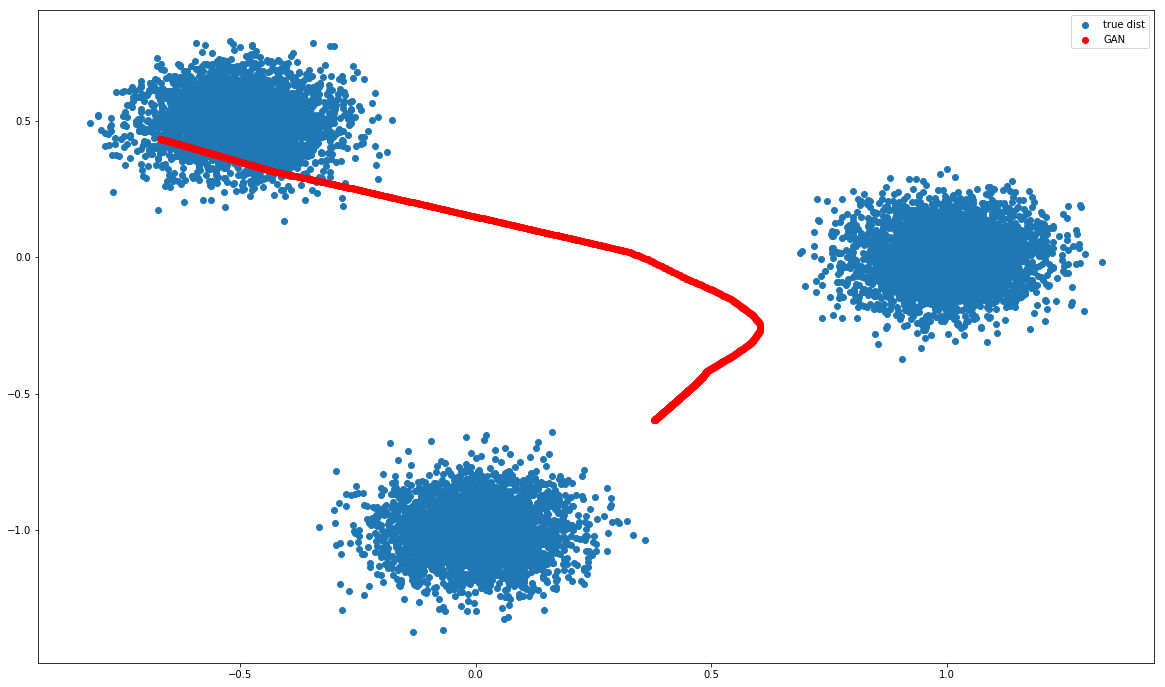

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,12))
plt.scatter(r_samples[:,0], r_samples[:,1], label='true dist')
plt.scatter(samples[:,0], samples[:,1], c='r', label='GAN');
plt.legend();
plt.show()